# Import

In [5]:
#path_essentials = '/Users/Setup3-PC/Desktop/qudi/logic/setup3_logic/script_logic_essentials.py'
path_essentials = 'user_scripts/Timo/from_Simon/script_logic_essentials.py'
path_toolkit = 'user_scripts/Timo/own/logic_toolkit.py'
path_curdir = 'user_scripts/Timo/own/'
import os, time, sys
import numpy as np
import copy

from logic.pulsed.predefined_generate_methods.pentacene_methods import DeerAltModes
from logic.pulsed.sampling_functions import DDMethods
from logic.pulsed.sampling_function_defs.sampling_functions_nvision import EnvelopeMethods as Evm
from user_scripts.Timo.own.console_toolkit import Tk_file, Tk_string

# import essentials via run
exec(open(path_essentials).read())
exec(open(path_toolkit).read())
# usual module imports
sys.path.append(path_curdir)


import logging
logging.basicConfig(filename='logfile.log', filemode='w', level=logging.DEBUG)
logger = logging.getLogger(__name__)

# configure this notebook
config_matplotlib_jupyter()

memory_dict=OrderedDict()
print_welcome_msg()
0

0

In [8]:
setup['gated']

False

# Common parameters

In [89]:
class Common(object):
    def __init__(self):
        """
        A | B | C | D
        --------------
        | |   |   | 3028 MHz
        | |   |   | 82 ns
        """
        
        
        # MW parameters
        # rabi _37: C: 138.0ns, D: 162.8ns
        self.rabi_period_rect = 83.7e-9 #allOrientations~ 82.69e-9, shaped: 
        #34.3e-9 #12.75e-9#57.2e-9#94.5e-9 # 87.0e-9 #118.1e-9 #M2 149.1e-9#760e-9#245.5e-9 #159.5e-9
        self.rabi_shaped = {'shaped_on':False, 'period': 285.5e-9, 'env_type': Evm.parabola, 'order_P':1}
        self.mw_freq = 3048.2e6 #3086.1e6 #3026.7e6 #3087.7e6 
        #nv1214.1: 2779.7 #nv1209.2: 2778.5e6 #nv1215.6:  2729.5e6#2784.1e6 #2732.0e6 # 2774.0e6# 2786.2e6 #2775.0e6#827.64e6 #M2 1503.592e6 #M15, 1507.455e6  #1507.747#7e6  #1503.336e6  #2656.5e6#NV M3 1.497129e9 #NV M2 1.503316e9 
        #nv_sA_1221.1: 
        #self.mw_freq = 2313.90e6 # only right HFS line
        self.mw_amp = 0.15

        # Readout
        # RELOAD logic_essentials and upload new seq when changing!
        self.t_laser_pulsed = 3e-6   # for pulsed mes (non NI acq)
        #self.t_laser_pulsed = 10e-6   
        #self.t_laser_pulsed = 1.25e-6   # for pulsed mes (non NI acq)
        self.t_wait_pulsed = 1e-6
        self.t_laser = None
        self.t_laser_green_init = 3e-6
        self.t_laser_red_read = 1000e-9

        # Ramsey
        self.mw_ramsey_offset = -1000e3   # Hz, detuning, 
        self.mw_ramsey_off_from_calib = 0e3 #0.1e6 #[0.66e6, 0.72e6]   # Hz, detuning,taken for checking valid

        # MFL XY8
        self.gamma_n_c13 = 1.0705e3 * 2*np.pi # 13-C
    
    @property
    def rabi_period(self):
        
        if self.rabi_shaped['shaped_on']:
            return self.rabi_shaped['period']
        return self.rabi_period_rect
    
    @staticmethod
    def f_res_2_B_gauss(f_res):
        # only true if B well aligned
        return abs(f_res-2.87e9)/2.8e6
    

    
common = Common()
b_str = f"B= {Common.f_res_2_B_gauss(common.mw_freq):.2f} G from common.mw_freq"
b_str
logger.info(b_str)

"""
# MW parameters
common.rabi_period_rect = 12.83e-9#57.2e-9#94.5e-9 # 87.0e-9 #118.1e-9 #M2 149.1e-9#760e-9#245.5e-9 #159.5e-9
common.rabi_shaped = {'shaped_on':False, 'period': 18.55-9, 'env_type': Evm.parabola, 'order_P':1}
common.mw_freq =  1507.23e6#2784.1e6 #2732.0e6 # 2774.0e6# 2786.2e6 #2775.0e6#827.64e6 #M2 1503.592e6 #M15, 1507.455e6  #1507.747#7e6  #1503.336e6  #2656.5e6#NV M3 1.497129e9 #NV M2 1.503316e9 
#common.mw_freq = 2811.9e6 # only left HFS line
common.mw_amp = 0.25

# Readout
# RELOAD logic_essentials and upload new seq when changing!
common.t_laser_pulsed = 3e-6   # for pulsed mes (non NI acq)
common.t_wait_pulsed = 1e-6
common.t_laser = None
common.t_laser_green_init = 3e-6
common.t_laser_red_read = 1000e-9

# Ramsey
common.mw_ramsey_offset = 1000e3   # Hz, detuning, 
common.mw_ramsey_off_from_calib = 0e3 #0.1e6 #[0.66e6, 0.72e6]   # Hz, detuning,taken for checking valid


# MFL XY8
gamma_n_c13 = 1.0705e3 * 2*np.pi # 13-C
"""

common.rabi_shaped['shaped_on'], 1e9*common.rabi_period

(False, 83.7)

# Library

## nb specific

In [14]:
def setup_podmr_rfpi_params(f_res, p_scale=10, f_step=0.1e6, n_f=50,
                            f_rf=1e6, t_pi_rf=1e-6, ampl_rf=5e-3, alternating_no_rf=False):

    qmeas=OrderedDict()

    if common.rabi_shaped['shaped_on']:
        raise ValueError
    else:
        qmeas['name'] = 'pulsedodmr_rf_pi'
        qmeas['experiment'] = 'pulsedodmr_deer_pi'

    setup['laser_length'] = common.t_laser_pulsed
    setup['wait_time'] = common.t_wait_pulsed


    qmeas['rabi_period'] = common.rabi_period*p_scale
    qmeas['freq_step'] = f_step
    qmeas['num_of_points'] = n_f
    qmeas['freq_start'] = f_res - (qmeas['freq_step'] * qmeas['num_of_points'])/2.
    qmeas['f_mw_deer'] = f_rf
    qmeas['t_pi_deer'] = t_pi_rf
    qmeas['deer_ampl'] = ampl_rf 
    qmeas['alternating_nodeerpi'] = alternating_no_rf
    
    if p_scale != 1:
        qmeas['microwave_amplitude'] = common.mw_amp/(p_scale)
    else:
        qmeas['microwave_amplitude'] = common.mw_amp
    qmeas['measurement_time'] = 9999 
    qmeas['optimize_time'] = None
    qmeas['fit_experiment'] = 'lor_dip'

    qmeas = add_shaped(qmeas)

    return qmeas


def add_shaped(qmeas):
    if common.rabi_shaped['shaped_on']:
        qmeas['env_type'] = common.rabi_shaped['env_type']
        qmeas['order_P'] = common.rabi_shaped['order_P']
    else:
        # to make sure that default of generate method is overwritten
        qmeas['env_type'] = Evm.rectangle
        
    return qmeas
    

def calc_nuclear_rabi_hfs_boost(B_gauss, ms=-1, n_nuc=15):
    # Chen (2015)
    # Sangtawesin (2016)
    
    if n_nuc == 14:
        q_quadro = -4.945e6
        a_par = -2.162e6 # 14-n
        a_perp = 2.62e6
        gamma_n = -0.308e3  
    elif n_nuc == 15:
        q_quadro = 0  # spin=1/2 has no quadropolar moment
        a_par = 3.03e6
        a_perp = 3.65e6
        gamma_n = 0.432e3
        
    else:
        raise ValueError("Can only be 14-N or 15-N")
        
    gamma_e = 2.8e6
    delta = 2.87e9
    
    if ms == -1:
        # in nuc_rabi need pi init of the nv spin
        alpha = 1 + gamma_e/gamma_n* a_perp / (delta-gamma_e*B_gauss-a_par+gamma_n*B_gauss+q_quadro)
    else:
        raise ValueError("m_s can only be 0/1/-1")
    
    return abs(alpha)

def setup_ise_ramsey_dd_params(tau, n_tau, n_order_dd, f_rf, t_pi_rf, amp_rf=0.25, rf_ch='a_ch2', dd_type=DDMethods.SE,
                               t_laser=1e-6, mw_sweep_speed=3e12, f_ise_res=1e9, df_mw_sweep=30e6, amp_mw_sweep=0.25,
                               alternating=True, autosave=-1, red_readout=False):
    qmeas=OrderedDict()
    qmeas['name'] = 'ise+ramsey+rf_dd'
    qmeas['experiment'] = 'pol_ramsey_rf_dd'
    
    if not red_readout:
        setup['laser_length'] = common.t_laser_pulsed
    else:
        qmeas['t_laser_init'] = common.t_laser_green_init
        qmeas['laser_read_ch'] = 'd_ch3'
        setup['laser_length'] = common.t_laser_red_read
    
    setup['wait_time'] = common.t_wait_pulsed
    
    qmeas['microwave_frequency'] = common.mw_freq + common.mw_ramsey_offset 
    qmeas['microwave_amplitude'] = common.mw_amp
    
    qmeas['tau'] = tau
    qmeas['n_tau'] = n_tau
    qmeas['n_order_pi_rf'] = n_order_dd
    qmeas['dd_type'] = dd_type
    qmeas['f_rf'] = f_rf
    qmeas['t_pi_rf'] = t_pi_rf
    qmeas['amp_rf'] = amp_rf
    qmeas['rf_channel'] = rf_ch
    qmeas['t_laser'] = t_laser
    qmeas['mw_sweep_speed'] = mw_sweep_speed
    qmeas['amp_mw_sweep'] = amp_mw_sweep
    qmeas['f_ise_res'] = f_ise_res
    qmeas['df_mw_sweep'] = df_mw_sweep
    
    qmeas['measurement_time'] = 99999 
    qmeas['optimize_time'] = None
    qmeas['autosave_s'] = autosave
    
    qmeas['alternating'] = alternating
    
    return qmeas

def setup_deer_dd_f_params(f_res, dd_tau=200e-9, f_step=2e6, n_f=50, t_rabi_2=None, deer_ampl=None,
                           dd_type=DDMethods.SE, dd_order=2):
    qmeas=OrderedDict()
    
    if not common.rabi_shaped['shaped_on']:
        logger.error("DEER_dd via nvision method must use pulse shaping")
        return 
    
    qmeas['experiment'] = 'DEER_DD_freq'
    qmeas['name'] = 'deer_dd_spectrum'
    
    setup['laser_length'] = common.t_laser_pulsed
    setup['wait_time'] = common.t_wait_pulsed
    
    qmeas['microwave_frequency'] = common.mw_freq 
    qmeas['microwave_amplitude'] = common.mw_amp
    qmeas['freq_incr'] = f_step
    qmeas['num_of_points'] = n_f
    qmeas['freq_start'] = f_res - (f_step * qmeas['num_of_points'])/2.
    qmeas['rabi_period'] = common.rabi_period
    
    qmeas['measurement_time'] = 150000 
    qmeas['optimize_time'] = None
    
    qmeas['alternating'] = True

    qmeas['tau'] = dd_tau
    if not t_rabi_2:
        qmeas['rabi_period2'] = common.rabi_period    
    else:
        qmeas['rabi_period2'] = t_rabi_2
    if deer_ampl == None:
        qmeas['mw_amp2'] = common.mw_amp
    else:
        qmeas['mw_amp2'] = deer_ampl
    
    qmeas['tau2'] = dd_tau/2 - qmeas['rabi_period2']/4 - common.rabi_period/4
    qmeas['DD_type'] = dd_type
    qmeas['order'] = dd_order
    
    qmeas = add_shaped(qmeas)
    return qmeas


def setup_deer_f_params(f_res, he_tau=200e-9, f_step=2e6, n_f=50, two_deer_pi=True, pi_len=None, read_phases='0, 180',
                       deer_ampl=None):
    qmeas=OrderedDict()
    qmeas['name'] = 'deer_spectrum'
    setup['laser_length'] = common.t_laser_pulsed
    setup['wait_time'] = common.t_wait_pulsed

    qmeas['freq_step'] = f_step
    qmeas['num_of_points'] = n_f
    qmeas['freq_start'] = f_res - (qmeas['freq_step'] * qmeas['num_of_points'])/2.
    qmeas['rabi_period'] = common.rabi_period

    qmeas['measurement_time'] = 150000 
    qmeas['optimize_time'] = None
    
    qmeas['alternating'] = True
    qmeas['two_deer_pi'] = two_deer_pi
    qmeas['he_tau'] = he_tau
    if not deer_ampl:
        qmeas['deer_amp'] = common.mw_amp
    else:
        qmeas['deer_amp'] = deer_ampl
    if not pi_len:
        qmeas['pi_len'] = common.rabi_period/2
    else:
        qmeas['pi_len'] = pi_len
    
    qmeas['read_phase_degree'] = read_phases
    
    return qmeas

def setup_deer_rabi_params(deer_freq, tau_start=10e-9, tau_step=1e-6, n_tau=50, 
                      he_tau=300e-9, read_phases='0, 180', deer_ampl=None,
                      two_deer_pi=True):
    qmeas=OrderedDict()
    qmeas['name'] = 'deer_rabi'
    setup['laser_length'] = common.t_laser_pulsed
    setup['wait_time'] = common.t_wait_pulsed

    qmeas['tau_start'] = tau_start
    qmeas['num_of_taus'] = n_tau
    qmeas['tau_step'] = tau_step

    qmeas['measurement_time'] = 99999 
    qmeas['optimize_time'] = None
    

    qmeas['he_tau'] = he_tau
    qmeas['two_deer_pi'] = two_deer_pi
    if not deer_ampl:
        qmeas['deer_amp'] = common.mw_amp
    else:
        qmeas['deer_amp'] = deer_ampl
    qmeas['deer_freq'] = deer_freq

    
    qmeas['alternating'] = True
    qmeas['read_phase_degree'] = read_phases
    
    return qmeas


def setup_deer_params(deer_freq, tau_start=10e-9, tau_step=1e-6, n_tau=50, 
                      he_tau=300e-9, second_rabi_period=None,
                      two_deer_pi=True):
    qmeas=OrderedDict()
    qmeas['name'] = 'DEER'
    setup['laser_length'] = common.t_laser_pulsed
    setup['wait_time'] = common.t_wait_pulsed

    qmeas['tau_start'] = tau_start
    qmeas['num_of_points'] = n_tau
    qmeas['tau_step'] = tau_step

    qmeas['measurement_time'] = 99999 
    qmeas['optimize_time'] = None
    

    qmeas['he_tau'] = he_tau
    qmeas['two_deer_pi'] = two_deer_pi

    qmeas['deer_amp'] = common.mw_amp
    qmeas['deer_freq'] = deer_freq
    if not second_rabi_period:
        qmeas['second_rabi_period'] = common.rabi_period
    else:
        qmeas['second_rabi_period'] = second_rabi_period
   
    qmeas['alternating'] = True
    
    return qmeas


def setup_ramsey_deer_pi_params(f_deer, t_pi_deer, 
                                tau_start=100e-9, n_tau=1, tau_step=None,
                                alternating_mode=DeerAltModes.NVPi3Half,
                                two_deer_pi=False):
    qmeas=OrderedDict()
    qmeas['name'] = 'Ramsey_deer_pi'
    qmeas['experiment'] = 'ramsey_deer_pi'
    setup['laser_length'] = common.t_laser_pulsed
    
    qmeas['rabi_period'] = common.rabi_period
    qmeas['microwave_frequency'] = common.mw_freq 
    qmeas['microwave_amplitude'] = common.mw_amp
    qmeas['tau_start'] = tau_start
    if tau_step is None:
        qmeas['tau_step'] = 50e-9
    else:
        qmeas['tau_step'] = tau_step
    qmeas['num_of_points'] = n_tau
    qmeas['alternating_mode'] = alternating_mode
    
    qmeas['from_list'] = False
    
    qmeas['optimize_time'] = None
    #qmeas['freq_optimization_time'] = None
    #qmeas['analysis_interval'] = 3
    if n_tau > 1:
        qmeas['fit_experiment'] = 'sine'
     
    qmeas['f_mw_deer'] = f_deer
    qmeas['t_pi_deer'] = t_pi_deer
    qmeas['two_deer_pi'] = two_deer_pi
    
    return qmeas

def setup_podmr_deer_pi_params(f_res, f_deer, t_pi_deer, 
                               p_scale=10, p_scale_onlyperiod=1, f_step=0.1e6, n_f=50, t_pi_manual=None):
    # @param p_scale_onlyperiod: scales rabi period according to given power factor.
    #                            useful, if externally controlling poewr
    qmeas=OrderedDict()
    qmeas['name'] = 'pulsedodmr_deer_pi'
    qmeas['experiment'] = 'pulsedodmr_deer_pi'
    setup['laser_length'] = common.t_laser_pulsed
    setup['wait_time'] = common.t_wait_pulsed
    if t_pi_manual:
        qmeas['rabi_period'] = 2*t_pi_manual
    else:
        qmeas['rabi_period'] = common.rabi_period*p_scale*p_scale_onlyperiod
    qmeas['freq_step'] = f_step
    qmeas['num_of_points'] = n_f
    qmeas['freq_start'] = f_res - (qmeas['freq_step'] * qmeas['num_of_points'])/2.
    if p_scale != 1:
        qmeas['microwave_amplitude'] = common.mw_amp/(p_scale)
        qmeas['deer_amplitude'] = common.mw_amp
    else:
        qmeas['microwave_amplitude'] = common.mw_amp
        qmeas['deer_amplitude'] = common.mw_amp
    qmeas['measurement_time'] = 1500 
    qmeas['optimize_time'] = None
    qmeas['fit_experiment'] = 'lor_dip'
    
    qmeas['f_mw_deer'] = f_deer
    qmeas['t_pi_deer'] = t_pi_deer
    
    return qmeas



def run_deer_f(mes_params, save_tag=None, generate_new=True):
    laser_off()
    if save_tag is None:
        save_tag='deer_f'
    do_experiment(experiment='deer_spectrum', qm_dict=mes_params, meas_type=conventional_measurement, meas_info=add_conventional_information, 
                  generate_new=generate_new, save_tag=save_tag, load_tag='')

def run_deer(mes_params, save_tag=None, generate_new=True):
    laser_off()
    if save_tag is None:
        save_tag='deer'
    do_experiment(experiment='DEER', qm_dict=mes_params, meas_type=conventional_measurement, meas_info=add_conventional_information, 
                  generate_new=generate_new, save_tag=save_tag, load_tag='')


def run_deer_rabi(mes_params, save_tag=None, generate_new=True):
    laser_off()
    if save_tag is None:
        save_tag='deer_rabi'
    do_experiment(experiment='deer_rabi', qm_dict=mes_params, meas_type=conventional_measurement, meas_info=add_conventional_information, 
                  generate_new=generate_new, save_tag=save_tag, load_tag='')


    
def run_deer_pi_start(mes_params, save_tag=None, generate_new=True):
    laser_off()
    if save_tag is None:
        save_tag='deer_pi_start'
    do_experiment(experiment='DEER_pi_start', qm_dict=mes_params, meas_type=conventional_measurement, meas_info=add_conventional_information, 
                  generate_new=generate_new, save_tag=save_tag, load_tag='')
    
def setup_double_hh_f_params(f_start=0e6, n_f=50, f_step=1e6, spinlock_length=100e-9,
                             ampl_spinlock=0.25, ampl_dress2=0.25):
    qmeas=OrderedDict()
    qmeas['name'] = 'HH_double_f'
    qmeas['experiment'] = 'HH_double_fsweep'
    setup['laser_length'] = common.t_laser_pulsed
    
    qmeas['rabi_period'] = common.rabi_period
    qmeas['microwave_frequency'] = common.mw_freq 
    qmeas['microwave_amplitude'] = common.mw_amp
    qmeas['f_start'] = f_start
    if f_step is None:
        qmeas['f_step'] = 1e6
    else:
        qmeas['f_step'] = f_step
    qmeas['num_of_points'] = n_f
    
    qmeas['spinlock_length'] = spinlock_length
    qmeas['ampl_spinlock'] = ampl_spinlock
    qmeas['ampl_dress2'] = ampl_dress2
    qmeas['phase_dress2'] = 90
    
    qmeas['wait_time'] = common.t_wait_pulsed
    
    qmeas['optimize_time'] = None
    #qmeas['freq_optimization_time'] = None
    #qmeas['analysis_interval'] = 3
 
    #qmeas = setup_penta_laser_analysis(qmeas)
    #qmeas = setup_penta_fastcounter_settings(qmeas)
    
    return qmeas

def setup_double_hh_tau_params(f_dress2=10e6, n_tau=50, tau_start=10e-9, tau_step=100e-9,
                             ampl_spinlock=0.25, ampl_dress2=0.25):
    qmeas=OrderedDict()
    qmeas['name'] = 'HH_double_tau'
    qmeas['experiment'] = 'HH_double_tau'
    setup['laser_length'] = common.t_laser_pulsed
    
    qmeas['rabi_period'] = common.rabi_period
    qmeas['microwave_frequency'] = common.mw_freq 
    qmeas['microwave_amplitude'] = common.mw_amp
    qmeas['tau_start'] = tau_start
    qmeas['tau_step'] = tau_step
    qmeas['num_of_points'] = n_tau
    
    qmeas['dress2_f'] = f_dress2
    qmeas['ampl_spinlock'] = ampl_spinlock
    qmeas['ampl_dress2'] = ampl_dress2
    qmeas['phase_dress2'] = 90
    
    qmeas['wait_time'] = common.t_wait_pulsed
    
    qmeas['optimize_time'] = None
    #qmeas['freq_optimization_time'] = None
    #qmeas['analysis_interval'] = 3
 
    #qmeas = setup_penta_laser_analysis(qmeas)
    #qmeas = setup_penta_fastcounter_settings(qmeas)
    
    return qmeas

def setup_double_hh_dsl_tau_params(f_dress2=10e6, n_tau=50, tau_start=10e-9, tau_step=100e-9,
                             ampl_spinlock=0.25, ampl_pi2_dress2=0.1, ampl_dress2=0.25, t_rabi_dress2=100e-9,
                                  alternating_dress2_init=False):
    qmeas=OrderedDict()
    qmeas['name'] = 'HH_double_dsl_tau'
    qmeas['experiment'] = 'HH_double_dsl_tau'
    setup['laser_length'] = common.t_laser_pulsed
    
    qmeas['rabi_period'] = common.rabi_period
    qmeas['microwave_frequency'] = common.mw_freq 
    qmeas['microwave_amplitude'] = common.mw_amp
    qmeas['tau_start'] = tau_start
    qmeas['tau_step'] = tau_step
    qmeas['num_of_points'] = n_tau
    
    qmeas['dress2_f'] = f_dress2
    qmeas['ampl_spinlock'] = ampl_spinlock
    qmeas['ampl_dress2'] = ampl_dress2
    qmeas['ampl_pi2_dress2'] = ampl_pi2_dress2
    qmeas['t_rabi_dress2'] = t_rabi_dress2
    qmeas['phase_dress2'] = 90
    qmeas['alternating_pi2_dress2'] = alternating_dress2_init
    
    qmeas['wait_time'] = common.t_wait_pulsed
    
    qmeas['optimize_time'] = None
    #qmeas['freq_optimization_time'] = None
    #qmeas['analysis_interval'] = 3
 
    #qmeas = setup_penta_laser_analysis(qmeas)
    #qmeas = setup_penta_fastcounter_settings(qmeas)
    
    return qmeas


def setup_double_hh_ise_tau_params(f_dress2=10e6, n_tau=50, tau_start=10e-9, tau_step=100e-9,
                             ampl_spinlock=0.25, df_ise=300e3, ampl_ise=0.1, sweep_speed_ise=0.1e12,
                                  alternating_depol=False):
    qmeas=OrderedDict()
    qmeas['name'] = 'HH_double_ise_tau'
    qmeas['experiment'] = 'HH_double_ise_tau'
    setup['laser_length'] = common.t_laser_pulsed
    
    qmeas['rabi_period'] = common.rabi_period
    qmeas['microwave_frequency'] = common.mw_freq 
    qmeas['microwave_amplitude'] = common.mw_amp
    qmeas['tau_start'] = tau_start
    qmeas['tau_step'] = tau_step
    qmeas['num_of_points'] = n_tau
    
    qmeas['dress2_f'] = f_dress2
    qmeas['ampl_spinlock'] = ampl_spinlock
    qmeas['ampl_ise'] = ampl_ise
    qmeas['sweep_speed_ise'] = sweep_speed_ise
    qmeas['df_ise'] = df_ise
    qmeas['alternating_pol'] = alternating_depol
    
    qmeas['wait_time'] = common.t_wait_pulsed
    
    qmeas['optimize_time'] = None
    #qmeas['freq_optimization_time'] = None
    #qmeas['analysis_interval'] = 3
 
    #qmeas = setup_penta_laser_analysis(qmeas)
    #qmeas = setup_penta_fastcounter_settings(qmeas)
    
    return qmeas

def setup_double_hh_ise_ramsey_params(f_dress2=10e6, n_tau=50, tau_start=10e-9, tau_step=100e-9, tau_ise=10e-6,
                             ampl_spinlock=0.25, df_ise=300e3, ampl_ise=0.1, sweep_speed_ise=0.1e12,
                                  alternating_depol=False):
    qmeas=OrderedDict()
    qmeas['name'] = 'HH_double_ise_ramsey'
    qmeas['experiment'] = 'HH_double_ise_ramsey'
    setup['laser_length'] = common.t_laser_pulsed
    
    qmeas['rabi_period'] = common.rabi_period
    qmeas['microwave_frequency'] = common.mw_freq 
    qmeas['microwave_amplitude'] = common.mw_amp
    qmeas['tau_ram_start'] = tau_start
    qmeas['tau_ram_step'] = tau_step
    qmeas['num_of_points'] = n_tau
    
    qmeas['tau_ise'] = tau_ise
    qmeas['dress2_f'] = f_dress2
    qmeas['ampl_spinlock'] = ampl_spinlock
    qmeas['ampl_ise'] = ampl_ise
    qmeas['sweep_speed_ise'] = sweep_speed_ise
    qmeas['df_ise'] = df_ise
    qmeas['alternating_pol'] = alternating_depol
    
    qmeas['wait_time'] = common.t_wait_pulsed
    
    qmeas['optimize_time'] = None
    #qmeas['freq_optimization_time'] = None
    #qmeas['analysis_interval'] = 3
 
    #qmeas = setup_penta_laser_analysis(qmeas)
    #qmeas = setup_penta_fastcounter_settings(qmeas)
    
    return qmeas

def setup_double_hh_ise_dhh_f_params(f_dress2=10e6, n_tau=50, f_start=10e-9, f_step=100e-9, tau_ise=10e-6,
                             ampl_spinlock=0.25, df_ise=300e3, ampl_ise=0.1, sweep_speed_ise=0.1e12,
                             ampl_dhh_dress2=0.1, t_dhh_lock=10e-6,
                             alternating_depol=False):
    qmeas=OrderedDict()
    qmeas['name'] = 'HH_double_ise_dhh_f'
    qmeas['experiment'] = 'HH_double_ise_dhh_f'
    setup['laser_length'] = common.t_laser_pulsed
    
    qmeas['rabi_period'] = common.rabi_period
    qmeas['microwave_frequency'] = common.mw_freq 
    qmeas['microwave_amplitude'] = common.mw_amp
    qmeas['f_dhh_start'] = f_start
    qmeas['f_dhh_step'] = f_step
    qmeas['num_of_points'] = n_tau
    
    qmeas['tau_ise'] = tau_ise
    qmeas['dress2_f'] = f_dress2
    qmeas['ampl_spinlock'] = ampl_spinlock
    qmeas['ampl_ise'] = ampl_ise
    qmeas['sweep_speed_ise'] = sweep_speed_ise
    qmeas['df_ise'] = df_ise
    qmeas['alternating_pol'] = alternating_depol
    qmeas['ampl_dhh_dress2'] = ampl_dhh_dress2
    qmeas['t_dhh_lock'] = t_dhh_lock
    
    qmeas['wait_time'] = common.t_wait_pulsed
    
    
    qmeas['optimize_time'] = None
    #qmeas['freq_optimization_time'] = None
    #qmeas['analysis_interval'] = 3
 
    #qmeas = setup_penta_laser_analysis(qmeas)
    #qmeas = setup_penta_fastcounter_settings(qmeas)
    
    return qmeas

def setup_hh_tau_params(tau_start=0e-6, tau_step=1e-6, n_tau=50, amp_sl=1e-3):
    qmeas=OrderedDict()
    qmeas['name'] = 'hh_tau'
    qmeas['experiment'] = 'HHtau'
    setup['laser_length'] = common.t_laser_pulsed
    
    qmeas['rabi_period'] = common.rabi_period
    qmeas['microwave_frequency'] = common.mw_freq 
    qmeas['microwave_amplitude'] = common.mw_amp
    qmeas['tau_start'] = tau_start
    qmeas['tau_step'] = tau_step
    qmeas['num_of_points'] = n_tau
    
    qmeas['spinlock_amp'] = amp_sl
    
    qmeas['wait_time'] = common.t_wait_pulsed
    
    qmeas['optimize_time'] = None
    #qmeas['freq_optimization_time'] = None
    #qmeas['analysis_interval'] = 3
 
    #qmeas = setup_penta_laser_analysis(qmeas)
    #qmeas = setup_penta_fastcounter_settings(qmeas)
    
    return qmeas

def setup_dd_mollow_n_params(tau=500e-9, dd_start=1, dd_step=1, n_dd=20, dd_type=DDMethods.SE, 
                             ampl_mol=1.5e-3, f_mol=0e6, phase_mod='0',
                             alternating=True):

    qmeas=OrderedDict()
    qmeas['experiment'] = 'dd_mollow_n'
    qmeas['name'] = f"dd_mollow_{str(dd_type).replace('DDMethods.','')}_n"
    setup['laser_length'] = common.t_laser_pulsed
    
    qmeas['rabi_period'] = common.rabi_period
    qmeas['microwave_frequency'] = common.mw_freq 
    qmeas['microwave_amplitude'] = common.mw_amp
    
    qmeas['tau'] = tau
    qmeas['dd_order_start'] = dd_start
    qmeas['dd_step'] = dd_step
    qmeas['dd_type'] = dd_type
    qmeas['ampl_mol'] = ampl_mol
    qmeas['f_mol'] = f_mol
    qmeas['phase_mod'] = phase_mod
        
    
    qmeas['num_of_points'] = n_dd
    qmeas['alternating'] = alternating
        
    qmeas['optimize_time'] = None
    #qmeas['freq_optimization_time'] = None
    #qmeas['analysis_interval'] = 3
    if n_dd > 1:
        qmeas['fit_experiment'] = 'sine_decay'
     
    qmeas = add_shaped(qmeas)
    
    return qmeas

def setup_rnovel_ppol_propi_params(dd_tau=500e-9, dd_order=1, dd_type=DDMethods.CPMG, 
                             ampl_mol=1.5e-3, n_pol=100, tau_ppol=0.5e-6, order_ppol=10, m_read_step=30,
                             alternating=True, shape_only_ppol=False):

    qmeas=OrderedDict()
    qmeas['experiment'] = 'rnovel_ppol_propi'

    qmeas['name'] = f"rnovel_ppol_propi"
    qmeas['sequence_mode'] = True
    setup['laser_length'] = common.t_laser_pulsed
    
    qmeas['rabi_period'] = common.rabi_period
    if shape_only_ppol:
        qmeas['dd_t_rabi_rect'] = common.rabi_period_rect
    qmeas['microwave_frequency'] = common.mw_freq 
    qmeas['microwave_amplitude'] = common.mw_amp
    
    # rnovel params
    qmeas['dd_mol_tau'] = tau
    qmeas['dd_mol_order'] = dd_order
    qmeas['dd_mol_ampl'] = ampl_mol
    qmeas['dd_mol_type'] = dd_type
    qmeas['n_pol'] = n_pol
    # propi params
    qmeas['m_read_step'] = m_read_step
    qmeas['tau_ppol'] = tau_ppol
    qmeas['order_ppol'] = order_ppol
        

    qmeas['alternating'] = alternating
        
    qmeas['optimize_time'] = None
    #qmeas['freq_optimization_time'] = None
    #qmeas['analysis_interval'] = 3
    
    qmeas = add_shaped(qmeas)
        
    if m_read_step > 1:
        qmeas['fit_experiment'] = 'decay_exp'
 
    return qmeas

def setup_ppol_tau_params(tau_start=0.5e-6, tau_step=20e-9,
                         num_of_points=50, order=8,
                             alternating=True):

    qmeas=OrderedDict()
    qmeas['experiment'] = 'Poltau'

    qmeas['name'] = f"ppol_tau"
    setup['laser_length'] = common.t_laser_pulsed
    
    qmeas['rabi_period'] = common.rabi_period
    qmeas['microwave_frequency'] = common.mw_freq 
    qmeas['microwave_amplitude'] = common.mw_amp
    
    qmeas['tau_start'] = tau_start
    qmeas['tau_step'] = tau_step
    qmeas['order'] = order
    
    qmeas['num_of_points'] = num_of_points
    qmeas['alternating'] = alternating
        
    qmeas['optimize_time'] = None
    #qmeas['freq_optimization_time'] = None
    #qmeas['analysis_interval'] = 3
    if num_of_points > 1:
        qmeas['fit_experiment'] = 'lor_dip'
     
    
    qmeas = add_shaped(qmeas)
        
    return qmeas

def setup_ppol_n_params(tau=500e-9, n_start=1, n_step=1,
                         num_of_points=50, alternating=True):

    qmeas=OrderedDict()
    qmeas['experiment'] = 'Pol20_order'
    
    qmeas['name'] = f"ppol_n"
    setup['laser_length'] = common.t_laser_pulsed
    
    qmeas['rabi_period'] = common.rabi_period
    qmeas['microwave_frequency'] = common.mw_freq 
    qmeas['microwave_amplitude'] = common.mw_amp
    
    qmeas['n_start'] = n_start
    qmeas['n_step'] = n_start
    qmeas['tau'] = tau
    
    qmeas['num_of_points'] = num_of_points
    qmeas['alternating'] = alternating
        
    qmeas['optimize_time'] = None
    #qmeas['freq_optimization_time'] = None
    #qmeas['analysis_interval'] = 3
    if num_of_points > 1:
        qmeas['fit_experiment'] = 'sine'
    
    qmeas = add_shaped(qmeas)
 
    return qmeas

def setup_ppol_propi_params(tau=500e-9, n_start=1, n_step=1,
                         num_of_points=50, alternating=True):

    qmeas=OrderedDict()
    qmeas['experiment'] = 'Pol20_order'
    qmeas['name'] = f"ppol_n"
    setup['laser_length'] = common.t_laser_pulsed
    
    qmeas['rabi_period'] = common.rabi_period
    qmeas['microwave_frequency'] = common.mw_freq 
    qmeas['microwave_amplitude'] = common.mw_amp
    
    qmeas['n_start'] = n_start
    qmeas['n_step'] = n_start
    qmeas['tau'] = tau
    
    qmeas['num_of_points'] = num_of_points
    qmeas['alternating'] = alternating
        
    qmeas['optimize_time'] = None
    #qmeas['freq_optimization_time'] = None
    #qmeas['analysis_interval'] = 3
    if num_of_points > 1:
        qmeas['fit_experiment'] = 'sine'
     
    qmeas = add_shaped(qmeas)
        
    return qmeas


def setup_ppol_2x_propi_params(tau=500e-9, n_pol=100, m_read=20, order_ppol=8,
                         alternating=True):

    qmeas=OrderedDict()
    qmeas['experiment'] = 'ppol_2x_propi'
    qmeas['name'] = f"ppol_2x_propi"
    qmeas['sequence_mode'] = True
    setup['laser_length'] = common.t_laser_pulsed
    
    qmeas['rabi_period'] = common.rabi_period
    qmeas['microwave_frequency'] = common.mw_freq 
    qmeas['microwave_amplitude'] = common.mw_amp
    
    qmeas['n_pol'] = n_pol
    qmeas['m_read_step'] = m_read
    qmeas['tau_ppol'] = tau
    qmeas['order_ppol'] = order_ppol
    
    #qmeas['num_of_points'] = num_of_points
    qmeas['alternating'] = alternating
        
    qmeas['optimize_time'] = None
    #qmeas['freq_optimization_time'] = None
    #qmeas['analysis_interval'] = 3
    if m_read > 1:
        qmeas['fit_experiment'] = 'decay_exp'
     
    qmeas = add_shaped(qmeas)
        
    return qmeas

def setup_ise_propi_params(tau_ppol=500e-9, n_pol=100, m_read=20, order_ppol=8,
                           df_mw_sweep=3e6, t_ise=1e-6, mw_sweep_speed=1e12, amp_mw_sweep=0.1,
                           ppol_read_dir='down',
                           alternating=True):

    qmeas=OrderedDict()
    qmeas['experiment'] = 'ise_ppol_propi'
    qmeas['name'] = f"ise_ppol_propi"
    qmeas['sequence_mode'] = True
    setup['laser_length'] = common.t_laser_pulsed
    
    qmeas['rabi_period'] = common.rabi_period
    qmeas['microwave_frequency'] = common.mw_freq 
    qmeas['microwave_amplitude'] = common.mw_amp
    
    qmeas['n_pol'] = n_pol
    qmeas['m_read_step'] = m_read
    qmeas['tau_ppol'] = tau_ppol
    qmeas['order_ppol'] = order_ppol
    qmeas['ppol_read_dir'] = ppol_read_dir
    
    qmeas['t_ise'] = t_ise
    qmeas['df_mw_sweep'] = df_mw_sweep
    qmeas['mw_sweep_speed'] = mw_sweep_speed
    qmeas['amp_mw_sweep'] = amp_mw_sweep
    
    
    #qmeas['num_of_points'] = num_of_points
    qmeas['alternating'] = alternating
        
    qmeas['optimize_time'] = None
    #qmeas['freq_optimization_time'] = None
    #qmeas['analysis_interval'] = 3
    if m_read > 1:
        qmeas['fit_experiment'] = 'decay_exp'
     
    qmeas = add_shaped(qmeas)
        
    return qmeas

## Basics

In [17]:

import pickle
from scipy.optimize import curve_fit
from scipy.stats import poisson

def setup_nuc_podmr_params(f_start=2.7e6,  f_step=5e3, n_f=50, t_nuc_rabi=50e6, rf_ampl=50e-3):
    qmeas=OrderedDict()

    if common.rabi_shaped['shaped_on']:
        raise NotImplemented
    else:
        qmeas['name'] = 'nuc_pulsedodmr'
        qmeas['experiment'] = 'nuc_pulsedodmr'

    setup['laser_length'] = common.t_laser_pulsed
    setup['wait_time'] = common.t_wait_pulsed
    
    qmeas['microwave_frequency'] = common.mw_freq #+ 0.5*3.03e6
    qmeas['rabi_period'] = common.rabi_period
    qmeas['freq_start'] = f_start
    qmeas['freq_step'] = f_step
    qmeas['num_of_points'] = n_f
    
    qmeas['rf_chnl'] = 'a_ch2'
    qmeas['rf_ampl'] = rf_ampl
    qmeas['t_nuc_rabi'] = t_nuc_rabi
    qmeas['nv_pi_init'] = True
    qmeas['alternating_no_rf'] = True
    

    qmeas['measurement_time'] = 1500 
    qmeas['optimize_time'] = None
    qmeas['fit_experiment'] = 'lor_dip'

    return qmeas

def setup_nuc_rabi_params(tau_step=1e-6, rf_freq=2.6e6, rf_ampl=50e-3, n_tau=50):

    qmeas=OrderedDict()

    if common.rabi_shaped['shaped_on']:
        raise NotImplemented
    else:
        qmeas['name'] = 'nuc_rabi'
        qmeas['experiment'] = 'nuc_rabi'

    setup['laser_length'] = common.t_laser_pulsed
    qmeas['rabi_period'] = common.rabi_period

    qmeas['tau_step'] = tau_step
    qmeas['tau_start'] = 1e-6    
    qmeas['num_of_points'] = n_tau
    qmeas['microwave_frequency'] = common.mw_freq #+ 0.5*3.03e6
    qmeas['microwave_amplitude'] = common.mw_amp
    
    qmeas['rf_chnl'] = 'a_ch2'
    qmeas['rf_ampl'] = rf_ampl
    qmeas['rf_freq'] = rf_freq
    qmeas['nv_pi_init'] = True
    qmeas['alternating_no_rf'] = True
    
    qmeas['measurement_time'] = None
    qmeas['optimize_time'] = None
    qmeas['freq_optimize_time'] = None


    qmeas['fit_experiment'] = 'sine'
    #qmeas['analysis_interval'] = 3
    #qmeas['n_sweeps'] = 5


    return qmeas

def setup_podmr_params(f_res, p_scale=10, p_scale_onlyperiod=1, f_step=0.1e6, n_f=50, t_pi_manual=None):
    # @param p_scale_onlyperiod: scales rabi period according to given power factor.
    #                            useful, if externally controlling poewr
    qmeas=OrderedDict()

    if common.rabi_shaped['shaped_on']:
        qmeas['name'] = 'pulsedodmr_shaped'
        qmeas['experiment'] = 'pulsedodmr_shaped'
        # empirically, don't know where the scaling difference comes from
        #p_scale_onlyperiod *= 0.5
    else:
        qmeas['name'] = 'pulsedodmr'
        qmeas['experiment'] = 'pulsedodmr'

    setup['laser_length'] = common.t_laser_pulsed
    setup['wait_time'] = common.t_wait_pulsed

    if t_pi_manual:
        qmeas['rabi_period'] = 2*t_pi_manual
    else:
        qmeas['rabi_period'] = common.rabi_period*p_scale*p_scale_onlyperiod
    qmeas['freq_step'] = f_step
    qmeas['num_of_points'] = n_f
    qmeas['freq_start'] = f_res - (qmeas['freq_step'] * qmeas['num_of_points'])/2.
    if p_scale != 1:
        qmeas['microwave_amplitude'] = common.mw_amp/(p_scale)
    else:
        qmeas['microwave_amplitude'] = common.mw_amp
    qmeas['measurement_time'] = 1500 
    qmeas['optimize_time'] = None
    qmeas['fit_experiment'] = 'lor_dip'

    qmeas = add_shaped(qmeas)

    return qmeas


def setup_rabi_params(tau_step=None, p_scale=1, n_tau=50, leave_out_tau_idx='', 
                      alternating=True):

    qmeas=OrderedDict()

    if common.rabi_shaped['shaped_on']:
        qmeas['name'] = 'rabi_shaped'
        qmeas['experiment'] = 'rabi_shaped'
    else:
        qmeas['name'] = 'rabi'
        qmeas['experiment'] = 'rabi'

    setup['laser_length'] = common.t_laser_pulsed
    qmeas['rabi_period'] = common.rabi_period

    if tau_step is None:   
        tau_step = 5e-9
    qmeas['tau_step'] = tau_step
    qmeas['tau_start'] = 0e-9
    qmeas['alternating'] = alternating
    qmeas['leave_out_tau_idx'] = leave_out_tau_idx

    qmeas['num_of_points'] = n_tau
    qmeas['microwave_frequency'] = common.mw_freq #+ 0.5*3.03e6
    if p_scale != 1:
        qmeas['microwave_amplitude'] = common.mw_amp/(p_scale)
    else:
        qmeas['microwave_amplitude'] = common.mw_amp
    qmeas['measurement_time'] = None
    qmeas['optimize_time'] = None
    qmeas['freq_optimize_time'] = None


    qmeas['fit_experiment'] = 'sine'
    #qmeas['analysis_interval'] = 3
    #qmeas['n_sweeps'] = 5

    qmeas = add_shaped(qmeas)

    return qmeas

def setup_ramsey_params(tau_start=100e-9, n_tau=1, tau_step=None, alternating=False, read_phases='0, 180',
                       red_readout=False):
    qmeas=OrderedDict()
    qmeas['name'] = 'Ramsey'
    qmeas['experiment'] = 'ramsey_s3p'
    if not red_readout:
        setup['laser_length'] = common.t_laser_pulsed
    else:
        qmeas['t_laser_init'] = common.t_laser_green_init
        qmeas['laser_read_ch'] = 'd_ch3'
        setup['laser_length'] = common.t_laser_red_read

    qmeas['rabi_period'] = common.rabi_period
    qmeas['microwave_frequency'] = common.mw_freq + common.mw_ramsey_offset
    qmeas['microwave_amplitude'] = common.mw_amp
    qmeas['tau_start'] = tau_start
    if tau_step is None:
        qmeas['tau_step'] = 50e-9
    else:
        qmeas['tau_step'] = tau_step
    qmeas['num_of_points'] = n_tau
    qmeas['alternating'] = alternating

    qmeas['from_list'] = False

    qmeas['optimize_time'] = None
    #qmeas['freq_optimization_time'] = None
    #qmeas['analysis_interval'] = 3
    if n_tau > 1:
        qmeas['fit_experiment'] = 'sine_decay'

    qmeas['read_phases_degree'] = read_phases

    return qmeas

def setup_hahn_params(tau_start=50e-9, n_tau=50, tau_step=0.5e-6, alternating=False):
    qmeas=OrderedDict()
    qmeas['name'] = 'hahnecho'
    qmeas['experiment'] = 'hahnecho'
    setup['laser_length'] = common.t_laser_pulsed

    qmeas['rabi_period'] = common.rabi_period
    qmeas['microwave_frequency'] = common.mw_freq
    qmeas['microwave_amplitude'] = common.mw_amp
    qmeas['tau_start'] = tau_start
    if tau_step is None:
        qmeas['tau_step'] = 50e-9
    else:
        qmeas['tau_step'] = tau_step
    qmeas['num_of_points'] = n_tau
    qmeas['alternating'] = alternating

    qmeas['optimize_time'] = None
    #qmeas['freq_optimization_time'] = None
    #qmeas['analysis_interval'] = 3
    if n_tau > 1:
        qmeas['fit_experiment'] = 'exp'

    return qmeas


def setup_xy8_tausweep_params(tau_start=100e-9, n_tau=20, tau_step=None, xy8_order=1, alternating=False):
    qmeas=OrderedDict()
    qmeas['experiment'] = 'xy8_tau'
    qmeas['name'] = 'xy8_tau'
    setup['laser_length'] = common.t_laser_pulsed

    qmeas['rabi_period'] = common.rabi_period
    qmeas['microwave_frequency'] = common.mw_freq 
    qmeas['microwave_amplitude'] = common.mw_amp

    qmeas['xy8_order'] = xy8_order
    qmeas['tau_start'] = tau_start
    if tau_step is None:
        qmeas['tau_step'] = 100e-9
    else:
        qmeas['tau_step'] = tau_step


    qmeas['num_of_points'] = n_tau
    qmeas['alternating'] = alternating

    qmeas['from_list'] = False

    qmeas['optimize_time'] = None
    #qmeas['freq_optimization_time'] = None
    #qmeas['analysis_interval'] = 3
    if n_tau > 1:
        qmeas['fit_experiment'] = 'Lorentz dip'

    return qmeas

def setup_xy8_nsweep_params(tau=500e-9, n_n=20, xy8_start=1, xy8_step=1, alternating=False):
    qmeas=OrderedDict()
    qmeas['experiment'] = 'xy8_nsweep'
    qmeas['name'] = 'xy8_nsweep'
    setup['laser_length'] = common.t_laser_pulsed

    qmeas['rabi_period'] = common.rabi_period
    qmeas['microwave_frequency'] = common.mw_freq 
    qmeas['microwave_amplitude'] = common.mw_amp

    qmeas['tau'] = tau
    qmeas['xy8_start'] = xy8_start
    qmeas['xy8_step'] = xy8_step



    qmeas['num_of_points'] = n_n
    qmeas['alternating'] = alternating

    qmeas['from_list'] = False

    qmeas['optimize_time'] = None
    #qmeas['freq_optimization_time'] = None
    #qmeas['analysis_interval'] = 3
    if n_n > 1:
        qmeas['fit_experiment'] = 'sine_decay'

    return qmeas

def run_generic(mes_params, save_tag=None, generate_new=True):
    laser_off()
    if save_tag is None:
        save_tag=f"{mes_params['name']}"
    mes_params['savetag'] = save_tag
    do_experiment(experiment=mes_params['experiment'], qm_dict=mes_params, meas_type=conventional_measurement,
                  meas_info=add_conventional_information,
                  generate_new=generate_new, save_tag=save_tag, load_tag='')

def run_generic_autoexp(qmeas_list, generate_new=False, optimize_between_exps=False, opt_on_poi=None,
                        poi_list=None):
        
    autoexp = OrderedDict()
    automeas = OrderedDict()

    automeas['list_pois'] = poi_list if poi_list else [""]
    automeas['generate_new'] = generate_new
    automeas['optimize_between_experiments'] = optimize_between_exps
    automeas['optimize_on_poi'] = opt_on_poi

        

    for qmeas in qmeas_list:
        exp_name = qmeas['name']
        qmeas['type'] = qmeas['experiment']
        qmeas['meas_type'] = conventional_measurement
        qmeas['meas_info'] = add_conventional_information

        autoexp[exp_name] = copy.deepcopy(qmeas)
    
    do_automized_measurements(qm_dict=automeas, autoexp=autoexp)
    

def run_pdomr(mes_params, save_tag=None, generate_new=True):

    up_to = (mes_params['freq_start'] + mes_params['freq_step'] * mes_params['num_of_points'])
    laser_off()
    if save_tag is None:
        save_tag='pOdmr_{:.2f}_{:.2f}MHz'.format(mes_params['freq_start']/1e6, up_to/1e6)
    do_experiment(experiment=mes_params['experiment'], qm_dict=mes_params, meas_type=conventional_measurement, meas_info=add_conventional_information, 
                  generate_new=generate_new, save_tag=save_tag, load_tag='')

def run_rabi(mes_params):
    laser_off()
    do_experiment(experiment=mes_params['experiment'], qm_dict=mes_params, meas_type=conventional_measurement, meas_info=add_conventional_information,
                  generate_new=True, save_tag='Rabi_'+str(round(mes_params['microwave_amplitude']*1000))+'mV',load_tag='')

def run_xy8_tausweep(mes_params):
    laser_off()
    do_experiment(experiment='xy8_tau', qm_dict=mes_params, meas_type=conventional_measurement, meas_info=add_conventional_information,
                  generate_new=True, save_tag='xy8-o={}_tau_'.format(mes_params['xy8_order']),load_tag='')

def run_xy8_nsweep(mes_params):
    laser_off()
    do_experiment(experiment='xy8_nsweep', qm_dict=mes_params, meas_type=conventional_measurement, meas_info=add_conventional_information,
                  generate_new=True, save_tag='xy8_tau={}_nsweep'.format(mes_params['tau']),load_tag='')



def run_ramsey(mes_params, n_sweeps_stop=0):

    if n_sweeps_stop > 0:
        # else don't stop by sweeps
        run_ramsey_pj_params['n_sweeps'] = n_sweeps_stop

    laser_off()
    do_experiment(experiment=mes_params['experiment'], qm_dict=mes_params, meas_type=conventional_measurement, 
        meas_info=add_conventional_information, generate_new=True, save_tag='Ramsey',load_tag='')   

    if get_current_pulsed_mes_running():
        logger.warning("Mes still running after do_experiment().")
        return (None, None)

    else:
        mes = get_current_pulsed_mes()
        x = mes.signal_data[0]
        y = mes.signal_data[1]

    return (x,y)  


def create_temp_dir():
    #qudi_dir = os.getcwd()

    folder_dir = 'temp'
    try:
        os.mkdir(folder_dir)
    except FileExistsError as e:
        pass   # already exists

    return folder_dir 

def get_counts(t_avg_s=0.1):

    # stop refocusing for getting counts
    refocus_running = True
    try:
        if poimanagerlogic.time_until_refocus == -1:
            refocus_running = False
        else:
            poimanagerlogic.toggle_periodic_refocus(False)
    except NameError:
        refocus_running = False


    f_count = counterlogic.get_count_frequency()
    n_samples = int(t_avg_s * f_count)
    n_samples_max = counterlogic.get_count_length()
    if n_samples > n_samples_max:
        n_samples = n_samples_max

    # wait until refocus done for sure
    if refocus_running:
        timeout = False
        timeout_t_s = 5
        t_start = time.time()

        while(time.time() - poimanagerlogic._last_refocus < t_avg_s and not timeout):
            time.sleep(0.1)
            if time.time() - t_start > timeout_t_s:
                timeout = True

    cts = np.median(counterlogic.countdata[0][-n_samples:])    # counts per s

    if refocus_running:
        poimanagerlogic.toggle_periodic_refocus(True)

    return cts


# Laser options

## Optimize position

In [335]:
laser_on()
uglobals.abort.clear()
optimize_position()

11.00629448890686

In [320]:
opt_on_poi

'nv_mayd_20220103_14'

In [341]:
optimize_poi(opt_on_poi, update_shift=True)

18.721131086349487

## Laser On

In [20]:
#laser_on(pulser_on = False)
laser_on()
counterlogic.startCount()

0

## Laser Off

In [95]:
laser_off(pulser_on=False)
#counterl'ogic.stopCount()


# Frequency Optimization parameters

In [ ]:
optimize_freq_dict=OrderedDict()
optimize_freq_dict['mw_optimization_method'] = 'pulsedodmr'
optimize_freq_dict['optimize_generate_new'] = False
optimize_freq_dict['save_tag'] = 'optimize_frequency'
optimize_freq_dict['optimize_fit_method'] = 'N15'
optimize_freq_dict['parameters2update'] = {'center': 'microwave_frequency'}

optimize_freq_dict['name'] = 'Pulsed_ODMR'
optimize_freq_dict['rabi_period'] = 1800e-9
optimize_freq_dict['freq_start'] = 4.127e9
optimize_freq_dict['freq_step'] = 0.2e6
optimize_freq_dict['num_of_points'] = 50
optimize_freq_dict['microwave_amplitude'] = common.mw_amp/15
optimize_freq_dict['meas_type'] = conventional_measurement
optimize_freq_dict['meas_info'] = add_conventional_information

optimize_freq_dict['measurement_time'] = 30
optimize_freq_dict['optimize_time'] = None
optimize_freq_dict['optimize_generate_new'] = True

# Calculations 

## Nuclear HFS Rabi boost

Nuclear Rabi boost/ 1-H/15-N ratio at f= 1491.22 MHz: 16.894 / 0.584


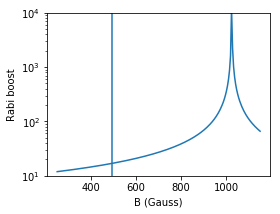

In [29]:
fres_at_boost = 1491.223e6#common.mw_freq

alpha_boost = calc_nuclear_rabi_hfs_boost(common.f_res_2_B_gauss(fres_at_boost), n_nuc=15)
# check from Sangtawesin (2016): 14-N, boost= 57x
#alpha_boost = calc_nuclear_rabi_hfs_boost(873, n_nuc=15)
kappa_omega_1h_15n = 1/alpha_boost * 267.522208/27.126

print(f"Nuclear Rabi boost/ 1-H/15-N ratio at f= {fres_at_boost/1e6:.2f} MHz: {alpha_boost:.3f} / {kappa_omega_1h_15n:.3f}")
logger.info("Nuclear Rabi boost/ 1-H/15-N ratio f= {fres_at_boost/1e6:.2f} MHz: {alpha_boost:.3f} / {kappa_omega_1h_15n:.3f")


x = np.linspace(250,1150,200)
plt.figure(figsize=(4,3))
plt.plot(x, abs(calc_nuclear_rabi_hfs_boost(x) ))
plt.axvline(common.f_res_2_B_gauss(fres_at_boost))
plt.yscale('log')
plt.ylim(10, 10e3)

plt.xlabel("B (Gauss)")
plt.ylabel("Rabi boost")
plt.show()

In [884]:
calc_nuclear_rabi_hfs_boost(500, n_nuc=14)

15.235282205455263

## Fit params from magnet scan: odmr

In [ ]:
### Load all odmr data from folder

In [815]:
import os.path

def get_odmr_idx(fname):
    if 'trans_index' in fname:
        fname = fname.split("trans_index")[1]
        return [int(s) for s in fname.split("_") if s.isdigit()]
    else:
        return None

def load_magnet_backmap(fname):
    with open(fname) as f:
        lines = f.readlines()
    
    backmap = []
    for l in lines:
        if "#related_intex" in l:
            data = (l.strip().split('{'))[1].split(":")
            try:
                flat_idx = int(l.strip().split('{')[0].split("_")[2].strip().strip(":"))
                #logger.debug(f"{l} -> {flat_idx}")
            except:
                raise ValueError(f"Can't parse {l}")
            x = float(data[1].split(',')[0])
            y = float(data[2].split(',')[0])
            z = data[3].split('}')[0].strip().strip("(,)")
            z = np.fromstring(z, dtype=int, sep=",")
            
            x_name = data[0].split(',')[0].replace("'","").replace('"', '').strip()
            y_name = data[1].split(',')[1].replace("'","").replace('"', '').strip()

            data_dict = {'x':x, 'y': y, 'x_name': x_name, 'y_name': y_name,
                         'flat_idx': flat_idx, 'trans_idx': z}
            backmap.append(data_dict)
    
    return backmap


def add_backmap_to_odmr(odmrs, backmap):
    for odmr in odmrs:
        for bm in backmap:
            if all(odmr['trans_idx'] == bm['trans_idx']):
                odmr['x'] = bm['x']
                odmr['y'] = bm['y']
                odmr['x_name'] = bm['x_name']
                odmr['y_name'] = bm['y_name']
                odmr['flat_idx'] = bm['flat_idx']
                
def do_arr_fit(odmrs, fit_method='lor_dip'):
    
     #fitter = fitlogic.make_fit_container('nb', '1d')
    fitter = pulsedmeasurementlogic.fc
    fitter.set_current_fit(fit_method)
    """
    x_fit, y_fit, result = fitter.do_fit(data[0], data[1])
    result = result.result_str_dict

    result['Position']['value']
    result['FWHM']['value']
    result['Contrast']['value']
    """
    flat_idx_max = 0
    flat_idx_min = np.inf
    xy_max = [-np.inf,-np.inf]
    xy_min = [np.inf,np.inf]
    arr_size = [0,0]

    for o in odmrs:
        try:
            data = o['data'][:,0], o['data'][:,1]

            x_fit, y_fit, result = fitter.do_fit(data[0], data[1])
            result = result.result_str_dict
            o['fit_res'] = result
            try:
                if o['flat_idx'] > flat_idx_max:
                    flat_idx_max = o['flat_idx']

                if o['x'] >= xy_max[0]:
                    xy_max[0] = o['x']
                    arr_size[0] = np.asarray(o['trans_idx'][0]) + 1
                    #logger.info(f"New x max: [{xy_min[0]}-{xy_max[0]}, {xy_min[1]}-{xy_max[1]}]")
                if o['y'] >= xy_max[1]:
                    xy_max[1] = o['y']
                    arr_size[1] = np.asarray(o['trans_idx'][1]) + 1
                    #logger.info(f"New y max: [{xy_min[0]}-{xy_max[0]}, {xy_min[1]}-{xy_max[1]}]")
                if o['x'] <= xy_min[0]:
                    xy_min[0] = o['x']
                    #logger.info(f"New x min: [{xy_min[0]}-{xy_max[0]}, {xy_min[1]}-{xy_max[1]}]")
                if o['y'] <= xy_min[1]:
                    xy_min[1] = o['y']
                    #logger.info(f"New y min: [{xy_min[0]}-{xy_max[0]}, {xy_min[1]}-{xy_max[1]}]")

                if o['flat_idx'] < flat_idx_max:
                    flat_idx_min = o['flat_idx']
                    xy_min = [o['x'], o['y']]
            except:
                xy_min, xy_max = None, None
                arr_size = None
                
        except:
            raise ValueError(f"Error in {o}")
            
    return odmrs, {'arr_size': arr_size, 'xy_min': xy_min, 'xy_max': xy_max}

def create_2d(odmrs, arr_size, fit_val="Position"):
    z = np.zeros(arr_size)
    for o in odmrs:
        ix, iy = o['trans_idx'][0], o['trans_idx'][1]
        val  = o['fit_res'][fit_val]['value']
        z[ix, iy] = val
        
    z = z.transpose()
    return z

def create_cts_vs_t(odmrs):
    t, cts = [], []
    for idx, o in enumerate(odmrs):
        timestamp = (Tk_file.load_pulsed_metadata(o['file'])['date'])
        if idx == 0:
            t_0 = timestamp
        t_s =  (timestamp-t_0).total_seconds()
        t.append(t_s)
        
        cts.append(np.average(o['data'][:,1]))
        
    return np.asarray(t), np.asarray(cts)

def calc_b_from_nv(f_odmr1, f_odmr2):
    try:
        nv_calculator_logic.set_field_params(2.87e9,0,0)
        fs, thetas = [], []
        for i, f1 in enumerate(f_odmr1):
            f, t = nv_calculator_logic.cal_alignment(f1/1e6, f_odmr2[i]/1e6)
            fs.append(f)
            thetas.append(t)
    except:
        logger.exception("Couldn't do nv_calculator: ")
    
    if len(fs) != len(thetas):
        raise ValueError("Input seems unaligned")
    
    return np.asarray(fs), np.asarray(thetas)

Load odmrs from magnet alignment

In [1018]:
#magnet_file = r"E:\Data\2021\07\20210726\Magnet\20210727-0907-57_f-f_0_magnet_alignment_data.dat"
#inpath = r"E:\Data\2021\07\20210726\ODMR\longODMRAlign_brightPenta_20210726.1_Bz=72.1mm"
#magnet_file = r"E:\Data\2021\09\20210920\Magnet\20210920-1218-54_Bz=-31mm_prelim_magnet_alignment_data.dat"
magnet_file = r"E:\Data\2021\12\20211214\Magnet\20211214-1222-39_Bz=6.33mm_vs_y_9_magnet_alignment_data.dat"
#magnet_file = r"E:\Data\2021\12\20211210\Magnet\20211213-1003-18_Bz=6.33mm_8_magnet_alignment_data.dat"
inpath = r"E:\Data\2021\09\20210920\ODMR\Bz=-31mm"
inpath = r"E:\Data\2021\12\20211214\ODMR\Bz=6.33mm_vs_y_4"
inpath = r"E:\Data\2021\12\20211214\ODMR\Bz=6.33mm_vs_y_9"
inpath = os.path.abspath(inpath)
magnet_file = os.path.abspath(magnet_file)

fnames = []
odmr_raw = []
fnames = [inpath + "\\" + f for f in os.listdir(inpath) if os.path.isfile(os.path.join(inpath, f)) and'range' in f and '.dat' in f]
magnet_backmap = None
magnet_backmap = load_magnet_backmap(magnet_file)


for f in fnames:
    odmr_raw.append({'file': f, 'trans_idx': get_odmr_idx(f), 'data':np.loadtxt(f)})

add_backmap_to_odmr(odmr_raw, magnet_backmap)

In [1021]:
odmr_raw[0]['file'], magnet_backmap[-1]

('E:\\Data\\2021\\12\\20211214\\ODMR\\Bz=6.33mm_vs_y_9\\20211214-1207-43_trans_index_0_0_ODMR_data_ch0_range0.dat', {'x': 0.004446, 'y': 0.0115868, 'x_name': 'x', 'y_name': 'y', 'flat_idx': 21, 'trans_idx': array([ 1, 10])})

In [1024]:
idx = 0
odmr_raw[idx]['trans_idx'], odmr_raw[idx]['file'], odmr_raw[idx]['x'], odmr_raw[idx]['y'], magnet_backmap is None

([0, 0], 'E:\\Data\\2021\\12\\20211214\\ODMR\\Bz=6.33mm_vs_y_9\\20211214-1207-43_trans_index_0_0_ODMR_data_ch0_range0.dat', 0.004444, 0.0065868, False)

In [1027]:
fnames[0]

'E:\\Data\\2021\\12\\20211214\\ODMR\\Bz=6.33mm_vs_y_9\\20211214-1207-43_trans_index_0_0_ODMR_data_ch0_range0.dat'

In [1030]:
single_odmr = r"E:\Data\2021\11\20211123\ODMR" + "\\" + "20211123-1143-36_penta_no_B_ODMR_data_ch0_range0.dat"
single_odmr = {'file':single_odmr, 'data': np.loadtxt(single_odmr)}
#single_odmr['file']
do_arr_fit([single_odmr], fit_method="lor_dip")[0][0]['fit_res']

OrderedDict([('Position', {'value': 1449346401.0006833, 'error': 20363.27729014348, 'unit': 's'}), ('Contrast', {'value': 3.534162042785945, 'error': 0.13176621207720673, 'unit': '%'}), ('FWHM', {'value': 1100627.5224758007, 'error': 72633.97386845014, 'unit': 's'}), ('chi_sqr', {'value': 17350774.709752783, 'unit': ''})])

### odmr overwiew, counts over time

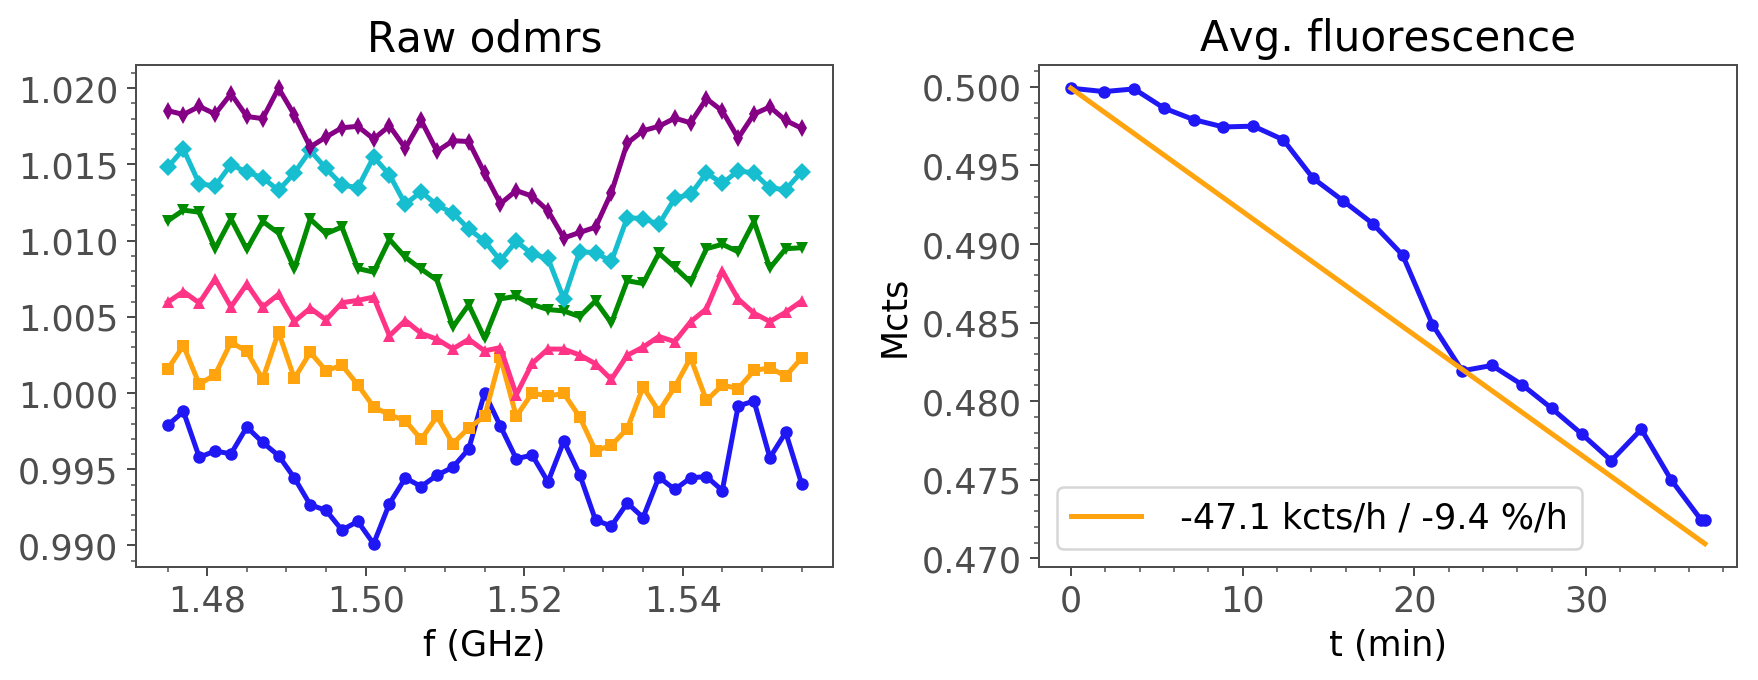

In [1033]:
y_offset = 0.001

plt.figure(figsize=(10,4))
plt.subplot(121)

for i in np.arange(0,len(odmr_raw),4):
    f = odmr_raw[i]['data'][:,0]
    y = odmr_raw[i]['data'][:,1]
    y_norm = y / np.max(y)
    
    y_final = i*y_offset + y_norm
    plt.plot(f/1e9, y_final)

    
plt.title("Raw odmrs")
plt.xlabel("f (GHz)")
#plt.xlim([1.3e9, 1.55e9])


plt.subplot(122)
t, cts = create_cts_vs_t(odmr_raw)
dfdt = np.diff(cts)/np.diff(t)

idx_slope_up_to = -1
avg_dfdt = np.average(dfdt[1:idx_slope_up_to])

plt.plot(t/60, cts/1e6)

plt.plot([t[0]/60, t[idx_slope_up_to]/60], [cts[0]/1e6,(cts[0]+t[idx_slope_up_to]*avg_dfdt)/1e6],
         label=f" {avg_dfdt/1e3*60*60:.1f} kcts/h / {100*avg_dfdt/cts[0]*3600:.1f} %/h", marker="")

plt.title("Avg. fluorescence")
plt.ylabel("Mcts")
plt.xlabel("t (min)")
plt.legend()
#cts
plt.tight_layout()
plt.show()

### Plot full odmr along one axis as 2d

In [812]:
flat_idx = 10
odmr_raw[flat_idx]['trans_idx'], odmr_raw[flat_idx]['x']*1e3, odmr_raw[flat_idx]['y']*1e3, odmr_raw[flat_idx]['y_name']

([1, 5], 4.446000000000001, 14823.4375, ' phi')

In [859]:
[o['y'] for o in odmr_raw if o['trans_idx'][axis] == idx_col]

[-85.1765625, -65.1765625, -45.1765625, -25.1765625, -5.1765625, 14.8234375]

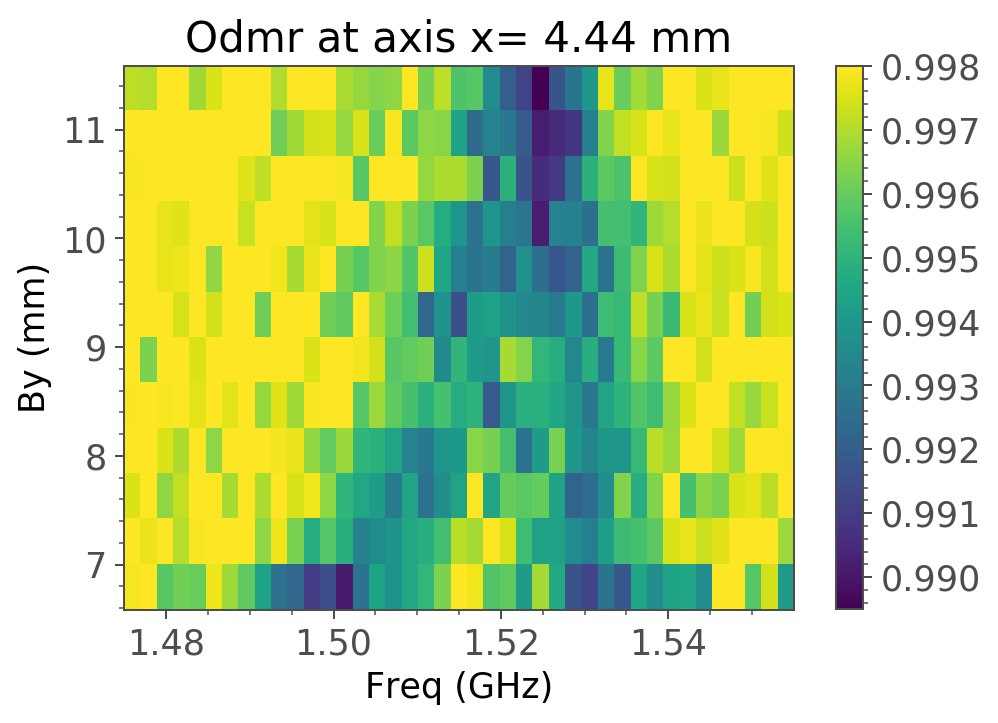

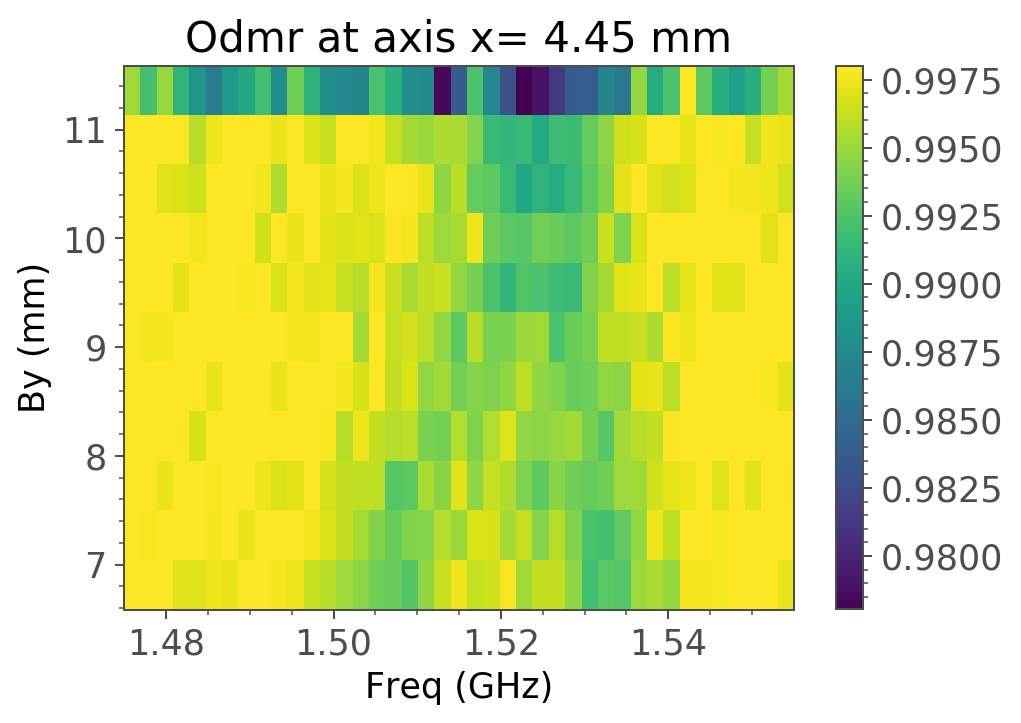

In [1036]:
idx_cols = [0, 2]
axis = 0   # -1 for both axes (flat)


for i in range(idx_cols[0], idx_cols[1]):
    idx_col = i
    
    plt.figure(figsize=(6,4))
    #odmrs[2]['trans_idx']
    if axis > -1:
        cts_rel = np.asarray([o['data'][:,1]/np.max(o['data'][:,1]) for o in odmr_raw if o['trans_idx'][axis] == idx_col])
        odmr_tmp = [o for o in odmr_raw if o['trans_idx'][axis] == idx_col]
        
        y_scale_fac = 1 if y_name == 'phi' else 1e3
        axis_low =  y_scale_fac*np.min(np.asarray([o['y'] if axis == 0 else o['x']  for o in odmr_tmp]))
        axis_high = y_scale_fac*np.max(np.asarray([o['y'] if axis == 0 else o['x']  for o in odmr_tmp]))
        
        plt.title(f"Odmr at axis {'x' if axis==0 else 'y'}= {odmr_tmp[0]['x']*1e3 if axis==0 else odmr_tmp[0]['y']*1e3:.2f} mm")
        y_name = odmr_tmp[0]['y_name'] if axis == 0 else odmr_tmp[0]['x_name']
        y_unit = 'deg' if y_name == 'phi' else 'mm'

        plt.ylabel(f"B{y_name} ({y_unit})")
    else:
        cts_rel =  np.asarray([o['data'][:,1]/np.max(o['data'][:,1]) for o in odmr_raw])
        axis_low = 0
        axis_high = len(odmr_raw)
        
        plt.ylabel("B axis idx")

    
    extent = [odmr_raw[0]['data'][0,0]/1e9, odmr_raw[0]['data'][-1,0]/1e9, axis_low, axis_high]

    plt.imshow(cts_rel, extent=extent, aspect='auto', origin='lower',
              #vmin=0.993,
              vmax=0.998
              )
        
    plt.xlabel("Freq (GHz)")

    plt.colorbar()
    plt.show()


### Fit 1x Lorentz for whole series

In [98]:
try:
    odmrs, arr_dict = do_arr_fit(odmr_raw, fit_method="lor_dip")
except:
    logger.exception("Fit failed: ")
    
z_fres = create_2d(odmrs, arr_dict['arr_size'], fit_val="Position")
z_fwhm = create_2d(odmrs, arr_dict['arr_size'], fit_val="FWHM")
z_contr = create_2d(odmrs, arr_dict['arr_size'], fit_val="Contrast")

arr_dict

{'arr_size': [17, 17], 'xy_min': [0.0010462, 0.0030889], 'xy_max': [0.0106462, 0.0126889]}

In [50]:
arr_dict

{'arr_size': [9, 9], 'xy_min': [0.0035462, 0.0055889], 'xy_max': [0.0083462, 0.0103889]}

In [54]:
idx = 0
1e3*odmr_raw[idx]['x'], 1e3*odmr_raw[idx]['y'], odmr_raw[idx]['fit_res']

(3.5462, 5.5889, OrderedDict([('Position', {'value': 1546625016.6164353, 'error': 715541.9436840245, 'unit': 's'}), ('Contrast', {'value': 0.4027921258575711, 'error': 0.08583861110331333, 'unit': '%'}), ('FWHM', {'value': 6208961.89440428, 'error': 2077745.3931468907, 'unit': 's'}), ('chi_sqr', {'value': 17634660.070811395, 'unit': ''})]))

0

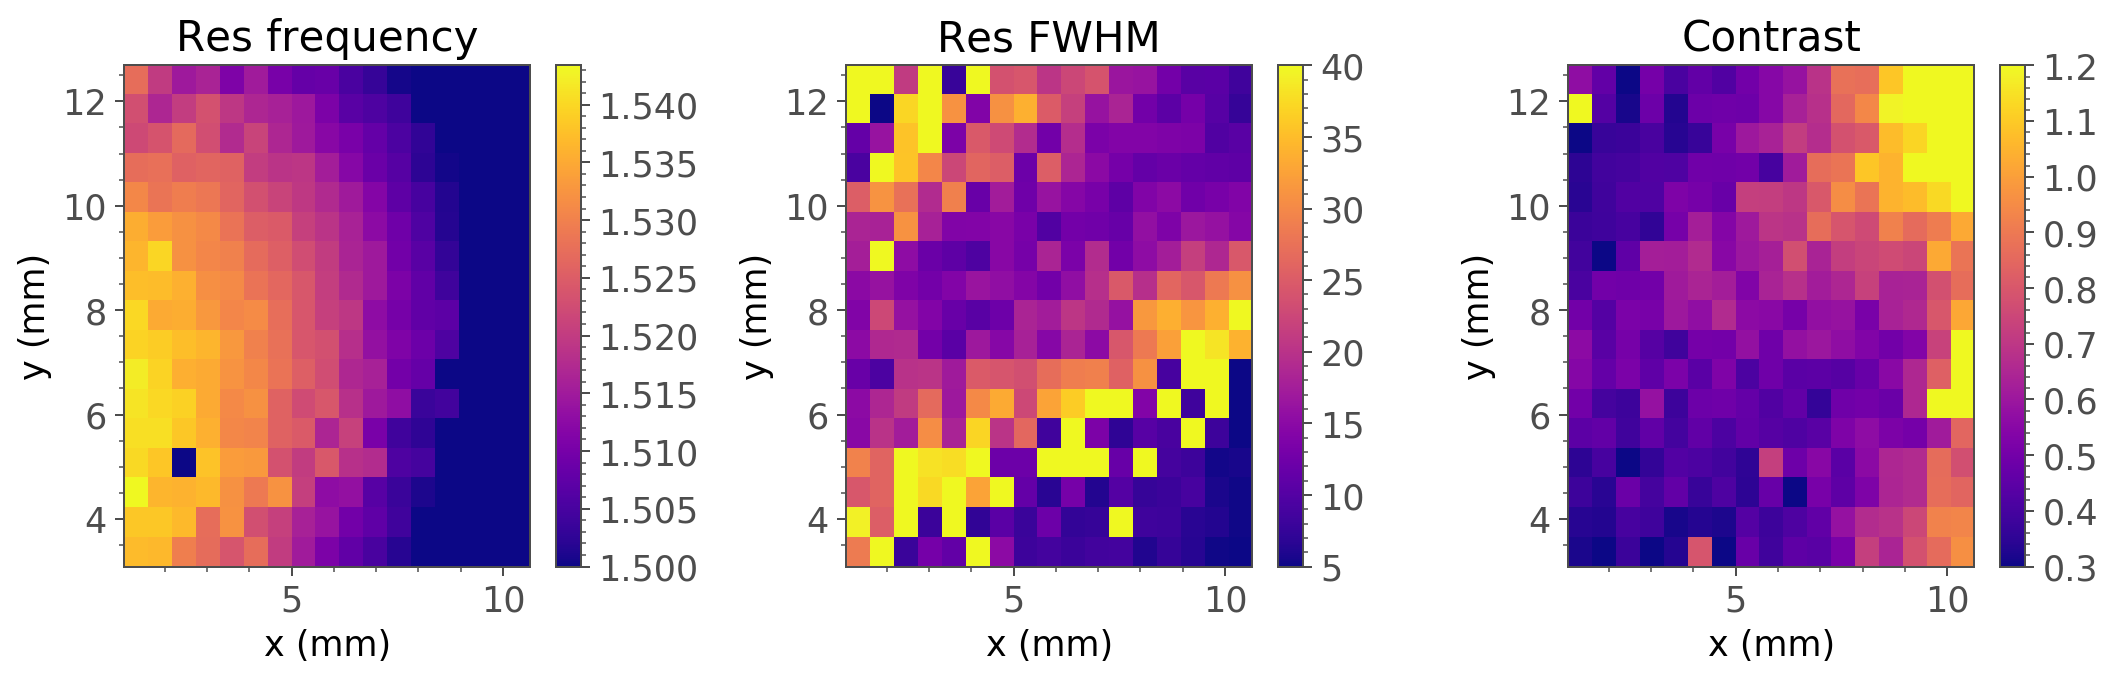

In [142]:
scale_xy = [1e3,1e3]

plt.figure(figsize=(12,4))
plt.subplot(131)

plt.imshow(z_fres/1e9, origin='lower',
           extent=(arr_dict['xy_min'][0]*scale_xy[0], arr_dict['xy_max'][0]*scale_xy[0],
                   arr_dict['xy_min'][1]*scale_xy[1], arr_dict['xy_max'][1]*scale_xy[1]),  # checked to match magnet gui
           vmin=1.50,
           #vmax=1.475,
           cmap='plasma',
           aspect='auto')
plt.title("Res frequency")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.colorbar()

plt.subplot(132)

plt.imshow(z_fwhm/1e6, origin='lower',
           extent=(arr_dict['xy_min'][0]*scale_xy[0], arr_dict['xy_max'][0]*scale_xy[0],
                   arr_dict['xy_min'][1]*scale_xy[1], arr_dict['xy_max'][1]*scale_xy[1]),  # checked to match magnet gui
           vmax=40e6/1e6,
           vmin=5e6/1e6,
           cmap='plasma',
           aspect='auto')
plt.title("Res FWHM")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.colorbar()

plt.subplot(133)

plt.imshow(z_contr, origin='lower',
           extent=(arr_dict['xy_min'][0]*scale_xy[0], arr_dict['xy_max'][0]*scale_xy[0],
                   arr_dict['xy_min'][1]*scale_xy[1], arr_dict['xy_max'][1]*scale_xy[1]),  # checked to match magnet gui
           vmax=1.2,
           vmin=0.3,
           cmap='plasma',
           aspect='auto')
plt.title("Contrast")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.colorbar()

plt.tight_layout()
plt.show()
0

In [68]:
[(f"({o['trans_idx']},({1e3*o['x']:.1f},{1e3*o['y']:.1f} mm) \
=> contr={o['fit_res']['Contrast']['value']:.3f}, fwhm={o['fit_res']['FWHM']['value']/1e6:.0f}") for o in odmrs]

### Fit 2x Lorentz for whole series

Note: Since the pusledmeasurement fit container is used, you can use the pulsed gui to set boundaries for the fit!

In [1054]:
odmrs, arr_dict = do_arr_fit(odmr_raw, fit_method="lor_dip_2x")

z_fres0 = create_2d(odmrs, arr_dict['arr_size'], fit_val="Position 0")
z_fres1 = create_2d(odmrs, arr_dict['arr_size'], fit_val="Position 1")
z_fwhm0 = create_2d(odmrs, arr_dict['arr_size'], fit_val="FWHM 0")
z_fwhm1 = create_2d(odmrs, arr_dict['arr_size'], fit_val="FWHM 1")
z_contr0 = create_2d(odmrs, arr_dict['arr_size'], fit_val="Contrast 0")
z_contr1 = create_2d(odmrs, arr_dict['arr_size'], fit_val="Contrast 1")

z_fres = abs(z_fres0-z_fres1)
z_fwhm = abs(z_fwhm0-z_fwhm1)/2
z_contr = z_contr0/z_contr1

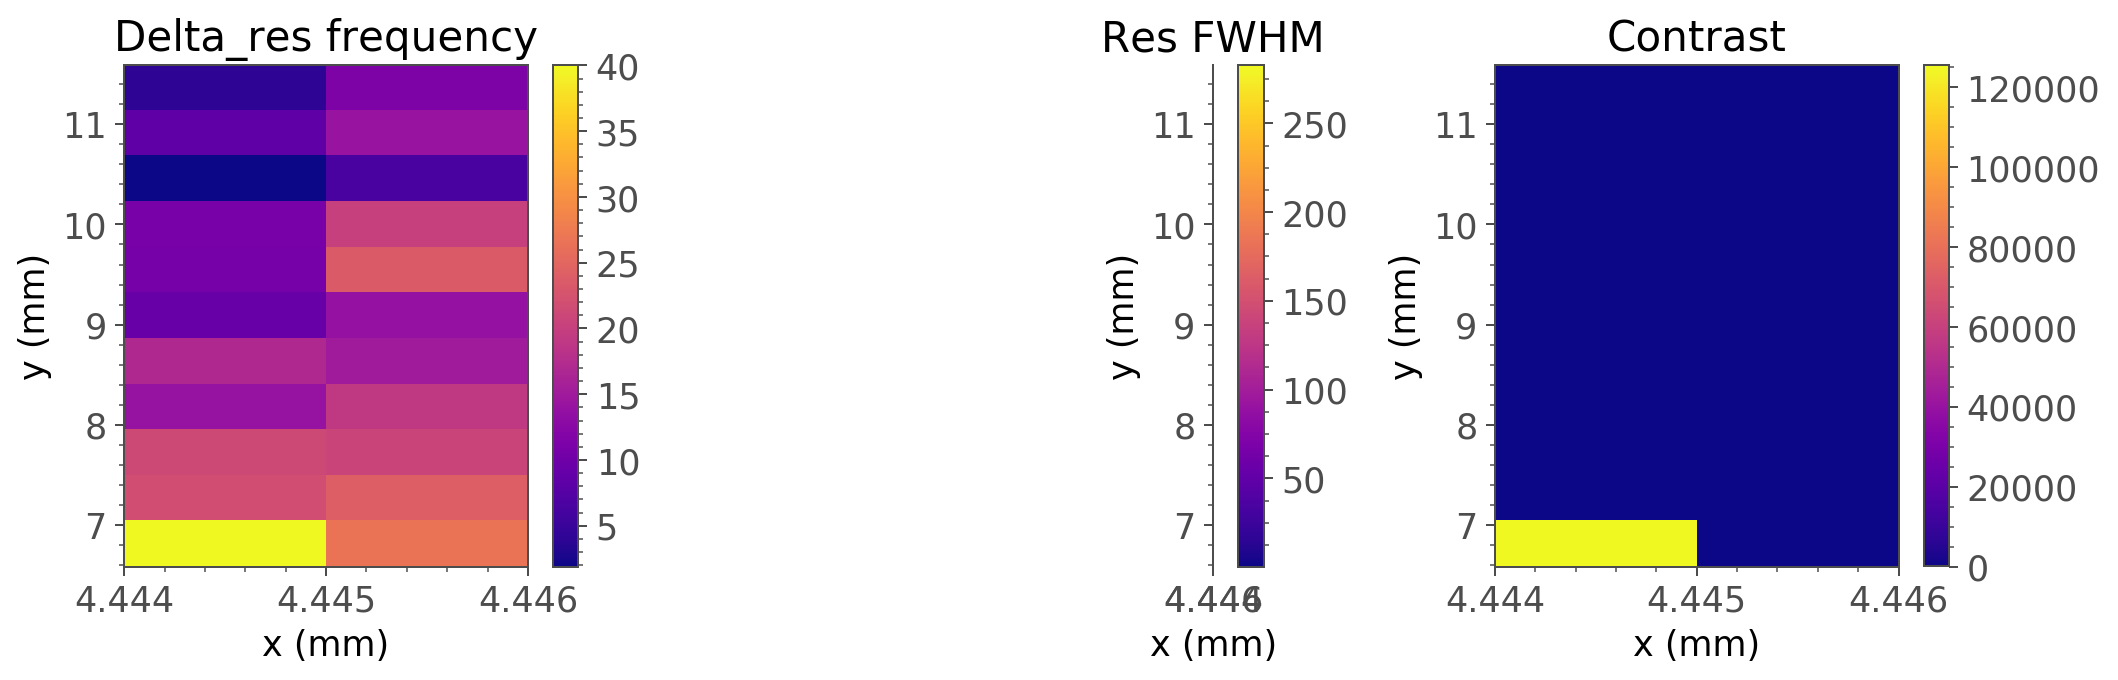

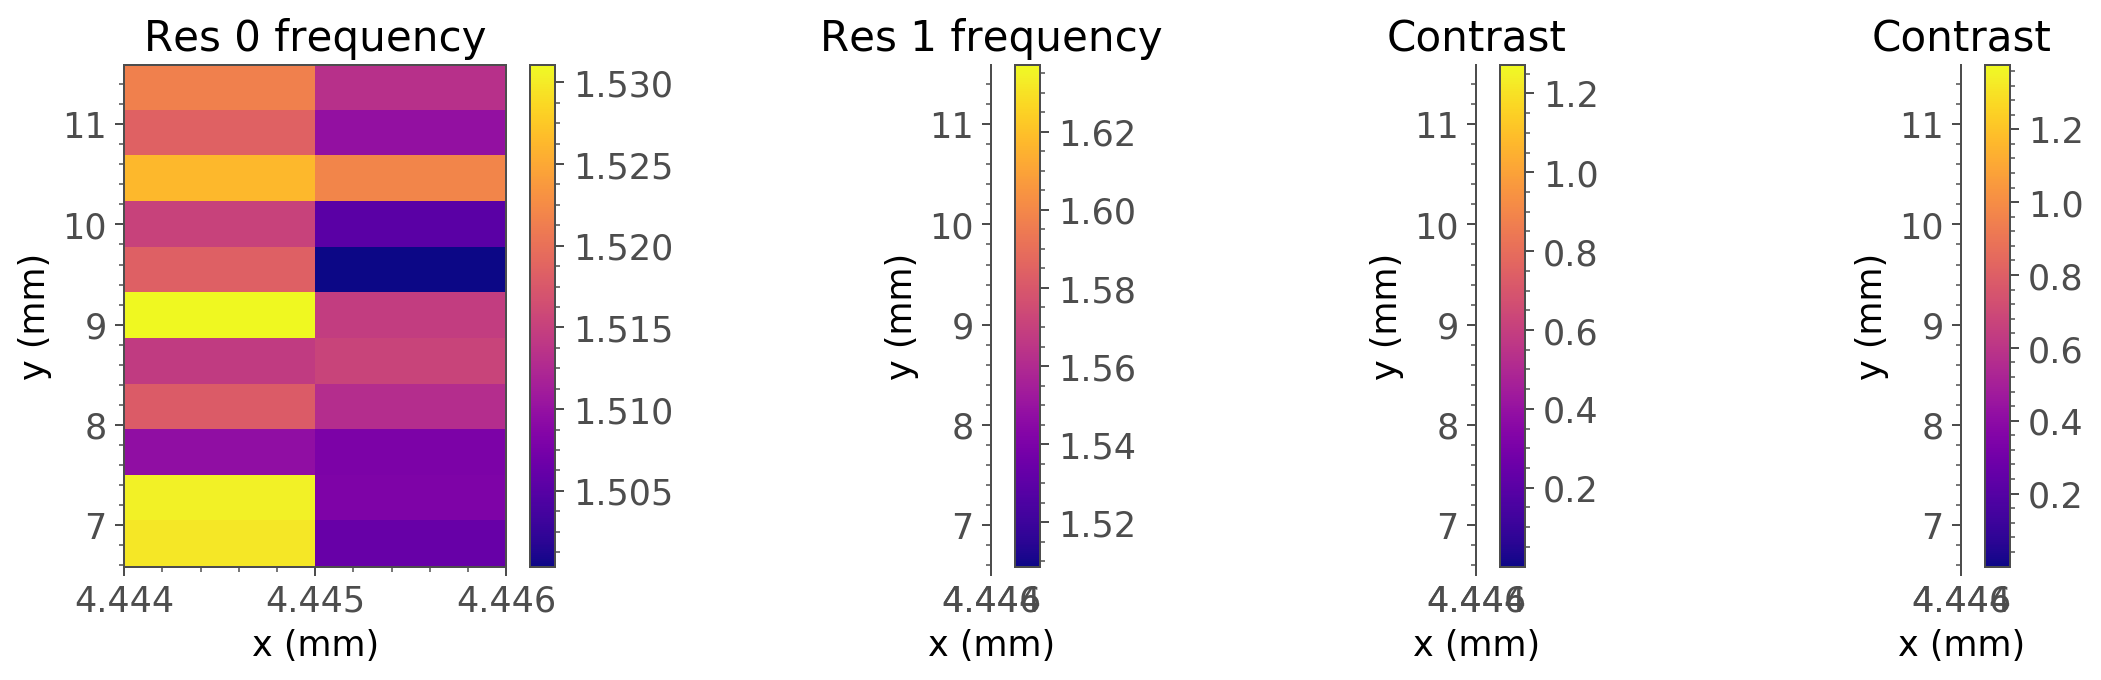

In [1057]:
plt.figure(figsize=(12,4))
plt.subplot(131)

plt.imshow(z_fres/1e6, origin='lower',
           extent=(arr_dict['xy_min'][0]*1e3, arr_dict['xy_max'][0]*1e3, arr_dict['xy_min'][1]*1e3, arr_dict['xy_max'][1]*1e3),  # checked to match magnet gui
           #vmin=50,
           vmax=40,
           cmap='plasma', aspect='auto')
plt.title("Delta_res frequency")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.colorbar()

plt.subplot(132)

plt.imshow(z_fwhm/1e6, origin='lower',
           extent=(arr_dict['xy_min'][0]*1e3, arr_dict['xy_max'][0]*1e3, arr_dict['xy_min'][1]*1e3, arr_dict['xy_max'][1]*1e3),  # checked to match magnet gui
           #vmax=30e6/1e6, vmin=0,
           cmap='plasma')
plt.title("Res FWHM")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.colorbar()

plt.subplot(133)

plt.imshow(z_contr, origin='lower',
           extent=(arr_dict['xy_min'][0]*1e3, arr_dict['xy_max'][0]*1e3, arr_dict['xy_min'][1]*1e3, arr_dict['xy_max'][1]*1e3),  # checked to match magnet gui
           #vmax=2,
           cmap='plasma', aspect='auto')
plt.title("Contrast")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.colorbar()

plt.tight_layout()
plt.show()

### Detailed plot

plt.figure(figsize=(12,4))
plt.subplot(141)

plt.imshow(z_fres0/1e9, origin='lower',
           extent=(arr_dict['xy_min'][0]*1e3, arr_dict['xy_max'][0]*1e3, arr_dict['xy_min'][1]*1e3, arr_dict['xy_max'][1]*1e3),  # checked to match magnet gui
           #vmin=1.46,
           #vmax=1.55,
           cmap='plasma', aspect='auto')
plt.title("Res 0 frequency")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.colorbar()

plt.subplot(142)

plt.imshow(z_fres1/1e9, origin='lower',
           extent=(arr_dict['xy_min'][0]*1e3, arr_dict['xy_max'][0]*1e3, arr_dict['xy_min'][1]*1e3, arr_dict['xy_max'][1]*1e3),  # checked to match magnet gui
           #vmax=1.56,
           #vmin=1.50,
           cmap='plasma')
plt.title("Res 1 frequency")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.colorbar()

plt.subplot(143)

plt.imshow(z_contr0, origin='lower',
           extent=(arr_dict['xy_min'][0]*1e3, arr_dict['xy_max'][0]*1e3, arr_dict['xy_min'][1]*1e3, arr_dict['xy_max'][1]*1e3),  # checked to match magnet gui
           #vmax=1.0,
           cmap='plasma')
plt.title("Contrast")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.colorbar()


plt.subplot(144)

plt.imshow(z_contr1, origin='lower',
           extent=(arr_dict['xy_min'][0]*1e3, arr_dict['xy_max'][0]*1e3, arr_dict['xy_min'][1]*1e3, arr_dict['xy_max'][1]*1e3),  # checked to match magnet gui
           #vmax=1.0,
           cmap='plasma')
plt.title("Contrast")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.colorbar()
plt.tight_layout()
plt.show()



In [1066]:
idx_x, idx_y = 0, 5
[(o['trans_idx'], 1e3*o['x'], 1e3*o['y']) for o in odmr_raw if o['trans_idx'] == [idx_x, idx_y]]

[([0, 5], 4.444, 9.0868)]

In [1126]:
# splitting 
z_fres[idx_y, idx_x]/1e6

13.94018346119976

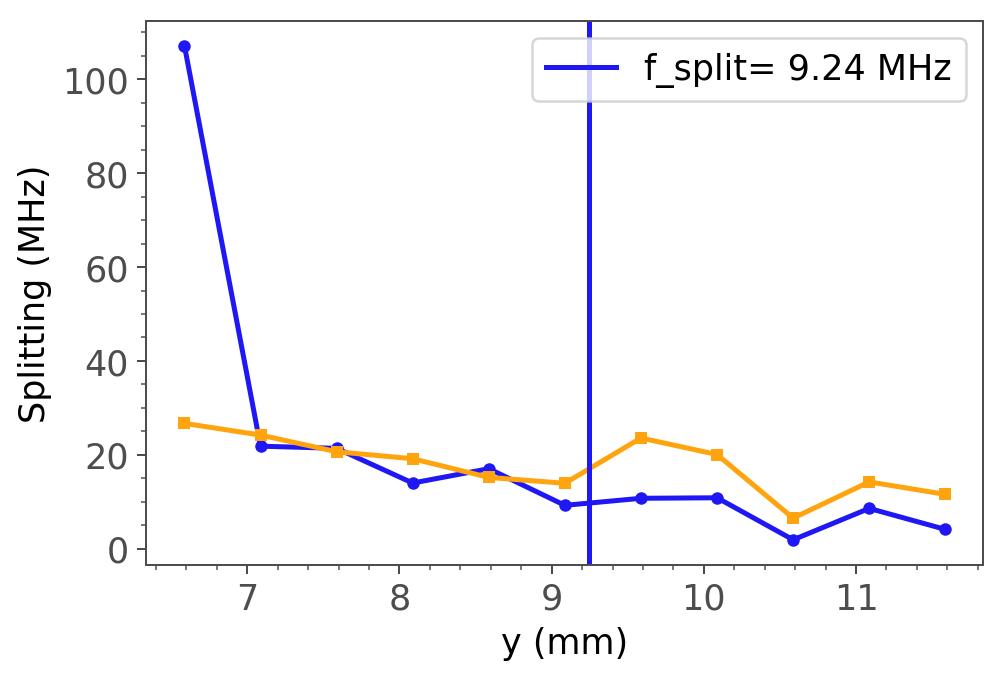

In [1147]:
# splitting along axis
idx_x = 0
idx_y = 5

plt.figure(figsize=(6,4))

f_split = np.asarray(z_fres[:, 0])
x = np.linspace(arr_dict['xy_min'][1], arr_dict['xy_max'][1], len(f_split))
plt.plot(x*1e3, f_split/1e6)
f_split = np.asarray(z_fres[:, 1])
plt.plot(x*1e3, f_split/1e6)

plt.axvline(z_fres[idx_y, idx_x]/1e6, label=f"f_split= {z_fres[idx_y, idx_x]/1e6:.2f} MHz")

plt.ylabel("Splitting (MHz)")
plt.xlabel("y (mm)")
plt.legend()
plt.show()
        

In [1099]:
arr_dict

{'arr_size': [2, 11], 'xy_min': [0.004444, 0.0065868], 'xy_max': [0.004446, 0.0115868]}

In [1063]:
[(o['trans_idx'], 1e3*o['x'], 1e3*o['y']) for o in odmr_raw][10:20]

[([1, 4], 4.446000000000001, 8.5868), ([1, 5], 4.446000000000001, 9.0868), ([0, 5], 4.444, 9.0868), ([0, 6], 4.444, 9.5868), ([1, 6], 4.446000000000001, 9.5868), ([1, 7], 4.446000000000001, 10.0868), ([0, 7], 4.444, 10.0868), ([0, 8], 4.444, 10.5868), ([1, 8], 4.446000000000001, 10.5868), ([1, 9], 4.446000000000001, 11.0868)]

In [53]:
0

0

### Plot |B|, theta for NV odmr with 2 lines

In [77]:
nv_calculator_logic.cal_alignment(z_fres[0]/1e6, z_fres[1]/1e6)

In [128]:
b_abs, theta_degree = calc_b_from_nv(z_fres0.flatten(), z_fres1.flatten())
b_abs = b_abs.reshape(z_fres0.shape)
theta_degree = theta_degree.reshape(z_fres0.shape)

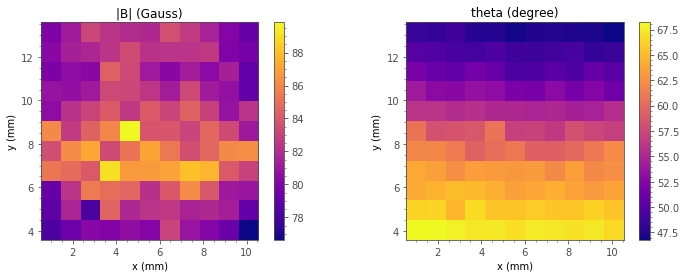

In [149]:
plt.figure(figsize=(12,4))
plt.subplot(121)

plt.imshow(b_abs, origin='lower',
           extent=(arr_dict['xy_min'][0]*1e3, arr_dict['xy_max'][0]*1e3, arr_dict['xy_min'][1]*1e3, arr_dict['xy_max'][1]*1e3),  # checked to match magnet gui
           #vmin=50,
           #vmax=50,
           cmap='plasma')
plt.title("|B| (Gauss)")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.colorbar()

plt.subplot(122)

plt.imshow(theta_degree, origin='lower',
           extent=(arr_dict['xy_min'][0]*1e3, arr_dict['xy_max'][0]*1e3, arr_dict['xy_min'][1]*1e3, arr_dict['xy_max'][1]*1e3),  # checked to match magnet gui
           #vmax=30e6/1e6, vmin=0,
           cmap='plasma')
plt.title("theta (degree)")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.colorbar()

plt.show()


In [125]:
b_abs.shape

(11, 11)

### Extract fit data from running magnet logic

In [ ]:
ml = magnet_logic
mgui = magnetgui

width = np.zeros(ml._2D_data_matrix.shape)
contr = np.zeros(width.shape)
for ix,iy in np.ndindex(ml._2D_add_data_matrix.shape):
    width[ix, iy] = ml._2D_add_data_matrix[ix,iy]['Fit result']['fwhm'].value
    contr[ix, iy] = ml._2D_add_data_matrix[ix,iy]['Fit result']['Contrast'].value
#ml._2D_data_matrix = width
#mgui._update_2d_graph_data()

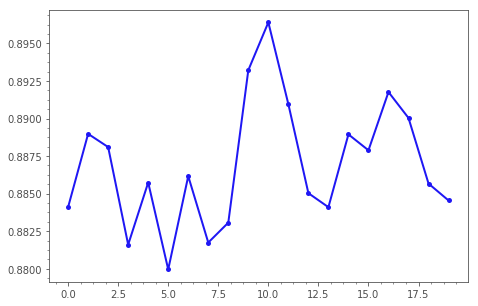

In [19]:
plt.plot(pulsedmeasurementlogic.signal_data[1])
plt.show()

#  Preperation mes

## Pulsed ODMR

In [65]:
p_scale_manual = 1

"""
common.rabi_shaped['shaped_on'] = False
if common.rabi_shaped['shaped_on']:
    logger.warning("pODMR does not support shaped pulses yet. Using potentially wrong calibrated pi pulse.")
"""

if p_scale_manual != 1:
    logger.warning("Manually reduce AWG ampl / AMP gain by a factor of {} / {}!".format(2*p_scale_manual, np.sqrt(2*p_scale_manual)))
    #qmeas = setup_podmr_params(f_res=common.mw_freq, p_scale=50, p_scale_onlyperiod=p_scale_manual, f_step=20e3) # range ~ 1 MHz
#qmeas = setup_podmr_params(f_res=800e6, p_scale=1, f_step=4e6, n_f=100)
#qmeas = setup_podmr_params(f_res=3e9, p_scale=1, f_step=3e6, n_f=150)     # wide band, ~ 150 MHz

#qmeas = setup_podmr_params(f_res=common.mw_freq, p_scale=1, f_step=3e6, n_f=150)
#qmeas = setup_podmr_params(f_res=common.mw_freq, p_scale=1, f_step=2000e3, n_f=200)     # wide band
#qmeas = setup_podmr_params(f_res=2.88e9, p_scale=1, f_step=3000e3, n_f=250)
#qmeas = setup_podmr_params(f_res=common.mw_freq, p_scale=1, f_step=3000e3, n_f=100)     
qmeas = setup_podmr_params(f_res=common.mw_freq, p_scale=1, f_step=1000e3, n_f=100)
#qmeas = setup_podmr_params(f_res=common.mw_freq, p_scale=1, f_step=500e3, n_f=75)

#qmeas = setup_podmr_params(f_res=common.mw_freq, p_scale=5, f_step=1000e3, n_f=150)     # wide band, ~ 150 MHz
#qmeas = setup_podmr_params(f_res=common.mw_freq, p_scale=5, f_step=500e3, n_f=75)
#qmeas = setup_podmr_params(f_res=common.mw_freq, p_scale=60, f_step=100e3, n_f=100)
#qmeas = setup_podmr_params(f_res=common.mw_freq, p_scale=60, f_step=50e3, n_f=50)
#qmeas = setup_podmr_params(f_res=common.mw_freq, p_scale=10, f_step=500e3, n_f=75) # range ~ 5 MHz
#qmeas = setup_podmr_params(f_res=common.mw_freq, p_scale=10, f_step=50e3, n_f=75) # range ~ 5 MHz
#qmeas = setup_podmr_params(f_res=2.78e9, p_scale=20, f_step=200e3, n_f=100)#, t_pi_manual=8e-6)
#qmeas = setup_podmr_params(f_res=common.mw_freq, p_scale=30, f_step=100e3, n_f=120)

#qmeas = setup_podmr_params(f_res=common.mw_freq, p_scale=40, f_step=100e3, n_f=100) # range ~ 3*6 MHz
#qmeas = setup_podmr_params(f_res=common.mw_freq, p_scale=60, f_step=50e3, n_f=100) # range ~ 1 MHz, 
#qmeas = setup_podmr_params(f_res=common.mw_freq, p_scale=60, f_step=100e3, n_f=150) # range ~ 1 MHz, 

# for extremely good T2* / Rabi drive efficiency
#qmeas = setup_podmr_params(f_res=common.mw_freq, p_scale=500, f_step=20e3, n_f=150) # range ~ 1 MHz, 
#qmeas = setup_podmr_params(f_res=common.mw_freq, p_scale=250, f_step=20e3, n_f=150) # range ~ 1 MHz, 

#qmeas = setup_podmr_params(f_res=common.mw_freq, p_scale=1500, f_step=20e3, n_f=250)

uglobals.abort.clear()
run_pdomr(qmeas)



In [161]:
qmeas

OrderedDict([('name', 'pulsedodmr_shaped'), ('experiment', 'pulsedodmr_shaped'), ('rabi_period', 9.125e-08), ('freq_step', 3000000.0), ('num_of_points', 100), ('freq_start', 2935100000.0), ('microwave_amplitude', 0.25), ('measurement_time', 1500), ('optimize_time', None), ('fit_experiment', 'lor_dip'), ('env_type', <EnvelopeMethods.parabola: 'SinEnvelopeParabolaN'>), ('order_P', 1)])

### pODMR + pi RF

In [170]:
uglobals.abort.clear()
qmeas = setup_podmr_rfpi_params(f_res=common.mw_freq, p_scale=60, f_step=100e3, n_f=20,
                            f_rf=366.82e3, t_pi_rf=4.554e-6, ampl_rf=0.125, alternating_no_rf=True)
run_generic(qmeas)

In [179]:
np.linspace(0.5, 1.5, 9)[::]

array([0.5  , 0.625, 0.75 , 0.875, 1.   , 1.125, 1.25 , 1.375, 1.5  ])

### t_pi series

In [ ]:
uglobals.abort.clear()
tscales = np.linspace(0.2, 1.8, 9)[::]
t_start = 4.554e-6

for i, t in enumerate(tscales):
    if uglobals.abort.is_set():
        break
    try:
        t_phys = t_start*t
        qmeas = setup_podmr_rfpi_params(f_res=common.mw_freq, p_scale=60, f_step=100e3, n_f=20,
                                    f_rf=366.82e3, t_pi_rf=4.554e-6, ampl_rf=0.125, alternating_no_rf=True)
        #qmeas = setup_rabi_params(tau_step=250e-9, p_scale=10)
        qmeas['measurement_time'] = 10*60
        savetag = f"podmr_rfpi_idx={i}_tpi={1e6*t_phys:.2f}uV"
        run_generic(qmeas, save_tag=savetag)
    except Exception as e:
        stack_trace = traceback.format_exc()
        logger.warning("auto run {} failed: {}.\n{}".format(i, str(e), stack_trace))

logger.info("Autopilot has landed.")
            

## Rabi

In [95]:
uglobals.abort.clear()
#uglobals.abort.set()

#qmeas = setup_rabi_params(tau_step=500*1e-9, p_scale=250, alternating=False, n_tau=200)   # 10e-9
#qmeas = setup_rabi_params(tau_step=25*1e-9, p_scale=25, alternating=False)   # 10e-9
#qmeas = setup_rabi_params(tau_step=1e-9, p_scale=1, alternating=False)   # 10e-9

#qmeas = setup_rabi_params(tau_step=common.rabi_period/20, n_tau=40, alternating=True) 
qmeas = setup_rabi_params(tau_step=common.rabi_period/20, n_tau=75, alternating=False) 

"""
leave_out_idx = np.asarray([np.arange(20,100), np.arange(120,200), np.arange(220,300)]).flatten() 
qmeas = setup_rabi_params(tau_step=2.5e-9*2, n_tau=320, p_scale=2, leave_out_tau_idx=np.array2string(leave_out_idx,
                                                                                                      separator=',',
                                                                                                      max_line_width=9999))   # 10e-9
"""

run_rabi(qmeas)


In [137]:
common.rabi_period

1.83e-08

### power series

In [263]:
uglobals.abort.clear()
pscales = np.linspace(1, 0.05, 8)[::-1]
p_start = common.mw_amp

for i, p in enumerate(pscales):
    if uglobals.abort.is_set():
        break
    try:
        p_phys = p_start*p
        qmeas = setup_rabi_params(tau_step=common.rabi_period/20*common.mw_amp/p_phys,
                                  n_tau=75, p_scale=common.mw_amp/p_phys)   # 10e-9
        #qmeas = setup_rabi_params(tau_step=250e-9, p_scale=10)
        qmeas['measurement_time'] = 15
        savetag = f"rabi_idx={i}_ampl={1e3*p_phys:.2f}mV"
        run_generic(qmeas, save_tag=savetag)
    except Exception as e:
        stack_trace = traceback.format_exc()
        logger.warning("auto run {} failed: {}.\n{}".format(i, str(e), stack_trace))

logger.info("Autopilot has landed.")
            

In [565]:
common.rabi_period

1.275e-08

## Nuclear (15-N)

### nuclear pODMR

In [233]:
t_nuc_rabi = 15.8e-6
rf_ampl = 40e-3

qmeas = setup_nuc_podmr_params(f_start=2.6e6,  f_step=10e3, n_f=50, t_nuc_rabi=t_nuc_rabi, rf_ampl=rf_ampl)

uglobals.abort.clear()
run_generic(qmeas)

In [161]:
qmeas

OrderedDict([('name', 'nuc_pulsedodmr'), ('experiment', 'nuc_pulsedodmr'), ('microwave_frequency', 1490708000.0), ('rabi_period', 3.762e-08), ('freq_start', 2700000.0), ('freq_step', 5000.0), ('num_of_points', 50), ('rf_chnl', 'a_ch2'), ('rf_ampl', 0.05), ('t_nuc_rabi', 5e-05), ('nv_pi_init', True), ('alternating_no_rf', True), ('measurement_time', 1500), ('optimize_time', None), ('fit_experiment', 'lor_dip'), ('savetag', 'nuc_pulsedodmr'), ('gated', False), ('sequence_mode', False), ('ctr_single_sweeps', False), ('ctr_n_sweeps', 0), ('ctr_n_cycles', 0), ('freq_optimize_time', None), ('analysis_interval', None)])

### nuclear Rabi

In [236]:
f_nuc_rabi = 2814e3

qmeas = setup_nuc_rabi_params(tau_step=1e-6, rf_freq=2.81e6, rf_ampl=rf_ampl, n_tau=50)
savetag = f"nucRabi_{round(qmeas['rf_ampl']*1000)}mV"

uglobals.abort.clear()


In [107]:
#run_generic(qmeas, save_tag=savetag)

'nucRabi_40mV'

### power series

In [239]:
uglobals.abort.clear()
pscales = np.linspace(1, 0.1, 8)[::]
p_start = 60e-3 #common.mw_amp

for i, p in enumerate(pscales):
    if uglobals.abort.is_set():
        break
    try:
        p_phys = p_start*p
        qmeas = setup_nuc_rabi_params(tau_step=t_nuc_rabi/20*rf_ampl/p_phys,
                                     rf_freq=f_nuc_rabi, rf_ampl=p_phys, n_tau=50)   # 10e-9
        #qmeas = setup_rabi_params(tau_step=250e-9, p_scale=10)
        qmeas['measurement_time'] = 40
        savetag = f"nucRabi_idx={i}_ampl={1e3*p_phys:.2f}mV"
        run_generic(qmeas, save_tag=savetag)
    except Exception as e:
        stack_trace = traceback.format_exc()
        logger.warning("auto run {} failed: {}.\n{}".format(i, str(e), stack_trace))

logger.info("Autopilot has landed.")
            

## Ramsey


In [146]:
tau_start = 0.05e-6
n_sweeps = 0#1e3

uglobals.abort.clear()
qmeas = setup_ramsey_params(tau_start, n_tau=50, tau_step=5e-9, alternating=True)
#qmeas = setup_ramsey_params(tau_start, n_tau=70, tau_step=25e-9, alternating=True, read_phases='-90, +90', red_readout=False)
#qmeas = setup_ramsey_params(tau_start, n_tau=50, tau_step=50e-9, alternating=True, read_phases='-90, +90', red_readout=False)

#qmeas = setup_ramsey_params(tau_start, n_tau=50, tau_step=20e-9, alternating=True, read_phases='0, 180', red_readout=False)

#qmeas = setup_ramsey_params(tau_start, n_tau=100, tau_step=100e-9)     
#qmeas = setup_ramsey_params(tau_start, n_tau=120, tau_step=20e-9, alternating=True)
#qmeas = setup_ramsey_params(tau_start, n_tau=200, tau_step=250e-9)      # 75ns: res like mfl
#qmeas = setup_ramsey_params(tau_start, n_tau=400, tau_step=50e-9)     # high res    
#qmeas = setup_ramsey_params(tau_start, n_tau=400, tau_step=100e-9)     # high res  

# debug
#qmeas = setup_ramsey_params(300e-9, n_tau=1, tau_step=20e-9, alternating=True, read_phases='-90, +90', red_readout=False)


x, z = run_ramsey(qmeas, n_sweeps_stop=n_sweeps)
z_binary = 0 #majority_vote(z[0], z_thres=common.mfl_z_thres)

logger.info("Ramsey with offset {} MHz, {} sweeps: {} -> {}".format(common.mw_ramsey_offset/1e6, n_sweeps, z, z_binary))


## Hahn


In [440]:
uglobals.abort.clear()

he_tau_step = 0.250e-6
he_n_tau = 25
#he_n_tau = 50

logger.info(f"Tau max= {he_tau_step*he_n_tau}")

qmeas = setup_hahn_params(tau_start=100e-9, n_tau=he_n_tau, tau_step=he_tau_step, alternating=True)
#qmeas = setup_hahn_params(tau_start=14e-6, n_tau=he_n_tau, tau_step=he_tau_step, alternating=True)
run_generic(qmeas)

## XY 8 

tau sweep

In [383]:
#tau_start = 0.2e-6
tau_start = 800e-9
tau_start = 10e-9

uglobals.abort.clear()
# narrow resonance NV M17
qmeas = setup_xy8_tausweep_params(tau_start, n_tau=120, tau_step=10e-9, xy8_order=8, alternating=True)


#qmeas = setup_xy8_tausweep_params(tau_start, n_tau=10, tau_step=25e-9, xy8_order=800, alternating=True)


# larger sweeps
#qmeas = setup_xy8_tausweep_params(tau_start, n_tau=75, tau_step=10e-9, xy8_order=4, alternating=True) 
#qmeas = setup_xy8_tausweep_params(tau_start, n_tau=75, tau_step=3e-9, xy8_order=4, alternating=True) 
#qmeas = setup_xy8_tausweep_params(tau_start, n_tau=250, tau_step=20e-9, xy8_order=4, alternating=True)
#qmeas = setup_xy8_tausweep_params(tau_start, n_tau=75, tau_step=5e-9, xy8_order=8, alternating=True) 

qmeas = setup_xy8_tausweep_params(tau_start, n_tau=50, tau_step=100e-9, xy8_order=8, alternating=True)


run_xy8_tausweep(qmeas)

n sweep

In [443]:
tau = 900e-9#440.0e-9
tau = 100e-9#440.0e-9
#tau = 441.6e-9

uglobals.abort.clear()
#qmeas = setup_xy8_nsweep_params(tau, n_n=25, xy8_start=4, xy8_step=1, alternating=True)
#qmeas = setup_xy8_nsweep_params(tau, n_n=15, xy8_start=4, xy8_step=100, alternating=True)  # long t_evol, mem limit
qmeas = setup_xy8_nsweep_params(tau, n_n=30, xy8_start=1, xy8_step=1, alternating=True)  
qmeas['name'] = 'xy8_n'
run_xy8_nsweep(qmeas)

In [230]:
qmeas['name']

'xy8_nsweep'

In [ ]:
a few xy8 tau sweeps

In [54]:
uglobals.abort.clear()

tau_start = 0.5e-6
xy_orders = np.arange(5, 16, 1)

for i, o in enumerate(xy_orders):
    if uglobals.abort.is_set():
        break
    try:
        #pass
        #"""
        laser_on()
        time.sleep(1)
        optimize_position()
        optimize_position()
        laser_off()
        #"""
    except Exception as e:
        logger.warning("auto XY8 run {}, skipping failed tracking: {}".format(i, str(e)))
    if uglobals.abort.is_set():
        break
        
    qmeas = setup_xy8_tausweep_params(tau_start, n_tau=50, tau_step=20e-9, xy8_order=o, alternating=True)     
    qmeas['measurement_time'] = 180
    run_xy8_tausweep(qmeas)

## Hartmann Hahn

In [509]:
uglobals.abort.clear()

qmeas = setup_hh_tau_params(tau_start=0e-6, tau_step=0.6e-6, n_tau=50, amp_sl=1.35e-3)


run_generic(qmeas)

### power series

In [512]:
uglobals.abort.clear()
pscales = np.linspace(1, 0.68, 20)
p_start_sl = 1.6e-3  # 1.65 ~ 523 kHz = Lamor

for i, p in enumerate(pscales):
    if uglobals.abort.is_set():
        break
    try:

        qmeas = setup_hh_tau_params(tau_start=0e-6, tau_step=0.65e-6, n_tau=50, amp_sl=p_start_sl*p)
        #qmeas = setup_rabi_params(tau_step=250e-9, p_scale=10)
        qmeas['measurement_time'] = 2*60
        savetag = f"hh_tau_idx={i}_ampl_lock={1e3*p_start_sl*p:.2f}mV"
        run_generic(qmeas, save_tag=savetag)
    except Exception as e:
        stack_trace = traceback.format_exc()
        logger.warning("auto run {} failed: {}.\n{}".format(i, str(e), stack_trace))

logger.info("Autopilot has landed.")

# Double Hartmann-Hahn

## freq scan

In [428]:


qmeas = setup_double_hh_f_params(f_start=2e6, n_f=25, f_step=0.5e6, spinlock_length=4*45e-9, 
                                 ampl_spinlock=0.25/10., ampl_dress2=25e-3/4)
qmeas = setup_double_hh_f_params(f_start=39e6, n_f=50, f_step=0.1e6, spinlock_length=200e-9, 
                                 ampl_spinlock=0.25/10., ampl_dress2=0.125/20)
## 8.620 MHz
qmeas = setup_double_hh_f_params(f_start=6.5e6, n_f=50, f_step=0.1e6, spinlock_length=300e-9, 
                                 ampl_spinlock=0.25/10, ampl_dress2=0.025/5)
## 8.713 MHz
qmeas = setup_double_hh_f_params(f_start=8e6, n_f=50, f_step=0.05e6, spinlock_length=1.8e-6, 
                                  ampl_spinlock=0.025, ampl_dress2=0.025/30)
## 8.710 MHz / FWHM: 88 kHz
qmeas = setup_double_hh_f_params(f_start=8.55e6, n_f=30, f_step=0.01e6, spinlock_length=9.0e-6, 
                                ampl_spinlock=0.025, ampl_dress2=0.833e-3/5)
#qmeas = setup_double_hh_f_params(f_start=8.2e6, n_f=40, f_step=0.025e6, spinlock_length=7.0e-6, 
#                                ampl_spinlock=0.18, ampl_dress2=2.5e-3/2)
#qmeas = setup_double_hh_f_params(f_start=8e6, n_f=25, f_step=0.1e6, spinlock_length=1.7*3e-6, 
#                                ampl_spinlock=0.18, ampl_dress2=5e-3/3)
#qmeas = setup_double_hh_f_params(f_start=9.4e6, n_f=25, f_step=0.03e6, spinlock_length=10e-6, 
#                                 ampl_spinlock=0.18, ampl_dress2=1e-3)
#qmeas = setup_double_hh_f_params(f_start=5e6, n_f=30, f_step=0.05e6, spinlock_length=5500e-9/2, 
#                                ampl_spinlock=0.18, ampl_dress2=1.55e-3)
#qmeas = setup_double_hh_f_params(f_start=13.0e6, n_f=30, f_step=0.025e6, spinlock_length=14.9e-6/2, 
#                                 ampl_spinlock=0.18, ampl_dress2=1.55e-3/2)
#qmeas = setup_hahn_params(tau_start=14e-6, n_tau=he_n_tau, tau_step=he_tau_step, alternating=True)
uglobals.abort.clear()
run_generic(qmeas)

## long term drift mes

In [638]:
t_run = 300*60
import time
t_start = time.time()

uglobals.abort.clear()

idx = 0
while time.time() - t_start < t_run:
    if uglobals.abort.is_set():
        break
    try:
        ampl_dress2 = 1.55e-3/2
        qmeas = setup_double_hh_f_params(f_start=13.0e6, n_f=30, f_step=0.025e6, spinlock_length=14.9e-6/2, 
                                     ampl_spinlock=0.18, ampl_dress2=ampl_dress2)
        ampl_dress2 = 0.833e-3/5
        qmeas = setup_double_hh_f_params(f_start=8.55e6, n_f=30, f_step=0.01e6, spinlock_length=9.0e-6, 
                                    ampl_spinlock=0.025, ampl_dress2=ampl_dress2)
        #qmeas = setup_rabi_params(tau_step=250e-9, p_scale=10)
        qmeas['measurement_time'] = 1*60
        savetag = f"double_hh_f_idx={idx}_ampl_dress2={1e3*ampl_dress2:.2f}mV"
        run_generic(qmeas, save_tag=savetag)
        idx += 1
    except Exception as e:
        stack_trace = traceback.format_exc()
        logger.warning("auto run {} failed: {}.\n{}".format(i, str(e), stack_trace))

logger.info("Autopilot has landed.")
laser_on()

## tau scan

In [527]:
# t_rabi= 604 ns
qmeas = setup_double_hh_tau_params(f_dress2=8.92e6, n_tau=30, tau_start=10e-9, tau_step=40e-9,
                                   ampl_spinlock=0.025, ampl_dress2=0.025/5)
# t_rabi= 3.3 us
qmeas = setup_double_hh_tau_params(f_dress2=8.620e6, n_tau=50, tau_start=10e-9, tau_step=6*40e-9,
                                   ampl_spinlock=0.025, ampl_dress2=0.025/30)
# t_rabi = 17.9 us
qmeas = setup_double_hh_tau_params(f_dress2=8.7053e6, n_tau=50, tau_start=10e-9, tau_step=5*240e-9,
                                    ampl_spinlock=0.025, ampl_dress2=0.833e-3/5)


qmeas = setup_double_hh_tau_params(f_dress2=8.725e6, n_tau=50, tau_start=10e-9, tau_step=2e-6,
                                    ampl_spinlock=0.025, ampl_dress2=0.833e-3/5)

#qmeas = setup_double_hh_tau_params(f_dress2=8.681e6, n_tau=30, tau_start=10e-9, tau_step=3*150e-9,
#                                   ampl_spinlock=0.18, ampl_dress2=5e-3/2)
#qmeas = setup_double_hh_tau_params(f_dress2=8.55577e6, n_tau=40, tau_start=10e-9, tau_step=2000e-9,
#                                   ampl_spinlock=0.18, ampl_dress2=2.5e-3/2)
#qmeas = setup_double_hh_tau_params(f_dress2=9.806e6, n_tau=30, tau_start=10e-9, tau_step=1000e-9,
#                                   ampl_spinlock=0.18, ampl_dress2=1e-3)
#qmeas = setup_double_hh_tau_params(f_dress2=8.42e6, n_tau=30, tau_start=10e-9, tau_step=1000e-9,
#                                   ampl_spinlock=0.18, ampl_dress2=1.55e-3/2)

uglobals.abort.clear()
run_generic(qmeas)

### power series

In [449]:
uglobals.abort.clear()
pscales = np.linspace(1, 1./10., 10)
p_start_dress2 =  3e-3

for i, p in enumerate(pscales):
    if uglobals.abort.is_set():
        break
    try:
        
        #setup_double_hh_tau_params(f_dress2=8.713e6, n_tau=50, tau_start=10e-9, tau_step=5*240e-9,
        #                            ampl_spinlock=0.025, ampl_dress2=)
        qmeas = setup_double_hh_tau_params(f_dress2=8.7053e6, n_tau=60, tau_start=50e-9, tau_step=100e-9,
                                   ampl_spinlock=0.025, ampl_dress2=p_start_dress2*p)
        #qmeas = setup_rabi_params(tau_step=250e-9, p_scale=10)
        qmeas['measurement_time'] = 0.5*60
        savetag = f"double_hh_tau_idx={i}_ampl_dress2={1e3*p_start_dress2*p:.2f}mV"
        run_generic(qmeas, save_tag=savetag)
    except Exception as e:
        stack_trace = traceback.format_exc()
        logger.warning("auto run {} failed: {}.\n{}".format(i, str(e), stack_trace))

logger.info("Autopilot has landed.")
            

## double spin lock (dsl) tau

In [426]:
qmeas = setup_double_hh_dsl_tau_params(f_dress2=8.92e6, n_tau=30, tau_start=10e-9, tau_step=0.05e-6,
                                   ampl_spinlock=0.025, ampl_dress2= 0.025/5.,  
                                   ampl_pi2_dress2=0.1, t_rabi_dress2=140e-9,
                                    alternating_dress2_init=False)
#qmeas = setup_hahn_params(tau_start=14e-6, n_tau=he_n_tau, tau_step=he_tau_step, alternating=True)
uglobals.abort.clear()
run_generic(qmeas)

### power series

In [473]:
uglobals.abort.clear()
#pscales = np.sort(np.append(np.linspace(1, 0.8., 40), [0]))
pscales = np.linspace(1, 0.8, 40)
p_start_dress2 = 1.7e-3

#t_rabi_dressed = 535e-9
#t_sample = t_rabi_dressed

for i, p in enumerate(pscales):
    if uglobals.abort.is_set():
        break
    try:

        qmeas = setup_double_hh_dsl_tau_params(f_dress2=8.7053e6, n_tau=75, tau_start=50e-9, tau_step=0.25e-6,
                                   ampl_spinlock=0.025, ampl_dress2=p_start_dress2*p,  
                                   ampl_pi2_dress2=0.1, t_rabi_dress2=140e-9,
                                   alternating_dress2_init=True)
        qmeas = setup_double_hh_dsl_tau_params(f_dress2=8.7053e6, n_tau=50, tau_start=50e-9, tau_step=0.8e-6,
                                   ampl_spinlock=0.025, ampl_dress2=p_start_dress2*p,  
                                   ampl_pi2_dress2=0.0e-3, t_rabi_dress2=1e-9,
                                   alternating_dress2_init=False)
        #qmeas = setup_rabi_params(tau_step=250e-9, p_scale=10)
        qmeas['measurement_time'] = 1*60
        savetag = f"double_hh_dsl_tau_idx={i}_ampl_dress2={1e3*p_start_dress2*p:.3f}mV"
        run_generic(qmeas, save_tag=savetag)
    except Exception as e:
        stack_trace = traceback.format_exc()
        logger.warning("auto run {} failed: {}.\n{}".format(i, str(e), stack_trace))

laser_on()
logger.info("Autopilot has landed.")
            

## ISE tau

In [533]:
qmeas =  setup_double_hh_ise_tau_params(f_dress2=8.725e6, n_tau=100, tau_start=0.1e-6, tau_step=0.1e-6,
                             ampl_spinlock=0.025, df_ise=300e3, ampl_ise=1.4e-3, sweep_speed_ise=0.015524e12,
                             alternating_depol=True)

#qmeas = setup_hahn_params(tau_start=14e-6, n_tau=he_n_tau, tau_step=he_tau_step, alternating=True)
uglobals.abort.clear()
#run_generic(qmeas)

"""
qmeas =  setup_double_hh_ise_dhh_f_params(f_dress2=8.5657e6, n_tau=50, f_start=8.2e6, f_step=0.025e6,
                                           ampl_dhh_dress2=2.5e-3/2, t_dhh_lock=7.0e-6,
                                           tau_ise=60e-6, ampl_spinlock=0.18, df_ise=300e3, ampl_ise=p*p_start_ise,
                                           sweep_speed_ise=0.007113e12, alternating_depol=False)
qmeas['measurement_time'] = 2*60
"""
#savetag = f"double_hh_ise_dhh_f_idx={i}_ampl_ise={1e3*p_start_ise*p:.3f}mV"
run_generic(qmeas, save_tag=savetag)
      

### power series

In [647]:
uglobals.abort.clear()
pscales = np.linspace(1, 0.05, 400)
np.random.shuffle(pscales)                      
p_start_ise = 10e-3

for i, p in enumerate(pscales):
    if uglobals.abort.is_set():
        break
    try:
        

        #qmeas =  setup_double_hh_ise_tau_params(f_dress2=8.725e6, n_tau=100, tau_start=0.1e-6, tau_step=0.5e-6,
        #                     ampl_spinlock=0.025, df_ise=300e3, ampl_ise=p*p_start_ise, sweep_speed_ise=0.015524e12,
        #                     alternating_depol=True)
        #qmeas = setup_rabi_params(tau_step=250e-9, p_scale=10)
        #qmeas['measurement_time'] = 20*60
        #savetag = f"double_hh_ise_tau_idx={i}_ampl_ise={1e3*p_start_ise*p:.3f}mV"
        #run_generic(qmeas, save_tag=savetag)
        
        # fixed tau_ise, but measure T2* via Ramsey for each power
        qmeas = setup_double_hh_ise_ramsey_params(f_dress2=8.72514e6, n_tau=35, tau_start=10e-9, tau_step=0.3e-6,
                                                   tau_ise=60e-6, ampl_spinlock=0.025, df_ise=300e3, ampl_ise=p*p_start_ise,
                                                   sweep_speed_ise=0.015524e12, alternating_depol=False)
        #qmeas = setup_rabi_params(tau_step=250e-9, p_scale=10)
        qmeas['measurement_time'] = 1.7*60
        savetag = f"double_hh_ise_ramsey_idx={i}_ampl_ise={1e3*p_start_ise*p:.3f}mV"
        run_generic(qmeas, save_tag=savetag)
        
        # simple hh, no ise. measure T2* via Ramsey for each power
        """
        qmeas =  setup_double_hh_ise_ramsey_params(f_dress2=8.5657e6, n_tau=75, tau_start=10e-9, tau_step=300e-9,
                                                   tau_ise=15e-6, ampl_spinlock=p_start_ise*p, df_ise=300e3, ampl_ise=0e-4,
                                                   sweep_speed_ise=1e12, alternating_depol=False)
        #qmeas = setup_rabi_params(tau_step=250e-9, p_scale=10)
        qmeas['measurement_time'] = 20*60
        savetag = f"hh_ramsey_idx={i}_ampl_sl={1e3*p_start_ise*p:.3f}mV"
        run_generic(qmeas, save_tag=savetag)
        """
        
        # fixed tau_ise, but measure dress2 spectrum for each power
        #qmeas =  setup_double_hh_ise_dhh_f_params(f_dress2=8.5657e6, n_tau=50, f_start=8.2e6, f_step=0.025e6,
        #                                           ampl_dhh_dress2=2.5e-3/2, t_dhh_lock=7.0e-6,
        #                                           tau_ise=60e-6, ampl_spinlock=0.18, df_ise=300e3, ampl_ise=p*p_start_ise,
        #                                           sweep_speed_ise=0.007113e12, alternating_depol=False)
        #qmeas['measurement_time'] = 2*60
        #savetag = f"double_hh_ise_dhh_f_idx={i}_ampl_ise={1e3*p_start_ise*p:.3f}mV"
        #run_generic(qmeas, save_tag=savetag)
      
        
    except Exception as e:
        stack_trace = traceback.format_exc()
        logger.warning("auto run {} failed: {}.\n{}".format(i, str(e), stack_trace))

laser_on()
logger.info("Autopilot has landed.")
            

### df scan

In [635]:
p_ise = 1.2e-3

uglobals.abort.clear()
fscales = np.linspace(0.01, 2, 20)
np.random.shuffle(fscales)
df_start_ise = 300e3

for i, f in enumerate(fscales):
    if uglobals.abort.is_set():
        break
    try:
        

        # fixed tau_ise, but measure T2* via Ramsey for each power
        qmeas = setup_double_hh_ise_ramsey_params(f_dress2=8.725e6, n_tau=50, tau_start=10e-9, tau_step=0.3e-6,
                                                   tau_ise=60e-6, ampl_spinlock=0.025, df_ise=f*df_start_ise, ampl_ise=p_ise,
                                                   sweep_speed_ise=0.015524e12, alternating_depol=False)
        #qmeas = setup_rabi_params(tau_step=250e-9, p_scale=10)
        qmeas['measurement_time'] = 4*60
        savetag = f"double_hh_ise_ramsey_idx={i}_df_ise={1e-3*f*df_start_ise:.1f}kHz"
        run_generic(qmeas, save_tag=savetag)
        

        
    except Exception as e:
        stack_trace = traceback.format_exc()
        logger.warning("auto run {} failed: {}.\n{}".format(i, str(e), stack_trace))

laser_on()
logger.info("Autopilot has landed.")
            

In [629]:
np.random.shuffle(np.linspace(0.05, 2, 20))

In [107]:
abs((pscales[-1]*p_start_ise)-(pscales[-2]*p_start_ise*1e3))

0.6066428571428573

## pMollow

slow Rabi oscillatoins on the Delta=0 resonance created by phase modulated drive

In [122]:
qmeas = setup_dd_mollow_n_params(tau=50e-9, dd_start=1, dd_step=4, n_dd=30, dd_type=DDMethods.CPMG,
                                ampl_mol=1.5e-3, phase_mod='0, 180')

uglobals.abort.clear()
run_generic(qmeas)

In [77]:
qmeas

OrderedDict([('experiment', 'dd_mollow_n'), ('name', 'dd_mollow_CPMG_n'), ('rabi_period', 1.84e-08), ('microwave_frequency', 1507230000.0), ('microwave_amplitude', 0.25), ('tau', 5e-08), ('dd_order_start', 1), ('dd_step', 4), ('dd_type', <DDMethods.CPMG: [90.0, 90.0]>), ('ampl_mol', 0.0015), ('f_mol', 0.0), ('phase_mod', '0, 180'), ('num_of_points', 30), ('alternating', True), ('optimize_time', None), ('fit_experiment', 'sine_decay'), ('env_type', <EnvelopeMethods.parabola: 'SinEnvelopeParabolaN'>), ('order_P', 1)])

### power series

In [860]:
uglobals.abort.clear()
#pscales = np.sort(np.append(np.linspace(1, 0.8., 40), [0]))
pscales = np.linspace(1, 0.1, 20)[::-1]
p_start_dress2 = 1e-3
dd_type = DDMethods.CPMG
#t_rabi_dressed = 535e-9
#t_sample = t_rabi_dressed

for i, p in enumerate(pscales):
    if uglobals.abort.is_set():
        break
    try:

        qmeas = setup_dd_mollow_n_params(tau=50e-9, dd_start=1, dd_step=1, n_dd=100, dd_type=dd_type,
                                        ampl_mol=p_start_dress2*p, phase_mod='0, 180')

        #qmeas = setup_rabi_params(tau_step=250e-9, p_scale=10)
        qmeas['measurement_time'] = 3*60
        savetag = f"dd_mollow_{str(dd_type).replace('DDMethods.','')}_n"
        savetag += f"_idx={i}_ampl_dress2={1e3*p_start_dress2*p:.3f}mV"
        run_generic(qmeas, save_tag=savetag)
    except Exception as e:
        stack_trace = traceback.format_exc()
        logger.warning("auto run {} failed: {}.\n{}".format(i, str(e), stack_trace))

laser_on()
logger.info("Autopilot has landed.")
            

In [845]:
pscales

array([0.1       , 0.18181818, 0.26363636, 0.34545455, 0.42727273,
       0.50909091, 0.59090909, 0.67272727, 0.75454545, 0.83636364,
       0.91818182, 1.        ])

### RNOVEL, power series

In [86]:
uglobals.abort.clear()
#pscales = np.sort(np.append(np.linspace(1, 0.8., 40), [0]))
pscales = np.linspace(1, 5.4/5.8, 10)
p_start_dress2 = 5.8e-3
dd_type = DDMethods.CPMG
tau = 200e-9 #400e-9, n_dd=50 -> 7.5 mV
df_dress2 = 0e3#100e3  # not for RNOVEL-PROPI

w_n = 500e3 # lamor of 13-C

logger.info(f"Expect resonance at Omega_dress2= {1e-6*calc_pmollow_res(tau)} +- {1e-6*w_n} MHz.")

#uglobals.abort.set()
for i, p in enumerate(pscales):
    if uglobals.abort.is_set():
        break
    try:
        rnovel_name = 'rnovel_propi'
        qmeas_list = []
        
        # refocus odmr
        qmeas =  setup_podmr_params(f_res=common.mw_freq, p_scale=500, f_step=20e3, n_f=75)
        qmeas['measurement_time'] = 20
        qmeas['fit_experiment'] = 'lor_dip'
        qmeas['fit_parameter'] = 'Position'
        qmeas['update_parameters'] = {rnovel_name: 'microwave_frequency'}
        
        qmeas_list.append(qmeas)
        
        
        # phase mod must have same phase as CPMG
        """
        qmeas = setup_dd_mollow_n_params(tau=tau, dd_start=1, dd_step=2, n_dd=50, dd_type=dd_type,
                                        ampl_mol=p_start_dress2*p, phase_mod='90, 90',
                                        f_mol=df_dress2)
        savetag = f"dd_mollow_hov_{str(dd_type).replace('DDMethods.','')}_n"
        savetag += f"_idx={i}_ampl_dress2={1e3*p_start_dress2*p:.3f}mV"

        qmeas['measurement_time'] = 4*60
        """
        # Rnovel + PROPI readout
        # Note: here with df_dress2 = 0 kHz
        
        qmeas = setup_rnovel_ppol_propi_params(dd_tau=tau, dd_order=100, dd_type=DDMethods.CPMG, 
                             ampl_mol=p_start_dress2*p, n_pol=100, tau_ppol=909e-9,
                             order_ppol=20, m_read_step=30,
                             shape_only_ppol=True,
                             alternating=True)
        qmeas['name'] = rnovel_name  # for updating mw_freq from podmr
        qmeas['measurement_time'] = 3*60
        savetag = f"rnovel_propi"
        savetag += f"_idx={i}_ampl_dress2={1e3*p_start_dress2*p:.3f}mV"
        qmeas['savetag'] = savetag
        
        qmeas_list.append(qmeas)
        #savetag += '_polread=up'
        #run_generic(qmeas, save_tag=savetag)
                
        run_generic_autoexp(qmeas_list)
  
    except Exception as e:
        stack_trace = traceback.format_exc()
        logger.warning("auto run {} failed: {}.\n{}".format(i, str(e), stack_trace))

laser_on()
logger.info("Autopilot has landed.")
            

In [296]:
qmeas_list[0].keys()

odict_keys(['name', 'experiment', 'rabi_period', 'freq_step', 'num_of_points', 'freq_start', 'microwave_amplitude', 'measurement_time', 'optimize_time', 'fit_experiment', 'env_type', 'type', 'freq_optimize_time', 'generate_new', 'meas_type', 'meas_info', 'fit_parameter', 'update_parameters'])

### RNOVEL power series for differnt tau

In [418]:
uglobals.abort.clear()
#pscales = np.sort(np.append(np.linspace(1, 0.8., 40), [0]))
pscales = np.linspace(1, 5./6.5, 10)
p_start_dress2 = 6.5e-3
dd_type = DDMethods.CPMG
taus = np.linspace(300e-9, 200e-9, 4)[::-1] #400e-9, n_dd=50 -> 7.5 mV
df_dress2 = 0e3#100e3  # not for RNOVEL-PROPI

w_n = 500e3 # lamor of 13-C

logger.info(f"Expect resonance at Omega_dress2= {1e-6*calc_pmollow_res(tau)} +- {1e-6*w_n} MHz.")

#uglobals.abort.set()
i = 0
for tau in taus:
    for p in pscales:
        if uglobals.abort.is_set():
            break
        try:
            rnovel_name = 'rnovel_propi'
            qmeas_list = []

            # refocus odmr
            qmeas =  setup_podmr_params(f_res=common.mw_freq, p_scale=500, f_step=20e3, n_f=75)
            qmeas['measurement_time'] = 20
            qmeas['fit_experiment'] = 'lor_dip'
            qmeas['fit_parameter'] = 'Position'
            qmeas['update_parameters'] = {rnovel_name: 'microwave_frequency'}

            qmeas_list.append(qmeas)


            # phase mod must have same phase as CPMG
            """
            qmeas = setup_dd_mollow_n_params(tau=tau, dd_start=1, dd_step=2, n_dd=50, dd_type=dd_type,
                                            ampl_mol=p_start_dress2*p, phase_mod='90, 90',
                                            f_mol=df_dress2)
            savetag = f"dd_mollow_hov_{str(dd_type).replace('DDMethods.','')}_n"
            savetag += f"_idx={i}_ampl_dress2={1e3*p_start_dress2*p:.3f}mV"

            qmeas['measurement_time'] = 4*60
            """
            # Rnovel + PROPI readout
            # Note: here with df_dress2 = 0 kHz

            qmeas = setup_rnovel_ppol_propi_params(dd_tau=tau, dd_order=50, dd_type=DDMethods.CPMG, 
                                 ampl_mol=p_start_dress2*p, n_pol=100, tau_ppol=909e-9,
                                 order_ppol=20, m_read_step=30,
                                 alternating=True,
                                 shape_only_ppol=True)
            qmeas['name'] = rnovel_name  # for updating mw_freq from podmr
            qmeas['measurement_time'] = 1*60
            savetag = f"rnovel_propi"
            savetag += f"_idx={i}"
            savetag += f"_tau={1e9*tau:.0f}ns"
            savetag += f"_ampl_dress2={1e3*p_start_dress2*p:.3f}mV"
            qmeas['savetag'] = savetag

            qmeas_list.append(qmeas)
            #savetag += '_polread=up'
            #run_generic(qmeas, save_tag=savetag)
            
            i += 1
            run_generic_autoexp(qmeas_list)

        except Exception as e:
            stack_trace = traceback.format_exc()
            logger.warning("auto run {} failed: {}.\n{}".format(i, str(e), stack_trace))

laser_on()
logger.info("Autopilot has landed.")
            

In [340]:
np.linspace(400e-9, 300e-9, 4) 

array([4.00000000e-07, 3.66666667e-07, 3.33333333e-07, 3.00000000e-07])

In [248]:
def calc_pmollow_res(tau_spacing):
    tau = (tau_spacing + common.rabi_period/2)
    w_f = np.array([1,3,5])*(np.pi/tau)/(2*np.pi)
    return w_f

def calc_frabi_2_ampl(frabi, kappa_mhz_per_mv):
    return frabi/kappa_mhz_per_mv*1e3

kappa_rabi_ampl = 0.7*0.33

    
w_n = 500e3 # lamor of 13-C

logger.info(f"Expect resonance at Omega_dress2= {1e-6*calc_pmollow_res(tau)} +- {1e-6*w_n} MHz.")

In [176]:
pscales = np.linspace(1, 0.05, 100)
p_start_dress2 = 10e-3
p_start_dress2*np.diff(pscales)[0]*1e3

-0.09595959595959602

In [188]:
qmeas = setup_rnovel_ppol_propi_params(dd_tau=tau, dd_order=100, dd_type=DDMethods.CPMG, 
                             ampl_mol=p_start_dress2*p, n_pol=100, tau_ppol=909e-9,
                                               order_ppol=20, m_read_step=30,
                             alternating=True)
qmeas

OrderedDict([('experiment', 'rnovel_ppol_propi'), ('name', 'rnovel_ppol_propi'), ('sequence_mode', True), ('rabi_period', 1.84e-08), ('microwave_frequency', 1507230000.0), ('microwave_amplitude', 0.25), ('dd_mol_tau', 4e-07), ('dd_mol_order', 50), ('dd_mol_ampl', 0.0008500000000000001), ('dd_mol_type', <DDMethods.CPMG: [90.0, 90.0]>), ('n_pol', 100), ('m_read_step', 30), ('tau_ppol', 9.09e-07), ('order_ppol', 20), ('alternating', True), ('optimize_time', None), ('env_type', <EnvelopeMethods.parabola: 'SinEnvelopeParabolaN'>), ('order_P', 1), ('fit_experiment', 'decay_exp')])

### RNOVEL n_pol / n_dd series

In [185]:
uglobals.abort.clear()
#pscales = np.sort(np.append(np.linspace(1, 0.8., 40), [0]))
npols = np.arange(2,  96, 8)[::-1]
p_start_dress2 = 8.5e-3
dd_type = DDMethods.CPMG
tau = 400e-9


w_f = ((np.pi/tau)/(2*np.pi))
w_n = 500e3 # lamor of 13-C

logger.info(f"Expect resonance at Omega_dress2= {1e-6*w_f} +- {1e-6*w_n} MHz.")

#uglobals.abort.set()
for i, n in enumerate(npols):
    if uglobals.abort.is_set():
        break
    try:
        # Rnovel + PROPI readout
        # Note: here with df_dress2 = 0 kHz
        qmeas = setup_rnovel_ppol_propi_params(dd_tau=tau, dd_order=50, dd_type=DDMethods.CPMG, 
                             ampl_mol=7.33e-3, n_pol=n, tau_ppol=909e-9, order_ppol=20, m_read_step=35,
                             alternating=True)
        savetag = f"rnovel_propi"
        
        qmeas['measurement_time'] = 2*60
        savetag += f"_idx={i}_n_pol={n}"
        #savetag += '_polread=up'
        
        qmeas = setup_rnovel_ppol_propi_params(dd_tau=tau, dd_order=n, dd_type=DDMethods.CPMG, 
                             ampl_mol=7.7e-3, n_pol=75, tau_ppol=909e-9, order_ppol=20, m_read_step=35,
                             alternating=True)
        savetag = f"rnovel_propi"
        
        qmeas['measurement_time'] = 4*60
        savetag += f"_idx={i}_n_dd={n}"
        #savetag += '_polread=up'
        
        run_generic(qmeas, save_tag=savetag)
    except Exception as e:
        stack_trace = traceback.format_exc()
        logger.warning("auto run {} failed: {}.\n{}".format(i, str(e), stack_trace))

laser_on()
logger.info("Autopilot has landed.")
            

In [170]:
np.arange(2, 150, 12)

array([  2,  14,  26,  38,  50,  62,  74,  86,  98, 110, 122, 134, 146])

### Rnovel + PulsePol Propi

In [445]:
#qmeas = setup_rnovel_ppol_propi_params(dd_tau=400e-9, dd_order=50, dd_type=DDMethods.CPMG, 
#                     ampl_mol=7.2e-3, n_pol=150, tau_ppol=940e-9, order_ppol=12, m_read_step=20,
#                     alternating=True)
qmeas = setup_rnovel_ppol_propi_params(dd_tau=tau, dd_order=50, dd_type=DDMethods.CPMG, 
                     ampl_mol=7.33e-3, n_pol=150, tau_ppol=909e-9, order_ppol=12, m_read_step=20,
                     alternating=True)
qmeas = setup_rnovel_ppol_propi_params(dd_tau=400e-9, dd_order=50, dd_type=DDMethods.CPMG, 
                     ampl_mol=7.55e-3, n_pol=75, tau_ppol=909e-9, order_ppol=20, m_read_step=30,
                     alternating=True)

qmeas = setup_rnovel_ppol_propi_params(dd_tau=400e-9, dd_order=50, dd_type=DDMethods.CPMG, 
                     ampl_mol=2.87e-3, n_pol=75, tau_ppol=909e-9, order_ppol=20, m_read_step=30,
                     alternating=True,
                    shape_only_ppol=True)
"""
qmeas = setup_rnovel_ppol_propi_params(dd_tau=200e-9, dd_order=100, dd_type=DDMethods.CPMG, 
                     ampl_mol=5.62e-3, n_pol=75, tau_ppol=909e-9, order_ppol=20, m_read_step=30,
                     alternating=True,
                    shape_only_ppol=True)
"""
savetag = f"rnovel_propi"

qmeas['measurement_time'] = 20*60

uglobals.abort.clear()
run_generic(qmeas, save_tag=savetag)

### rnovel different dd

In [457]:
uglobals.abort.clear()
p = 2.87e-3
dd_types = [DDMethods.CPMG, DDMethods.XY8]
dd_o = [100, 12]
tau = 400e-9 #400e-9, n_dd=50 -> 7.5 mV
df_dress2 = 0e3#100e3  # not for RNOVEL-PROPI

w_n = 500e3 # lamor of 13-C

logger.info(f"Expect resonance at Omega_dress2= {1e-6*calc_pmollow_res(tau)} +- {1e-6*w_n} MHz.")

#uglobals.abort.set()
for i, dd_t in enumerate(dd_types):
    if uglobals.abort.is_set():
        break
    try:
        rnovel_name = 'rnovel_propi'
        qmeas_list = []
        
        # refocus odmr
        qmeas =  setup_podmr_params(f_res=common.mw_freq, p_scale=500, f_step=20e3, n_f=75)
        qmeas['measurement_time'] = 20
        qmeas['fit_experiment'] = 'lor_dip'
        qmeas['fit_parameter'] = 'Position'
        qmeas['update_parameters'] = {rnovel_name: 'microwave_frequency'}
        
        qmeas_list.append(qmeas)
        
        
        # phase mod must have same phase as CPMG
        """
        qmeas = setup_dd_mollow_n_params(tau=tau, dd_start=1, dd_step=2, n_dd=50, dd_type=dd_type,
                                        ampl_mol=p_start_dress2*p, phase_mod='90, 90',
                                        f_mol=df_dress2)
        savetag = f"dd_mollow_hov_{str(dd_type).replace('DDMethods.','')}_n"
        savetag += f"_idx={i}_ampl_dress2={1e3*p_start_dress2*p:.3f}mV"

        qmeas['measurement_time'] = 4*60
        """
        # Rnovel + PROPI readout
        # Note: here with df_dress2 = 0 kHz
        
        qmeas = setup_rnovel_ppol_propi_params(dd_tau=tau, dd_order=dd_o[i], dd_type=dd_t, 
                             ampl_mol=p, n_pol=100, tau_ppol=909e-9,
                             order_ppol=20, m_read_step=30,
                             shape_only_ppol=True,
                             alternating=True)
        qmeas['name'] = rnovel_name  # for updating mw_freq from podmr
        qmeas['measurement_time'] = 3*60
        savetag = f"rnovel_propi"
        savetag += f"_idx={i}_ampl_dress2={1e3*p:.3f}mV"
        savetag += f"_{str(dd_t).replace('DDMethods.','')}"
        qmeas['savetag'] = savetag
        
        qmeas_list.append(qmeas)
        #savetag += '_polread=up'
        #run_generic(qmeas, save_tag=savetag)
                
        run_generic_autoexp(qmeas_list)
  
    except Exception as e:
        stack_trace = traceback.format_exc()
        logger.warning("auto run {} failed: {}.\n{}".format(i, str(e), stack_trace))

laser_on()
logger.info("Autopilot has landed.")
            

# PulsePol

## tau scan

In [89]:
qmeas

OrderedDict([('experiment', 'Poltau'), ('name', 'ppol_tau'), ('rabi_period', 1.283e-08), ('microwave_frequency', 1507230000.0), ('microwave_amplitude', 0.25), ('tau_start', 4e-07), ('tau_step', 1e-08), ('order', 12), ('num_of_points', 75), ('alternating', True), ('optimize_time', None), ('fit_experiment', 'lor_dip')])

In [808]:
qmeas = setup_ppol_tau_params(tau_start=0.8e-6, tau_step=300e-9, num_of_points=50, order=12)
qmeas = setup_ppol_tau_params(tau_start=0.8e-6, tau_step=30e-9, num_of_points=75, order=10)

uglobals.abort.clear()
run_generic(qmeas)

## n sweep

In [134]:
qmeas = setup_ppol_n_params(tau=958e-9, n_start=1, n_step=1, num_of_points=50)

uglobals.abort.clear()
run_generic(qmeas)

## PulsePol + PPol PROPI

Polarize via PulsePol and read via PulsePol re-polarization (PROPI)

In [703]:
# should be more m_read than n_pol steps to ensure pol. build up by read!
# shaped: 909ns, unshaped 936 ns
qmeas = setup_ppol_2x_propi_params(tau=909e-9, n_pol=30, m_read=40, order_ppol=12)
qmeas = setup_ppol_2x_propi_params(tau=909e-9, n_pol=30, m_read=40, order_ppol=20)

uglobals.abort.clear()
run_generic(qmeas)

In [149]:
qmeas

OrderedDict([('experiment', 'ppol_2x_propi'), ('name', 'ppol_2x_propi'), ('sequence_mode', True), ('rabi_period', 1.283e-08), ('microwave_frequency', 1507230000.0), ('microwave_amplitude', 0.25), ('n_pol', 30), ('m_read_step', 40), ('tau_ppol', 9.36e-07), ('order_ppol', 20), ('alternating', True), ('optimize_time', None), ('fit_experiment', 'decay_exp')])

## ISE + PPol Propi

In [712]:
qmeas = setup_ise_propi_params(tau_ppol=909e-9, n_pol=100, m_read=40, order_ppol=20,
                           df_mw_sweep=5e6, t_ise=60e-6, mw_sweep_speed=0.065e12, amp_mw_sweep=1.41e-3,
                                 ppol_read_dir='up')


uglobals.abort.clear()
run_generic(qmeas)

In [550]:
qmeas

OrderedDict([('experiment', 'ise_ppol_propi'), ('name', 'ise_ppol_propi'), ('sequence_mode', True), ('rabi_period', 1.83e-08), ('microwave_frequency', 1507195000.0), ('microwave_amplitude', 0.25), ('n_pol', 100), ('m_read_step', 40), ('tau_ppol', 9.09e-07), ('order_ppol', 20), ('t_ise', 8e-05), ('df_mw_sweep', 3000000.0), ('mw_sweep_speed', 15524000000.0), ('amp_mw_sweep', 0.00156), ('alternating', True), ('optimize_time', None), ('fit_experiment', 'decay_exp'), ('env_type', <EnvelopeMethods.parabola: 'SinEnvelopeParabolaN'>), ('order_P', 1)])

### power / sweep speed series

In [691]:
uglobals.abort.clear()
#pscales = np.sort(np.append(np.linspace(1, 0.8., 40), [0]))
pscales = np.linspace(1, 0, 20)
p_start_dress2 = 1e-3

mw_speed_start = 0.01e12
pscales = np.linspace(1, 15, 15)[::-1]

#pscales = np.linspace(1, 0.1, 10)
#df_start = 10e6


#uglobals.abort.set()
for i, p in enumerate(pscales):
    if uglobals.abort.is_set():
        break
    try:
        ise_name = 'ise_propi'
        qmeas_list = []
        
        # refocus odmr
        qmeas =  setup_podmr_params(f_res=common.mw_freq, p_scale=500, f_step=20e3, n_f=75)
        qmeas['measurement_time'] = 20
        qmeas['fit_experiment'] = 'lor_dip'
        qmeas['fit_parameter'] = 'Position'
        qmeas['update_parameters'] = {ise_name: 'microwave_frequency'}
        
        qmeas_list.append(qmeas)
        
        # sweep range
        """
        qmeas = setup_ise_propi_params(tau_ppol=909e-9, n_pol=100, m_read=40, order_ppol=20,
                           df_mw_sweep=p*df_start, t_ise=60e-6, mw_sweep_speed=0.08e12, 
                            amp_mw_sweep=1.556e-3,
                            ppol_read_dir='up')


        qmeas['name'] = ise_name  # for updating mw_freq from podmr
        qmeas['measurement_time'] = 4*60
        savetag = f"ise_propi"
        savetag += f"_idx={i}"
        savetag += f"_df_ise={1e-6*df_start*p:.1f}MHz"
        qmeas['savetag'] = savetag
        """
        """
        ### ampl
        qmeas = setup_ise_propi_params(tau_ppol=909e-9, n_pol=100, m_read=40, order_ppol=20,
                           df_mw_sweep=5e6, t_ise=60e-6, mw_sweep_speed=0.08e12, 
                            amp_mw_sweep=p_start_dress2*p,
                                       ppol_read_dir='up')


        qmeas['name'] = ise_name  # for updating mw_freq from podmr
        qmeas['measurement_time'] = 4*60
        savetag = f"ise_propi"
        savetag += f"_idx={i}"
        savetag += f"_ampl_ise={1e3*p_start_dress2*p:.3f}mV"
        qmeas['savetag'] = savetag
        """
        ### sweep speed
        #"""        
        qmeas = setup_ise_propi_params(tau_ppol=909e-9, n_pol=100, m_read=40, order_ppol=20,
                           df_mw_sweep=5e6, t_ise=60e-6, mw_sweep_speed=mw_speed_start*p, 
                            amp_mw_sweep=1.4e-3,
                                       ppol_read_dir='up')


        qmeas['name'] = rnovel_name  # for updating mw_freq from podmr
        qmeas['measurement_time'] = 4*60
        savetag = f"ise_propi"
        savetag += f"_idx={i}"
        savetag += f"_sweepspeed={1e-12*mw_speed_start*p:.3f}MHz_us"
        qmeas['savetag'] = savetag
        #"""
        
        qmeas_list.append(qmeas)
        
        #run_generic(qmeas, save_tag=savetag)        
        run_generic_autoexp(qmeas_list)
  
    except Exception as e:
        stack_trace = traceback.format_exc()
        logger.warning("auto run {} failed: {}.\n{}".format(i, str(e), stack_trace))

laser_on()
logger.info("Autopilot has landed.")
            

# NV - Pentacene IA

## DEER

In [65]:
common.he_tau = 1e-6


### Spectrum

In [44]:
uglobals.abort.clear()

f_center = 1.407e9
f_center = 3.05e9
#f_center = 1.305e9
#f_center = 0.735e9
#f_center = 0.850e9
#t_pi_fix = 6000e-9   # if already calibrated by DEER Rabi
t_pi_fix = None #138.0e-9/2    # else

# wide band
#qmeas = setup_deer_f_params(f_center, f_step=5e6, n_f=100, two_deer_pi=True,
#                            pi_len=t_pi_fix)
#qmeas = setup_deer_f_params(f_center, f_step=3e6, n_f=150, two_deer_pi=True,
#                            he_tau=common.he_tau, pi_len=t_pi_fix, read_phases='-90, 90')
qmeas = setup_deer_f_params(f_center, f_step=3e6, n_f=50, two_deer_pi=True,
                            he_tau=common.he_tau, pi_len=t_pi_fix, read_phases='0, 180')
#qmeas = setup_deer_f_params(f_center, f_step=6e6, n_f=75, two_deer_pi=False,
#                            he_tau=common.he_tau, pi_len=t_pi_fix, read_phases='-90, 90', deer_ampl=0.25/5.)
#qmeas = setup_deer_f_params(f_center, f_step=1e6, n_f=200, two_deer_pi=False,
#                            pi_len=t_pi_fix)
# high res
#qmeas = setup_deer_f_params(f_center, f_step=500e3, n_f=75, two_deer_pi=True,
#                           he_tau=common.he_tau, pi_len=t_pi_fix)
# wide band
#qmeas = setup_deer_f_params(f_center, f_step=2000e3, n_f=120, two_deer_pi=True,
#                           he_tau=300e-9)

#run_deer_f(qmeas)

### DD Spectrum

Remember to set common.mw_freq and rabi to the correct NV

In [85]:
# main resonance
# {'shaped_on':True, 'period': 244.5e-9, 'env_type': Evm.parabola, 'order_P':1}
#        self.mw_freq = 3086.1e6 #3026
#t_rabi_2 = 2*t_pi_fix if t_pi_fix else None

t_rabi_2 = 215.5e-9
f_center = 3.05e9

qmeas = setup_deer_dd_f_params(f_center, dd_tau=common.he_tau, f_step=3e6, n_f=50,
                       t_rabi_2=t_rabi_2, dd_type=DDMethods.XY8, dd_order=15,)
                       #       deer_ampl=0)

uglobals.abort.clear()
run_generic(qmeas)

In [71]:
qmeas

OrderedDict([('experiment', 'DEER_DD_freq'), ('name', 'deer_dd_spectrum'), ('freq_step', 3000000.0), ('num_of_points', 50), ('freq_start', 2975000000.0), ('rabi_period', 2.445e-07), ('measurement_time', 150000), ('optimize_time', None), ('alternating', True), ('tau', 1e-06), ('rabi_period2', 2.155e-07), ('mw_amp2', 0.25), ('tau2', 3.85e-07), ('DD_type', <DDMethods.XY8: [0.0, 90.0, 0.0, 90.0, 90.0, 0.0, 90.0, 0.0]>), ('order', 1), ('env_type', <EnvelopeMethods.parabola: 'SinEnvelopeParabolaN'>), ('order_P', 1), ('savetag', 'deer_dd_spectrum'), ('gated', False), ('sequence_mode', False), ('ctr_single_sweeps', False), ('ctr_n_sweeps', 0), ('ctr_n_cycles', 0), ('freq_optimize_time', None), ('analysis_interval', None), ('sampling_freq', 8000000000.0), ('bin_width', 4e-09), ('wait_time', 1e-06), ('laser_delay', 2e-07), ('laser_safety', 2e-07), ('sync_channel', 'd_ch1'), ('gate_channel', ''), ('laser_channel', 'd_ch2'), ('laser_length', 3e-06), ('wait_length', 1e-06), ('trigger_length', 2e-08

### DEER Rabi

In [267]:
uglobals.abort.clear()

f_deer = 1.3989e9
f_deer = 1.9e9
#f_deer = 0.737e9


qmeas = setup_deer_rabi_params(f_deer, tau_start=5e-9, tau_step=25e-9, n_tau=40, he_tau=common.he_tau, 
                               two_deer_pi=False, read_phases='-90, 90', deer_ampl=0.25)
#qmeas = setup_deer_rabi_params(f_deer, tau_start=27.5e-9, tau_step=1e-9, n_tau=1, he_tau=common.he_tau)
#qmeas = setup_deer_rabi_params(f_deer, tau_start=5e-9, tau_step=4e-9, n_tau=80, he_tau=300e-9, two_deer_pi=True)

#qmeas = setup_deer_rabi_params(f_deer, tau_start=5e-9, tau_step=4e-9, n_tau=80, he_tau=300e-9, two_deer_pi=False)
run_deer_rabi(qmeas)


In [197]:
qmeas

OrderedDict([('name', 'deer_rabi'), ('tau_start', 5e-09), ('num_of_taus', 80), ('tau_step', 4e-09), ('measurement_time', 99999), ('optimize_time', None), ('he_tau', 3e-07), ('two_deer_pi', False), ('deer_amp', 0.25), ('deer_freq', 820000000.0), ('alternating', True), ('experiment', 'deer_rabi'), ('gated', False), ('sequence_mode', False), ('ctr_single_sweeps', False), ('ctr_n_sweeps', 0), ('ctr_n_cycles', 0), ('freq_optimize_time', None), ('analysis_interval', None), ('sampling_freq', 8000000000.0), ('bin_width', 1e-09), ('wait_time', 1e-06), ('laser_delay', 9e-07), ('laser_safety', 2e-07), ('sync_channel', 'd_ch1'), ('gate_channel', ''), ('laser_channel', 'd_ch2'), ('laser_length', 3e-06), ('wait_length', 1e-06), ('trigger_length', 2e-08), ('delay_length', 8.699999999999999e-07), ('channel_amp', 1.0), ('microwave_channel', 'a_ch1'), ('optimize_channel', '/Dev1/PFI0'), ('readout_end', 3e-07), ('max_tau', 0.001), ('max_tau_start', 0.001), ('max_rabi_period', 0.001), ('min_microwave_freq

### time DEER

In [152]:
uglobals.abort.clear()

f_deer = 1.407e9
#f_deer = 1.00e9
f_deer = 1.3795e9
f_deer = 3026.7e6
deer_rabi_period = 138.0e-9

# wide band
#qmeas = setup_deer_f_params(f_center, f_step=5e6, n_f=50, two_deer_pi=True)
# high res

qmeas = setup_deer_params(f_deer, tau_start=5e-9, tau_step=100e-9, n_tau=50, 
                      he_tau=common.he_tau, second_rabi_period=deer_rabi_period,
                      two_deer_pi=True)
#qmeas = setup_deer_params(f_deer, tau_start=282e-9, tau_step=0e-9, n_tau=1, 
#                      he_tau=common.he_tau, second_rabi_period=deer_rabi_period,
#                      two_deer_pi=True)
#qmeas['wait_time'] = 1e-6
qmeas['two_deer_pi'] = True

run_deer(qmeas)

#qmeas['name'] = 'deer_pi_start'
#run_deer_pi_start(qmeas)

In [215]:
qmeas

OrderedDict([('name', 'DEER'), ('tau_start', 5e-09), ('num_of_points', 40), ('tau_step', 2e-09), ('measurement_time', 99999), ('optimize_time', None), ('he_tau', 3e-07), ('two_deer_pi', True), ('deer_amp', 0.25), ('deer_freq', 1398900000.0), ('second_rabi_period', 2e-07), ('alternating', True), ('wait_time', 1e-06)])

### T1 like DEER

If the second electron spin is polarized by the laser pulse and its T1 << T1(NV), we can do the following experiment: increasing the t_wait of the NV initialization won't hurt the NV sensor too much. However, the second electron spin starts to decay right after the laser pulse. If it's an ensemble spin, the lowered polarization due to its T1 decay will lower the effective coupling to the sensor. Thus, the frequency observed in the FFT of deer should lower

In [38]:
t_waits = np.linspace(1e-6, 20e-6, 10)[1:]#[::-1]
uglobals.abort.clear()

for t in t_waits:
    qmeas = setup_deer_params(f_deer, tau_start=5e-9, tau_step=2e-9, n_tau=40, 
                          he_tau=300e-9, second_rabi_period=deer_rabi_period,
                          two_deer_pi=True)
    qmeas['wait_time'] = t
    
    qmeas['n_sweeps'] = 1e6
    qmeas['name'] = 'deer_pi_start'

    qmeas['save_tag'] = f'DEER_pi_start_t_wait={t}'

    #run_deer(qmeas, save_tag=qmeas['save_tag'])
    qmeas['two_deer_pi'] = False
    run_deer_pi_start(qmeas, save_tag=qmeas['save_tag'])

### pODMR DEER pi

In [62]:
qmeas

OrderedDict([('name', 'pulsedodmr_deer_pi'), ('experiment', 'pulsedodmr_deer_pi'), ('rabi_period', 5.64e-07), ('freq_step', 500000.0), ('num_of_points', 75), ('freq_start', 1431550000.0), ('microwave_amplitude', 0.004166666666666667), ('deer_amplitude', 0.25), ('measurement_time', 1500), ('optimize_time', None), ('fit_experiment', 'lor_dip'), ('f_mw_deer', 737000000.0), ('t_pi_deer', 3.4e-08)])

In [71]:
f_deer = 0.737e9
#f_deer = 1.2e9   # off-resonant dummy frequency
t_pi_deer = 68e-9 / 2

uglobals.abort.clear()

qmeas = setup_podmr_deer_pi_params(f_res=common.mw_freq, f_deer=f_deer, t_pi_deer=t_pi_deer,
                           p_scale=60, f_step=500e3, n_f=150) # range ~ 1 MHz, lowest AWG power

run_generic(qmeas)

### Ramsey DEER pi

Ramsey with a pi pulse on the 2nd electron spin right after the 1st pi/2 on the NV.

In [71]:
f_deer = 0.737e9
f_deer = 1.2e9   # off-resonant dummy frequency
t_pi_deer = 68e-9 / 2


uglobals.abort.clear()
#qmeas = setup_ramsey_deer_pi_params(f_deer, t_pi_deer, 
#                                tau_start=50e-9, n_tau=50, tau_step=20e-9,
#                                alternating_mode=DeerAltModes.NVPi3Half)
qmeas = setup_ramsey_deer_pi_params(f_deer, t_pi_deer, 
                                tau_start=50e-9, n_tau=160, tau_step=10e-9,
                                alternating_mode=DeerAltModes.DeerPiOff_plus_NVPi3Half,
                                two_deer_pi=True)


run_generic(qmeas)

In [59]:
f_deer

1200000000.0

# NV - Nuclear spins IA

## Penta ISE + NV Ramsey + RF DD

In [356]:
uglobals.abort.clear()
# test: off resonant
qmeas = setup_ise_ramsey_dd_params(tau=350e-9, n_tau=5, n_order_dd=1, f_rf=1e6, t_pi_rf=30.35e-6, amp_rf=0.01, rf_ch='a_ch2',
                                   dd_type=DDMethods.XY8, t_laser=40e-6, mw_sweep_speed=0.84927e12, f_ise_res=2e9,
                                   df_mw_sweep=25e6, amp_mw_sweep=2.88e-3,
                                   alternating=True, autosave=False, red_readout=False)
#"""
qmeas = setup_ise_ramsey_dd_params(tau=320e-9, n_tau=15, n_order_dd=2, f_rf=252.4994e3, t_pi_rf=30.35e-6, amp_rf=0.125, rf_ch='a_ch2',
                                   dd_type=DDMethods.XY4, t_laser=40e-6,
                                   mw_sweep_speed=0.84927e12, f_ise_res=1074.3e6, df_mw_sweep=25e6, amp_mw_sweep=2.88e-3,
                                   alternating=True, autosave=120, red_readout=False)
#"""
"""
qmeas = setup_ise_ramsey_dd_params(tau=350e-9, n_tau=15, n_order_dd=2, f_rf=252.4994e3, t_pi_rf=30.35e-6, amp_rf=0.125, rf_ch='a_ch2',
                                   dd_type=DDMethods.XY4, t_laser=1e-6,
                                   mw_sweep_speed=0.84927e12, f_ise_res=1474.3e6, df_mw_sweep=25e6, amp_mw_sweep=2.88e-3,
                                   alternating=True, autosave=120, red_readout=False)
"""
# at the LAC, no ise needed
qmeas = setup_ise_ramsey_dd_params(tau=520e-9, n_tau=4, n_order_dd=1, f_rf=366.82e3, t_pi_rf=4.554e-6, amp_rf=0.125, rf_ch='a_ch2',
                                   dd_type=DDMethods.XY8, t_laser=40e-6,
                                   mw_sweep_speed=1e12, f_ise_res=1e9, df_mw_sweep=1e6, amp_mw_sweep=0.0,
                                   alternating=True, autosave=60, red_readout=False)
# rf off-resonant
#qmeas = setup_ise_ramsey_dd_params(tau=400e-9, n_tau=4, n_order_dd=1, f_rf=10*366.82e3, t_pi_rf=4.554e-6, amp_rf=0.125, rf_ch='a_ch2',
#                                   dd_type=DDMethods.XY8, t_laser=40e-6,
#                                   mw_sweep_speed=1e12, f_ise_res=1e9, df_mw_sweep=1e6, amp_mw_sweep=0.0,
#                                   alternating=True, autosave=120, red_readout=False)
qmeas

OrderedDict([('name', 'ise+ramsey+rf_dd'), ('experiment', 'pol_ramsey_rf_dd'), ('microwave_frequency', 2728000000.0), ('microwave_amplitude', 0.25), ('tau', 5.2e-07), ('n_tau', 4), ('n_order_pi_rf', 1), ('dd_type', <DDMethods.XY8: [0.0, 90.0, 0.0, 90.0, 90.0, 0.0, 90.0, 0.0]>), ('f_rf', 366820.0), ('t_pi_rf', 4.554e-06), ('amp_rf', 0.125), ('rf_channel', 'a_ch2'), ('t_laser', 4e-05), ('mw_sweep_speed', 1000000000000.0), ('amp_mw_sweep', 0.0), ('f_ise_res', 1000000000.0), ('df_mw_sweep', 1000000.0), ('measurement_time', 99999), ('optimize_time', None), ('autosave_s', 60), ('alternating', True)])

In [359]:
run_generic(qmeas)

# Auto pilot multiple NVs

In [233]:
[poimanagerlogic.poi_names[3+0], poimanagerlogic.poi_names[3+1], poimanagerlogic.poi_names[3+3],  poimanagerlogic.poi_names[3+5]]

['nv_sA_20211221_1', 'nv_20211220_2', 'nv_20211220_4', 'nv_20211220_7']

In [ ]:
"21_1",  "20_7", "20_2", "20_4"

Rename pois (here swapped day and month in POI string)

In [35]:
[poimanagerlogic.rename_poi(p.replace('0301','0103'),p) for p in poimanagerlogic.poi_names[65:]]

In [209]:
poimanagerlogic.poi_names[-20:-10]

['nv_mayd_20220103_17a', 'nv_mayd_20220103_18a', 'nv_mayd_20220103_19a', 'nv_mayd_20220103_20a', 'nv_mayd_20220103_21a', 'nv_mayd_20220103_22a', 'nv_mayd_20220103_23a', 'nv_mayd_20220103_24a', 'nv_mayd_20220103_25a', 'nv_mayd_20220103_26a']

In [200]:
# CAREFUL: might be buggy
[poimanagerlogic.rename_poi(f"nv_mayd_20220103_{i+17}b",p) for i, p in enumerate(poimanagerlogic.poi_names[-20:-10])]
#[(f"nv_mayd_20220103_{i+17}a") for i, p in enumerate(poimanagerlogic.poi_names[80:90])]

[None, None, None, None, None, None, None, None, None, None]

In [275]:
opt_on_poi = poimanagerlogic.poi_names[65+13]
opt_on_poi, poimanagerlogic.poi_names[65:]


('nv_mayd_20220103_14', ['nv_mayd_20220103_1', 'nv_mayd_20220103_2', 'nv_mayd_20220103_3', 'nv_mayd_20220103_4', 'nv_mayd_20220103_5', 'nv_mayd_20220103_6', 'nv_mayd_20220103_7', 'nv_mayd_20220103_8', 'nv_mayd_20220103_9', 'nv_mayd_20220103_10', 'nv_mayd_20220103_11', 'nv_mayd_20220103_12', 'nv_mayd_20220103_13', 'nv_mayd_20220103_14', 'nv_mayd_20220103_15', 'nv_mayd_20220103_16', 'nv_mayd_20220103_17', 'nv_mayd_20220103_18', 'nv_mayd_20220103_19', 'nv_mayd_20220103_20', 'nv_mayd_20220103_21', 'nv_mayd_20220103_22', 'nv_mayd_20220103_23', 'nv_mayd_20220103_24', 'nv_mayd_20220103_25', 'nv_mayd_20220103_26', 'nv_mayd_20220103_27', 'nv_mayd_20220103_28', 'nv_mayd_20220103_29', 'nv_mayd_20220103_30', 'nv_mayd_20220103_31', 'nv_mayd_20220103_32', 'nv_mayd_20220103_33', 'nv_mayd_20220103_34', 'nv_mayd_20220103_35', 'nv_mayd_20220103_36', 'nv_mayd_20220103_37', 'nv_mayd_20220103_38', 'nv_mayd_20220103_39', 'nv_mayd_20220103_40', 'nv_mayd_20220103_41'])

In [596]:
opt_on_poi

'nv_mayd_20220104_67'

## pODMR (with adjusted Rabi times) for 4 NV orientations

In [29]:
uglobals.abort.clear()

# for pois=None, all experiment will run on the current confocal pos
pois = None
#pois = poimanagerlogic.poi_names[3:14]
pois = [poimanagerlogic.poi_names[120]]#,
       # poimanagerlogic.poi_names[3+1],
       # poimanagerlogic.poi_names[3+3],
       # poimanagerlogic.poi_names[3+5]]
opt_on_poi = poimanagerlogic.poi_names[119]

logger.info("Autopilot is taking of for pois {}".format(pois))

common.rabi_period_rect = 85.0e-9 
f_center = 3.05e9
f_step_odmr_fine = 2e6
n_f_odmr_fine = 150
assume_double_nv = True

qmeas_list = []

#qexp =  setup_podmr_params(f_res=common.mw_freq, p_scale=1, f_step=3000e3, n_f=200)
qexp =  setup_podmr_params(f_res=f_center, p_scale=1, f_step=3000e3, n_f=100)
qexp['type'] = 'pulsedodmr'
qexp['name'] = 'podmr_coarse'
qexp['measurement_time'] = 60#200
qexp['optimize_time'] = None
qexp['freq_optimize_time'] = None
qexp['generate_new'] = True
qexp['meas_type'] = conventional_measurement
qexp['meas_info'] = add_conventional_information
# if empty  or commented out, no fit is used
qexp['fit_experiment'] = 'lor_dip'
qexp['fit_parameter'] = 'Position'
if assume_double_nv:
    qexp['fit_experiment'] = 'lor_dip_2x'
    qexp['fit_parameter'] = 'Position 0'
    
qexp['update_parameters'] = {'rabi': 'microwave_frequency',
                             #'Hahn_Echo': 'microwave_frequency',
                             #'Ramsey': 'microwave_frequency',
                             #'podmr_fine': {'target_name': 'freq_start',
                             #               'func': f"_x_ - 0.5*({f_step_odmr_fine}*{n_f_odmr_fine})"
                             #              }
                            }
if assume_double_nv:
    qexp['update_parameters'] = {'rabi': {'target_name': 'microwave_frequency',
                                         'func': f"fit_result.result_str_dict['Position 0']['value']"},
                                 'rabi_B': {'target_name': 'microwave_frequency',
                                         'func': f"fit_result.result_str_dict['Position 1']['value']"},
                             #'Hahn_Echo': 'microwave_frequency',
                             #'Ramsey': 'microwave_frequency',
                             #'podmr_fine': {'target_name': 'freq_start',
                             #               'func': f"_x_ - 0.5*({f_step_odmr_fine}*{n_f_odmr_fine})"
                             #              }
                              }

qmeas_list.append(copy.deepcopy(qexp))
#"""

#Experiment2
#"""
qexp = setup_rabi_params(tau_step=2.5*common.rabi_period/50, alternating=False, n_tau=100)
qexp['type'] = 'rabi'
qexp['measurement_time'] = 60#60#2*60
qexp['meas_type'] = conventional_measurement
qexp['meas_info'] = add_conventional_information

qexp['optimize_time'] = None
qexp['freq_optimize_time'] = None

# if empty  or commented out, no fit is used
qexp['fit_experiment'] = 'sine'
qexp['fit_parameter'] = 'Period'
qexp['update_parameters'] = {'Ramsey': 'rabi_period',
                             'Hahn_Echo': 'rabi_period',
                             'podmr_fine': 'rabi_period'}  # feed forware parameters

qmeas_list.append(copy.deepcopy(qexp))

if assume_double_nv:
    qexp = setup_rabi_params(tau_step=2.5*common.rabi_period/50, alternating=False, n_tau=100)
    qexp['type'] = 'rabi'
    qexp['name'] = 'rabi_B'
    qexp['measurement_time'] = 60#60#2*60
    qexp['meas_type'] = conventional_measurement
    qexp['meas_info'] = add_conventional_information

    qexp['optimize_time'] = None
    qexp['freq_optimize_time'] = None

    # if empty  or commented out, no fit is used
    qexp['fit_experiment'] = 'sine'
    qexp['fit_parameter'] = 'Period'
    qexp['update_parameters'] = {'Ramsey': 'rabi_period',
                                 'Hahn_Echo': 'rabi_period',
                                 'podmr_fine': 'rabi_period'}  # feed forware parameters

    qmeas_list.append(copy.deepcopy(qexp))
                                 
                                 
qexp =  setup_podmr_params(f_res=common.mw_freq, p_scale=1, f_step=f_step_odmr_fine, n_f=n_f_odmr_fine)
qexp =  setup_podmr_params(f_res=f_center, p_scale=1, f_step=f_step_odmr_fine, n_f=n_f_odmr_fine)
qexp['type'] = 'pulsedodmr'
qexp['name'] = 'podmr_fine'
qexp['measurement_time'] = 60
qexp['optimize_time'] = None
qexp['freq_optimize_time'] = None
qexp['generate_new'] = True
qexp['meas_type'] = conventional_measurement
qexp['meas_info'] = add_conventional_information
# if empty  or commented out, no fit is used
qexp['fit_experiment'] = 'lor_dip'
qexp['fit_parameter'] = 'Position'
qexp['update_parameters'] = {'Rabi': 'microwave_frequency',
                             'Hahn_Echo': 'microwave_frequency',
                             'Ramsey': 'microwave_frequency',
                              }
#qmeas_list.append(copy.deepcopy(qexp))

"""
#Experiment3
qexp = setup_ramsey_params(tau_start=50e-9, n_tau=400, tau_step=50e-9)  # res= 50 kHz 
qexp['experiment'] = 'ramsey'
qexp['measurement_time'] = 120
qexp['generate_new'] = True
qexp['meas_type'] = conventional_measurement
qexp['meas_info'] = add_conventional_information
qexp['fit_experiment'] = 'double_sine_decay'
qmeas_list.append(copy.deepcopy(qexp))

"""

laser_off()

try:
    #run_generic_autoexp(qmeas_list,  generate_new=True, optimize_between_exps=False, poi_list=pois)
    #run_generic_autoexp(qmeas_list,  generate_new=True, optimize_between_exps=True,
    #                    opt_on_poi=opt_on_poi,  # NV as reference
    #                    poi_list=pois)
    pass

except Exception as e:
    stack_trace = traceback.format_exc()
    logger.exception("auto run failed: {}.\n".format(stack_trace))




In [31]:
qmeas_list[1]

OrderedDict([('name', 'rabi'), ('experiment', 'rabi'), ('rabi_period', 8.5e-08), ('tau_step', 4.249999999999999e-09), ('tau_start', 0.0), ('alternating', False), ('leave_out_tau_idx', ''), ('num_of_points', 100), ('microwave_frequency', 3022400000.0), ('microwave_amplitude', 0.25), ('measurement_time', 60), ('optimize_time', None), ('freq_optimize_time', None), ('fit_experiment', 'sine'), ('env_type', <EnvelopeMethods.rectangle: 'Sin'>), ('type', 'rabi'), ('meas_type', <function conventional_measurement at 0x0000001BC10D5510>), ('meas_info', <function add_conventional_information at 0x0000001BBCB65D90>), ('fit_parameter', 'Period'), ('update_parameters', {'Ramsey': 'rabi_period', 'Hahn_Echo': 'rabi_period', 'podmr_fine': 'rabi_period'})])

In [74]:
pois_double = []
# south
for idx in [18, 21, 29, 30, 35,36,37,38,40,41,47]:
    pois_double.append(poimanagerlogic.poi_names[int(idx)+11])
# north
for idx in [28, 39, 84, 101, 104]:
    pois_double.append(poimanagerlogic.poi_names[int(idx)+53])
pois_double

pois_special = []
# south
for idx in [21, 18, 36, 35, 52, 47, 12, 27]:
    pois_special.append(poimanagerlogic.poi_names[int(idx)+11])
# north
for idx in [90, 108, 67, 84]:
    pois_special.append(poimanagerlogic.poi_names[int(idx)+53])
pois_special[:]

['nv_mayd_20211223_21', 'nv_mayd_20211223_18', 'nv_mayd_20211223_36', 'nv_mayd_20211223_35', 'nv_mayd_20211223_52', 'nv_mayd_20211223_47', 'nv_mayd_20211223_12', 'nv_mayd_20211223_27', 'nv_mayd_20220104_90', 'nv_mayd_20220104_108', 'nv_mayd_20220104_67', 'nv_mayd_20220104_84']

In [71]:
opt_on_poi = poimanagerlogic.poi_names[31]
opt_on_poi

'nv_mayd_20211223_20'

## T2 char script

If NV counts while pulsed mes low, make sure tilt correction is off before running!

In [101]:
# In order to stop the automized measurement insert pulsedmasterlogic.break_variable = True into manager
import copy
uglobals.abort.clear()

# for pois=None, all experiment will run on the current confocal pos
pois = None
# start from south
pois = poimanagerlogic.poi_names[12+9:]
# start with potential doubles, then rest
pois = (pois_double + poimanagerlogic.poi_names[12+9:])
pois = [pois_special[0]]
opt_on_poi = poimanagerlogic.poi_names[31]

logger.info("Autopilot is taking of for pois {}".format(pois))

common.rabi_period_rect = 250e-9#85.0e-9 
f_center = 3.02e9
f_step_odmr_fine = 0.5e6  # make tight to avoid fitting the wrong NV
n_f_odmr_fine = 50
assume_double_nv = True

qmeas_list = []

#qexp =  setup_podmr_params(f_res=common.mw_freq, p_scale=1, f_step=3000e3, n_f=200)
qexp =  setup_podmr_params(f_res=f_center, p_scale=1, f_step=3000e3, n_f=100)
qexp['type'] = 'pulsedodmr'
qexp['name'] = 'podmr_coarse'
qexp['measurement_time'] = 6*60
qexp['optimize_time'] = None
qexp['freq_optimize_time'] = None
qexp['generate_new'] = True
qexp['meas_type'] = conventional_measurement
qexp['meas_info'] = add_conventional_information
# if empty  or commented out, no fit is used
qexp['fit_experiment'] = 'lor_dip'
qexp['fit_parameter'] = 'Position'
if assume_double_nv:
    qexp['fit_experiment'] = 'lor_dip_2x'
    qexp['fit_parameter'] = 'Position 0'
#qexp['fit_experiment'] = 'lor_dip'
#qexp['fit_parameter'] = 'Position 0'

qexp['update_parameters'] = {'rabi': 'microwave_frequency',
                             #'Hahn_Echo': 'microwave_frequency',
                             #'Ramsey': 'microwave_frequency',
                             #'podmr_fine': {'target_name': 'freq_start',
                             #               'func': f"_x_ - 0.5*({f_step_odmr_fine}*{n_f_odmr_fine})"
                             #              }
                            }
if assume_double_nv:
    qexp['update_parameters'] = {'rabi': {'target_name': 'microwave_frequency',
                                         'func': f"fit_result.result_str_dict['Position 0']['value']"},
                                 'rabi_B': {'target_name': 'microwave_frequency',
                                         'func': f"fit_result.result_str_dict['Position 1']['value']"},
                                 'podmr_fine': {'target_name': 'freq_start',
                                          'func': f"fit_result.result_str_dict['Position 0']['value'] - 0.5*({f_step_odmr_fine}*{n_f_odmr_fine})"},
                                 'podmr_fine_B': {'target_name': 'freq_start',
                                  'func': f"fit_result.result_str_dict['Position 1']['value'] - 0.5*({f_step_odmr_fine}*{n_f_odmr_fine})"}
                                }
qmeas_list.append(copy.deepcopy(qexp))
#"""

#Experiment2
#"""
qexp = setup_rabi_params(tau_step=2.5*common.rabi_period/50, alternating=False, n_tau=100)
qexp['type'] = 'rabi'
qexp['measurement_time'] = 2*60
qexp['meas_type'] = conventional_measurement
qexp['meas_info'] = add_conventional_information

qexp['optimize_time'] = None
qexp['freq_optimize_time'] = None

# if empty  or commented out, no fit is used
qexp['fit_experiment'] = 'sine'
qexp['fit_parameter'] = 'Period'
qexp['update_parameters'] = {#'Ramsey': 'rabi_period',
                             #'Hahn_Echo': 'rabi_period',
                             'podmr_fine': 'rabi_period'}  # feed forware parameters

qmeas_list.append(copy.deepcopy(qexp))

if assume_double_nv:
    qexp = setup_rabi_params(tau_step=2.5*common.rabi_period/50, alternating=False, n_tau=100)
    qexp['type'] = 'rabi'
    qexp['name'] = 'rabi_B'
    qexp['measurement_time'] = 2*60
    qexp['meas_type'] = conventional_measurement
    qexp['meas_info'] = add_conventional_information

    qexp['optimize_time'] = None
    qexp['freq_optimize_time'] = None

    # if empty  or commented out, no fit is used
    qexp['fit_experiment'] = 'sine'
    qexp['fit_parameter'] = 'Period'

    qexp['update_parameters'] = {#'Ramsey_B': 'rabi_period',
                                 #'Hahn_Echo_B': 'rabi_period',
                                 'podmr_fine_B': 'rabi_period'}  # feed forware parameters
    
    qmeas_list.append(copy.deepcopy(qexp))

# next Exp
qexp =  setup_podmr_params(f_res=common.mw_freq, p_scale=1, f_step=f_step_odmr_fine, n_f=n_f_odmr_fine)
qexp =  setup_podmr_params(f_res=f_center, p_scale=1, f_step=f_step_odmr_fine, n_f=n_f_odmr_fine)
qexp['type'] = 'pulsedodmr'
qexp['name'] = 'podmr_fine'
qexp['measurement_time'] = 2*60
qexp['optimize_time'] = None
qexp['freq_optimize_time'] = None
qexp['generate_new'] = True
qexp['meas_type'] = conventional_measurement
qexp['meas_info'] = add_conventional_information
# if empty  or commented out, no fit is used
qexp['fit_experiment'] = 'lor_dip'
qexp['fit_parameter'] = 'Position'
qexp['update_parameters'] = {'rabi_fine': 'microwave_frequency',
                             'hahn_echo': 'microwave_frequency',
                             'xy8_n': 'microwave_frequency',
                              }
qmeas_list.append(copy.deepcopy(qexp))

if assume_double_nv:
    qexp =  setup_podmr_params(f_res=common.mw_freq, p_scale=1, f_step=f_step_odmr_fine, n_f=n_f_odmr_fine)
    qexp =  setup_podmr_params(f_res=f_center, p_scale=1, f_step=f_step_odmr_fine, n_f=n_f_odmr_fine)
    qexp['type'] = 'pulsedodmr'
    qexp['name'] = 'podmr_fine_B'
    qexp['measurement_time'] = 2*60
    qexp['optimize_time'] = None
    qexp['freq_optimize_time'] = None
    qexp['generate_new'] = True
    qexp['meas_type'] = conventional_measurement
    qexp['meas_info'] = add_conventional_information
    # if empty  or commented out, no fit is used
    qexp['fit_experiment'] = 'lor_dip'
    qexp['fit_parameter'] = 'Position'
    qexp['update_parameters'] = {'rabi_fine_B': 'microwave_frequency',
                                 'hahn_echo_B': 'microwave_frequency',
                                 'xy8_n_B': 'microwave_frequency',
                                  }
    qmeas_list.append(copy.deepcopy(qexp))

    
# next Exp
qexp = setup_rabi_params(tau_step=2.5*common.rabi_period/50, alternating=False, n_tau=100)
qexp['type'] = 'rabi'
qexp['name'] = 'rabi_fine'
qexp['measurement_time'] = 2*60
qexp['meas_type'] = conventional_measurement
qexp['meas_info'] = add_conventional_information

qexp['optimize_time'] = None
qexp['freq_optimize_time'] = None

# if empty  or commented out, no fit is used
qexp['fit_experiment'] = 'sine'
qexp['fit_parameter'] = 'Period'
qexp['update_parameters'] = {#'Ramsey': 'rabi_period',
                             'hahn_echo': 'rabi_period',
                             'xy8_n': 'rabi_period'  # feed forware parameters
                            }
qmeas_list.append(copy.deepcopy(qexp))

if assume_double_nv:
    qexp = setup_rabi_params(tau_step=2.5*common.rabi_period/50, alternating=False, n_tau=100)
    qexp['type'] = 'rabi'
    qexp['name'] = 'rabi_fine_B'
    qexp['measurement_time'] = 2*60
    qexp['meas_type'] = conventional_measurement
    qexp['meas_info'] = add_conventional_information

    qexp['optimize_time'] = None
    qexp['freq_optimize_time'] = None

    # if empty  or commented out, no fit is used
    qexp['fit_experiment'] = 'sine'
    qexp['fit_parameter'] = 'Period'
    qexp['update_parameters'] = {#'Ramsey': 'rabi_period',
                                 'hahn_echo_B': 'rabi_period',
                                 'xy8_n_B': 'rabi_period'  # feed forware parameters
                            }
    qmeas_list.append(copy.deepcopy(qexp))

# next Exp    
he_tau_step = 200e-9
he_n_tau = 50
#he_n_tau = 50
qexp = setup_hahn_params(tau_start=10e-9, n_tau=he_n_tau, tau_step=he_tau_step, alternating=True)
qexp['type'] = 'hahn_echo'
qexp['name'] = 'hahn_echo'
qexp['measurement_time'] = 15*60
qexp['meas_type'] = conventional_measurement
qexp['meas_info'] = add_conventional_information

qexp['optimize_time'] = None
qexp['freq_optimize_time'] = None

qexp['fit_experiment'] = 'decay_exp'
qmeas_list.append(copy.deepcopy(qexp))

if assume_double_nv:
    he_tau_step = 200e-9
    he_n_tau = 50
    #he_n_tau = 50
    qexp = setup_hahn_params(tau_start=10e-9, n_tau=he_n_tau, tau_step=he_tau_step, alternating=True)
    qexp['type'] = 'hahn_echo'
    qexp['name'] = 'hahn_echo_B'
    qexp['measurement_time'] = 15*60
    qexp['meas_type'] = conventional_measurement
    qexp['meas_info'] = add_conventional_information

    qexp['optimize_time'] = None
    qexp['freq_optimize_time'] = None

    qexp['fit_experiment'] = 'decay_exp'
    qmeas_list.append(copy.deepcopy(qexp))
    

# next Exp

xy_tau = 100e-9#440.0e-9

qexp = setup_xy8_nsweep_params(xy_tau, n_n=35, xy8_start=1, xy8_step=1, alternating=True)  
qexp['type'] = 'xy8_nsweep'
qexp['name'] = 'xy8_n'
qexp['measurement_time'] = 15*60
qexp['meas_type'] = conventional_measurement
qexp['meas_info'] = add_conventional_information

qexp['optimize_time'] = None
qexp['freq_optimize_time'] = None

qexp['fit_experiment'] = 'decay_exp'
qmeas_list.append(copy.deepcopy(qexp))

if assume_double_nv:
    qexp = setup_xy8_nsweep_params(xy_tau, n_n=35, xy8_start=1, xy8_step=1, alternating=True)  
    qexp['type'] = 'xy8_nsweep'
    qexp['name'] = 'xy8_n_B'
    qexp['measurement_time'] = 15*60
    qexp['meas_type'] = conventional_measurement
    qexp['meas_info'] = add_conventional_information

    qexp['optimize_time'] = None
    qexp['freq_optimize_time'] = None

    qexp['fit_experiment'] = 'decay_exp'
    qmeas_list.append(copy.deepcopy(qexp))


laser_off()
try:
    #run_generic_autoexp(qmeas_list,  generate_new=True, optimize_between_exps=False, poi_list=pois)
    run_generic_autoexp(qmeas_list,  generate_new=True, optimize_between_exps=True,
                        opt_on_poi=opt_on_poi,  # reference for sample shift (on stable, unique NV)
                        poi_list=pois)
    #pass
except Exception as e:
    stack_trace = traceback.format_exc()
    logger.exception("auto run failed: {}.\n".format(stack_trace))




In [71]:
qmeas_list[-5]

OrderedDict([('name', 'rabi_fine_B'), ('experiment', 'rabi_shaped'), ('rabi_period', 1.83e-08), ('tau_step', 9.149999999999999e-10), ('tau_start', 0.0), ('alternating', False), ('leave_out_tau_idx', ''), ('num_of_points', 100), ('microwave_frequency', 3085400000.0), ('microwave_amplitude', 0.25), ('measurement_time', 120), ('optimize_time', None), ('freq_optimize_time', None), ('fit_experiment', 'sine'), ('env_type', <EnvelopeMethods.parabola: 'SinEnvelopeParabolaN'>), ('order_P', 1), ('type', 'rabi'), ('meas_type', <function conventional_measurement at 0x000000B108E1BB70>), ('meas_info', <function add_conventional_information at 0x000000B108E1B620>), ('fit_parameter', 'Period'), ('update_parameters', {'hahn_echo_B': 'rabi_period', 'xy8_n_B': 'rabi_period'})])

## OLD auto logic

In [43]:
# In order to stop the automized measurement insert pulsedmasterlogic.break_variable = True into manager

uglobals.abort.clear()
qmeas=OrderedDict()
# Either specify a list with points of interest or take all poi from the current ROI (use empty list)
#qmeas['list_pois'] = []
qmeas['list_pois'] = poimanagerlogic.poi_names[10:]
qmeas['generate_new'] = True
qmeas['no_optimize'] = True
logger.info("Autopilot is taking of for pois {}".format(qmeas['list_pois']))
# Create another dictionary for the experiments and parameters
autoexp=OrderedDict()
# Then specify all necessary experiment and parameters


# optional parameters 
qmeas['optimize_between_experiments'] = False


#Experiment1
# need to specify for the automatic update
f_step_odmr_fine=100e3
n_f_odmr_fine=100

#"""
experiment1 = 'pODMR'
qexp =  setup_podmr_params(f_res=common.mw_freq, p_scale=1, f_step=3000e3, n_f=150)

qexp['type'] = 'pulsedodmr'
qexp['measurement_time'] = 60
qexp['optimize_time'] = None
qexp['freq_optimize_time'] = None
qexp['generate_new'] = True
qexp['meas_type'] = conventional_measurement
qexp['meas_info'] = add_conventional_information
# if empty  or commented out, no fit is used
qexp['fit_experiment'] = 'lor_dip'
qexp['fit_parameter'] = 'Position'
qexp['update_parameters'] = {'Rabi': 'microwave_frequency',
                             'Hahn_Echo': 'microwave_frequency',
                             'Ramsey': 'microwave_frequency',
                             'pODMR_fine': {'target_name': 'freq_start',
                                            'func': f"_x_ - 0.5*({f_step_odmr_fine}*{n_f_odmr_fine})"}
                            }
autoexp[experiment1] = copy.deepcopy(qexp)

#"""
#Experiment2
#"""

experiment2 = 'Rabi'
qexp = setup_rabi_params(tau_step=2.5*common.rabi_period/50)
qexp['type'] = 'rabi'
qexp['measurement_time'] = 60#2*60
qexp['meas_type'] = conventional_measurement
qexp['meas_info'] = add_conventional_information

qexp['optimize_time'] = None
qexp['freq_optimize_time'] = None

# if empty  or commented out, no fit is used
qexp['fit_experiment'] = 'sine'
qexp['fit_parameter'] = 'Period'
qexp['update_parameters'] = {'Ramsey': 'rabi_period',
                             'Hahn_Echo': 'rabi_period',
                             'pODMR_fine': 'rabi_period'}  # feed forware parameters

autoexp[experiment2] = copy.deepcopy(qexp)


#"""
#Experiment2
#"""
"""
experiment3 = 'Hahn_Echo'
#qexp = setup_hahn_params(tau_start=10e-9, n_tau=50, tau_step=0.2e-6, alternating=True)
#
#qexp = setup_hahn_params(tau_start=10e-9, n_tau=150, tau_step=125e-9, alternating=True)
qexp = setup_hahn_params(tau_start=10e-9, n_tau=75, tau_step=500e-9, alternating=True)
qexp['type'] = 'hahnecho'
qexp['measurement_time'] = 10*60
qexp['meas_type'] = conventional_measurement
qexp['meas_info'] = add_conventional_information

qexp['optimize_time'] = None
qexp['freq_optimize_time'] = None

# if empty  or commented out, no fit is used
qexp['fit_experiment'] = 'decay'
qexp['fit_parameter'] = 'Lifetime'

autoexp[experiment3] = copy.deepcopy(qexp)
"""



#Experiment4
#"""
experiment4 = 'Ramsey'
qexp = setup_ramsey_params(tau_start=50e-9, n_tau=200, tau_step=10e-9)  # res= 50 kHz 
qexp['type'] = 'ramsey'
qexp['measurement_time'] = 240
qexp['alternating'] = True
qexp['generate_new'] = True
qexp['meas_type'] = conventional_measurement
qexp['meas_info'] = add_conventional_information
qexp['fit_experiment'] = 'sine_2x'
autoexp[experiment4] = copy.deepcopy(qexp)

#"""

"""
experiment3 = 'pODMR_fine'
qexp =  setup_podmr_params(f_res=common.mw_freq, p_scale=15, f_step=100e3, n_f=100)

qexp['type'] = 'pulsedodmr'
qexp['measurement_time'] = 15
qexp['optimize_time'] = None
qexp['freq_optimize_time'] = None
qexp['generate_new'] = True
qexp['meas_type'] = conventional_measurement
qexp['meas_info'] = add_conventional_information
# if empty  or commented out, no fit is used
qexp['fit_experiment'] = 'lor_n15'
qexp['fit_parameter'] = 'Position'
qexp['update_parameters'] = {'Rabi': 'microwave_frequency',
                             'pODMR_fine':'microwave_frequency',
                             'xy8': 'microwave_frequency',
                             'xy8_2': 'microwave_frequency'}

autoexp[experiment3] = copy.deepcopy(qexp)
"""
# create another dictionary for the parameters
"""
autoexp[experiment1]=OrderedDict()
autoexp[experiment1]['type'] = 'pulsed_odmr'
autoexp[experiment1]['name'] = experiment1
autoexp[experiment1]['rabi_period'] = common.rabi_period
autoexp[experiment1]['freq_start'] = common.mw_freq -25e6
autoexp[experiment1]['freq_step'] = 1e6
autoexp[experiment1]['num_of_points'] = 50
autoexp[experiment1]['microwave_amplitude'] = common.mw_amp
autoexp[experiment1]['measurement_time'] = 10
autoexp[experiment1]['optimize_time'] = None
autoexp[experiment1]['freq_optimize_time'] = None
autoexp[experiment1]['generate_new'] = False
autoexp[experiment1]['meas_type'] = conventional_measurement
autoexp[experiment1]['meas_info'] = add_conventional_information
# if empty  or commented out, no fit is used
autoexp[experiment1]['fit_experiment'] = 'lor_neg'
autoexp[experiment1]['fit_parameter'] = 'Position'
autoexp[experiment1]['update_parameters'] = {'Rabi': 'microwave_frequency', 'xy8': 'microwave_frequency', 'xy8_2': 'microwave_frequency'}
"""

# broken to add experiments in loop
#autoexp[experiment1] = copy.deepcopy(qexp)
#"""

#Experiment2
"""
experiment2 = 'Rabi'
qexp = setup_rabi_params(tau_step=10e-9)
qexp['type'] = 'rabi'
qexp['measurement_time'] = 30
qexp['optimize_time'] = None
qexp['freq_optimize_time'] = None
qexp['generate_new'] = True
qexp['meas_type'] = conventional_measurement
qexp['meas_info'] = add_conventional_information
# if empty  or commented out, no fit is used
qexp['fit_experiment'] = 'sine'
qexp['fit_parameter'] = 'Period'
qexp['update_parameters'] = {'ramsey': 'rabi_period'}  # feed forware parameters
autoexp[experiment2] = copy.deepcopy(qexp)

#Experiment3
experiment3 = 'ramsey'
qexp = setup_ramsey_params(tau_start=50e-9, n_tau=400, tau_step=50e-9)  # res= 50 kHz 
qexp['type'] = 'ramsey'
qexp['measurement_time'] = 120
qexp['generate_new'] = True
qexp['meas_type'] = conventional_measurement
qexp['meas_info'] = add_conventional_information
qexp['fit_experiment'] = 'double_sine_decay'
autoexp[experiment3] = copy.deepcopy(qexp)


"""

laser_off()
do_automized_measurements(qm_dict=qmeas, autoexp=autoexp)




In [320]:
poimanagerlogic.poi_names[-1]

'poi_20210720135257025577'

In [434]:
qmeas

OrderedDict([('name', 'hahnecho'), ('rabi_period', 5.35e-08), ('microwave_frequency', 2776000000.0), ('microwave_amplitude', 0.25), ('tau_start', 1e-08), ('tau_step', 2e-07), ('num_of_points', 50), ('alternating', True), ('optimize_time', None), ('fit_experiment', 'exp')])